# AVISO Inversion with all data and swath data, no error

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm
from aviso_rossby_wave import skill_matrix, build_h_matrix
from aviso_rossby_wave import reverse_vector, forecast_ssh
from aviso_rossby_wave import inversion, build_swath

## Starting Date

In [2]:
day0, day1 = 0, 10 # 2016-06-01
#day0, day1 = 20, 21 # 2016-09-01
#day0, day1 = 39, 40 # 2016-12-01
start_date = '2016-09-01' ## starting date
n_waves = '380' #number of waves
exp = 1 # R_over_P = K^-1

## Subset 10 degree by 10 degree of ocean

In [3]:
lonidx_west, lonidx_east  =  60, 100
latidx_south, latidx_north = 34, 74

In [4]:
avisso_ds = xr.open_dataset('./aviso_msla_ccs_5d.nc')
SSHA = avisso_ds.msla[latidx_south:latidx_north,lonidx_west:lonidx_east, :]

Error:Malformed [url] in /Users/sgille/.dodsrc entry:  HTTP.SSL.VALIDATE=0
Error:Malformed [url] in /Users/sgille/.dodsrc entry:  HTTP.SSL.VALIDATE=0
Error:Malformed [url] in /Users/sgille/.dodsrc entry:  HTTP.SSL.VALIDATE=0
Error:Malformed [url] in /Users/sgille/.dodsrc entry:  HTTP.SSL.VALIDATE=0


In [5]:
T_time = avisso_ds.time.data[day0:] * 86400
date_time = avisso_ds.date_time.data[day0:]
date_time[0]

numpy.datetime64('2016-06-01T00:00:00.000000000')

In [6]:
ssha_time_mean = SSHA.mean(axis = -1)

In [7]:
SSHA = SSHA - SSHA.mean(axis = -1) #- SSHA.mean(axis = 0)

In [8]:
SSHA_masked = np.ma.masked_invalid(SSHA)

In [9]:
ssha_mask = np.ma.getmask(SSHA_masked)

In [10]:
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data

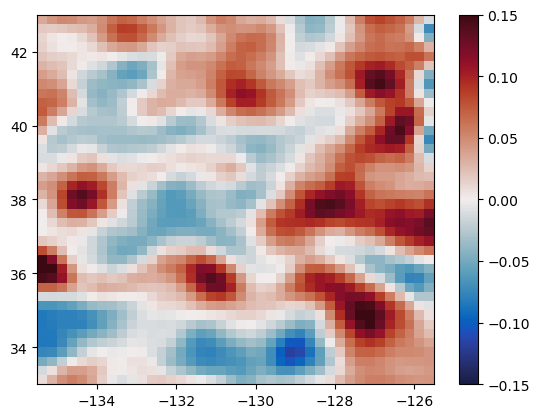

In [11]:
plt.pcolormesh(lon, lat, SSHA[:, :, 0], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
plt.colorbar()

#### Rossby wave vertical modes

In [12]:
MModes = 1

### Inversion with selecetd swath data points

In [13]:
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')

### parameters

In [14]:
Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N

In [15]:
Psi = strat_ds.Psi.data


### the aviso data is sampled at 5-day intervals

In [16]:
#selected_time = 12 #(day1 - day0) * 2 + 1 #12 # 5 * 8 = 40 days

#### Rossby wave estimate

In [17]:
# wave_ds = xr.open_dataset('./rossby_wave_estimate_' + start_date + '_' + n_waves + 'waves.nc')
wave_ds =  xr.open_dataset('rossby_wave_estimate_2016-06-01_190waves_data50days.nc')

In [18]:
l_n_orig, k_n_orig = wave_ds.l_n.data, wave_ds.k_n.data
amp = wave_ds.Amplitudes.data
time= wave_ds.time.data
MSLA_fwd = wave_ds.MSLA_forward.data
Rm = wave_ds.Rm.data # Rossby deformation radius, unit: degree
time[0]

numpy.datetime64('2016-06-01T00:00:00.000000000')

In [19]:
l_n = l_n_orig.reshape(len(l_n_orig), MModes)
k_n = k_n_orig.reshape(len(k_n_orig), MModes)

#### !!! fix the indexing of forward model: day0, day1

In [20]:
MSLA0 = wave_ds.MSLA_forward.data[:, :, day0:day1]

In [21]:
skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA0, Psi, k_n, l_n, MModes, Rm, lon, lat, T_time)

In [22]:
Iindex.shape, Jindex.shape, Tindex.shape, T_time.shape, MSLA0.shape

((16000,), (16000,), (16000,), (150,), (40, 40, 10))

#### Number of models/waves

In [23]:
M = k_n.size * l_n.size

#### Plot skill matrix

In [24]:
kk, ll = np.meshgrid(k_n, l_n)

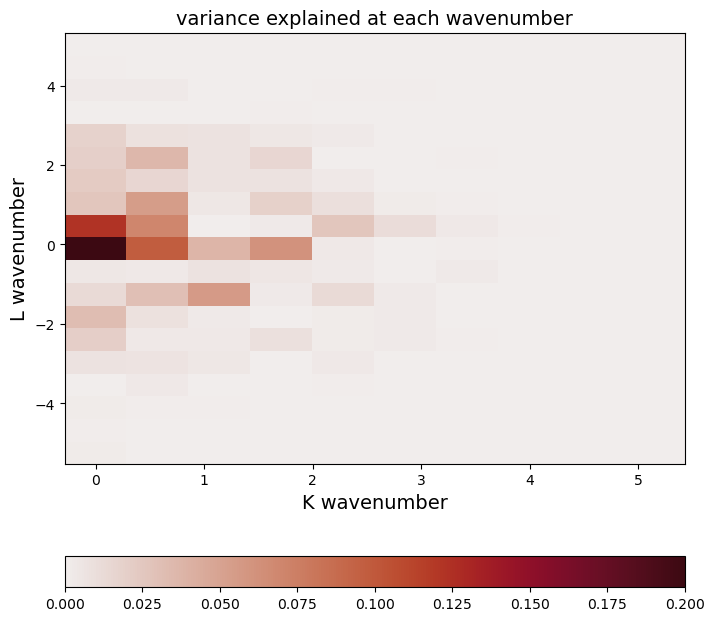

In [25]:
plt.figure(figsize = (8, 8))
plt.pcolor(kk, ll, skill[:, :, 0].T, cmap = cmo.cm.amp, vmin = 0, vmax = 0.2)
plt.xlabel('K wavenumber', fontsize = 14)
plt.ylabel('L wavenumber', fontsize = 14)
plt.colorbar(orientation = 'horizontal')
plt.title('variance explained at each wavenumber', fontsize = 14)
plt.savefig('./skill_matrix_KLwaves_' + str(M) + '.png')

#### Build basis function H matrix

In [26]:
    dlon = lon - lon.mean()
    dlat = lat - lat.mean()
    
    H_cos, H_sin = np.zeros([len(SSHA_vector), M]), np.zeros([len(SSHA_vector), M])
    H_all = np.zeros([len(SSHA_vector), M*2])
    omega = np.zeros([len(k_n), len(l_n), MModes])

    nn = 0 
    for kk in range(len(k_n)):
        for ll in range(len(l_n)):
            for mm in range(MModes):
                omega[kk, ll, mm] =   (Beta * k_n[kk, mm]) / (k_n[kk, mm] ** 2 + l_n[ll, mm] ** 2 + Rm ** -2)
                for count in range(len(Iindex)):
                    H_cos[count, nn] = Psi[0, mm] * np.cos(k_n[kk, mm] * dlon[int(Iindex[count])] + l_n[ll, mm] * dlat[int(Jindex[count])] + omega[kk, ll, mm] * T_time[int(Tindex[count])]) 
                    H_sin[count, nn] = Psi[0, mm] * np.sin(k_n[kk, mm] * dlon[int(Iindex[count])] + l_n[ll, mm] * dlat[int(Jindex[count])] + omega[kk, ll, mm] * T_time[int(Tindex[count])])
                nn += 1

    H_all[:, 0::2] = H_cos 
    H_all[:, 1::2] = H_sin
    H_all1=H_all

/var/folders/1w/2s58vmmj44x13x6_fxjpksb00000gq/T/ipykernel_86915/2942113799.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  omega[kk, ll, mm] =   (Beta * k_n[kk, mm]) / (k_n[kk, mm] ** 2 + l_n[ll, mm] ** 2 + Rm ** -2)


#### Use the same signal to noise ratio as the forward model

#### signal to noise ratio

Signal to noise ratio decreases in proportion to $k^{-2}$

In [27]:
counter = 0
kl, P_over_R = np.zeros(2 * M), np.zeros([2 * M, 2 * M])
for kk in l_n:
    for ll in k_n:
        kl[2*counter] = np.sqrt(kk ** 2 + ll ** 2)
        kl[2*counter+1] = np.sqrt(kk ** 2 + ll ** 2)
        P_over_R[2*counter, 2*counter] = kl[2*counter] ** exp
        P_over_R[2*counter+1, 2*counter+1] = kl[2*counter + 1] ** exp
        counter += 1

/var/folders/1w/2s58vmmj44x13x6_fxjpksb00000gq/T/ipykernel_86915/1391850354.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kl[2*counter] = np.sqrt(kk ** 2 + ll ** 2)
/var/folders/1w/2s58vmmj44x13x6_fxjpksb00000gq/T/ipykernel_86915/1391850354.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kl[2*counter+1] = np.sqrt(kk ** 2 + ll ** 2)


#### solve for amplitudes with all data

In [28]:
H_all = build_h_matrix(MSLA0, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, day0-day0)
amp_all_data, ssh_estimated = inversion(SSHA_vector, H_all, P_over_R)

In [29]:
H_all.shape, H_all1.shape, T_time.shape, MSLA0.shape, H_cos.shape

((16000, 380), (16000, 380), (150,), (40, 40, 10), (16000, 190))

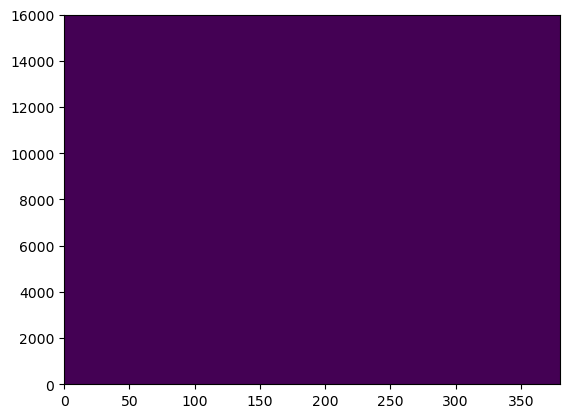

In [30]:
plt.pcolor(H_all-H_all1)

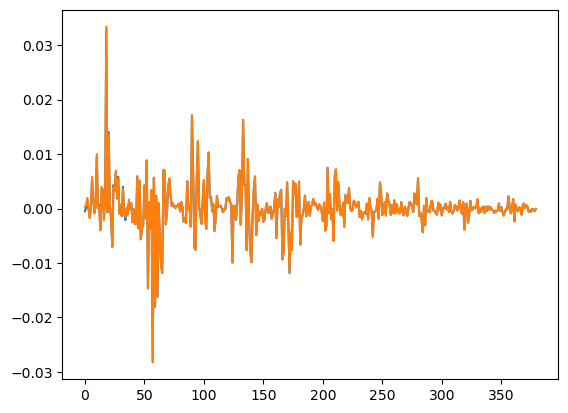

In [31]:
plt.plot(range(len(amp)),amp_all_data)
plt.plot(range(len(amp)),amp)

In [32]:
time_range = (day1-day0) * 2
time_range

20

In [33]:
ssh_estimated.shape

(16000,)

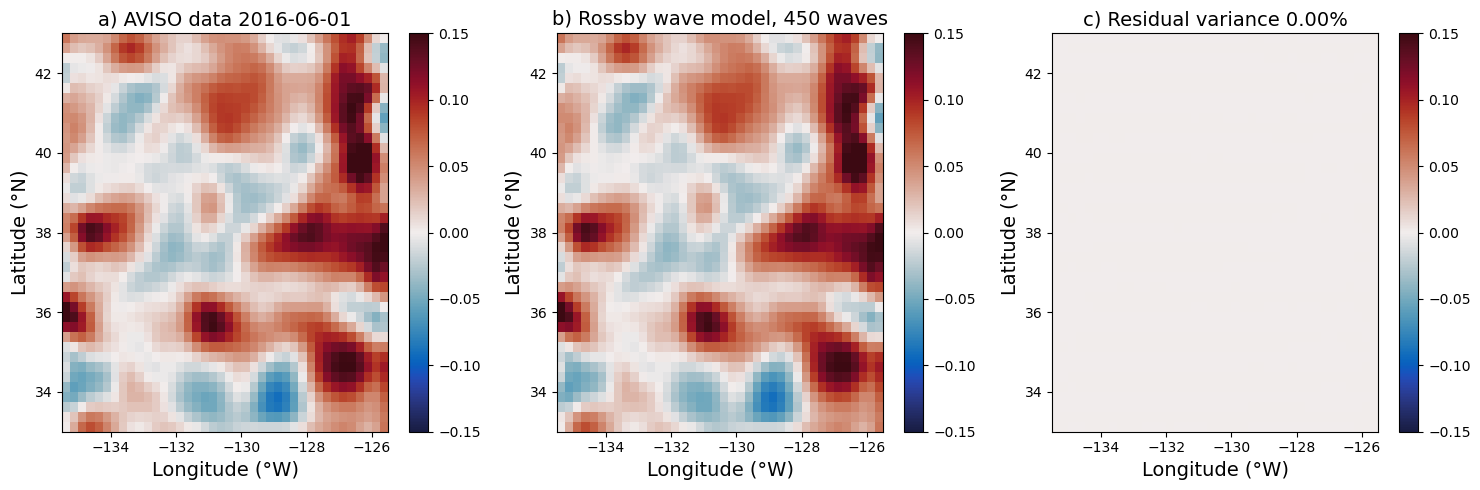

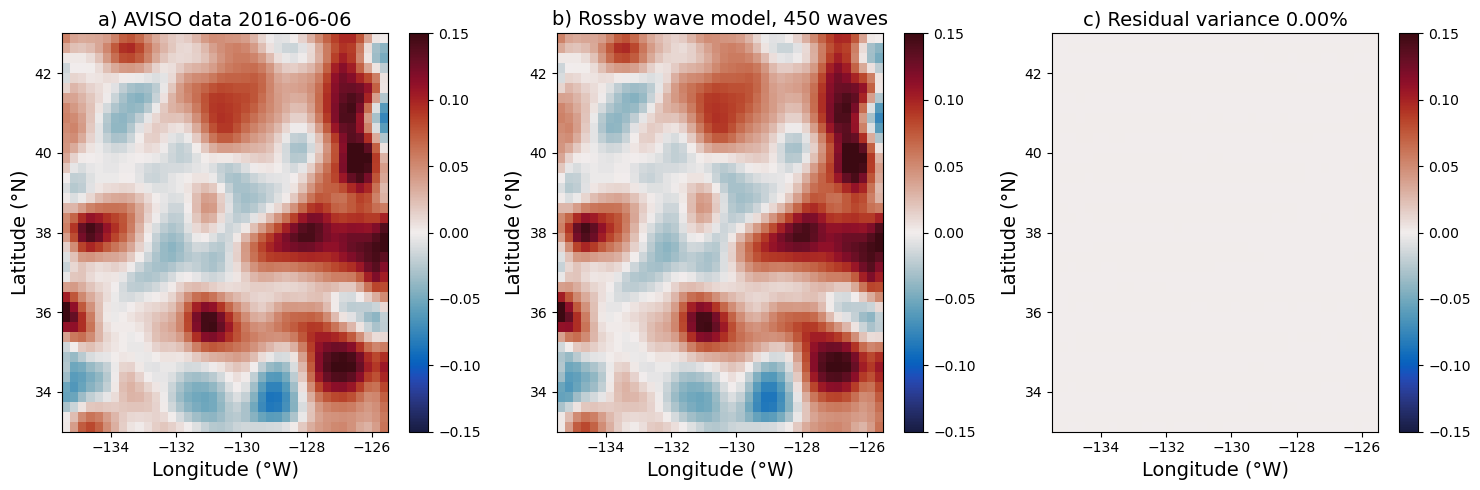

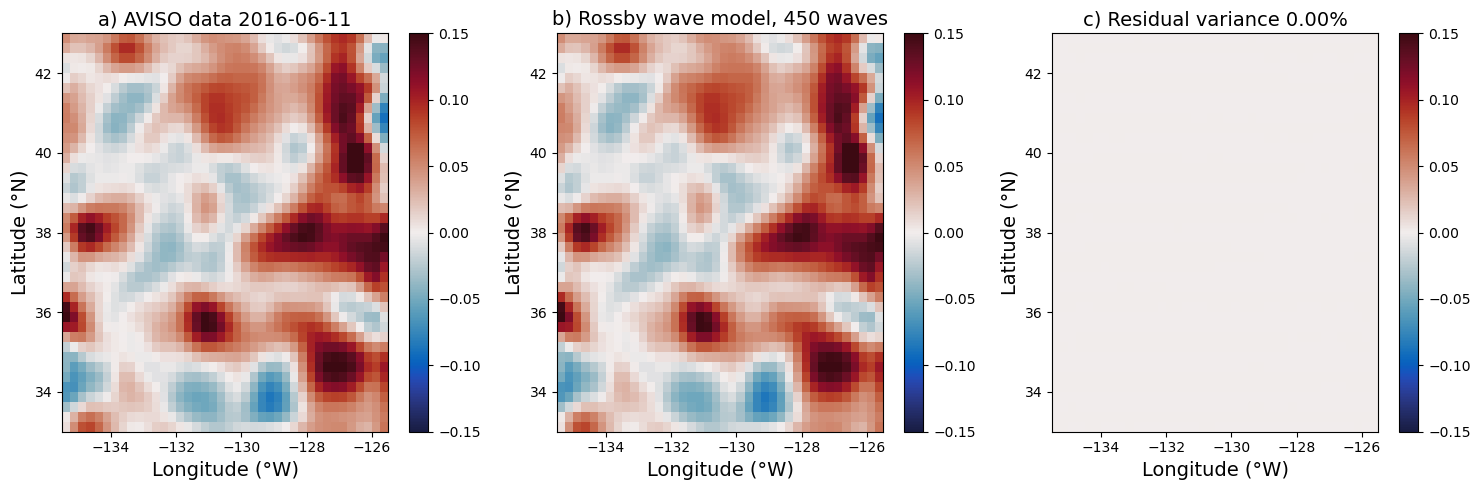

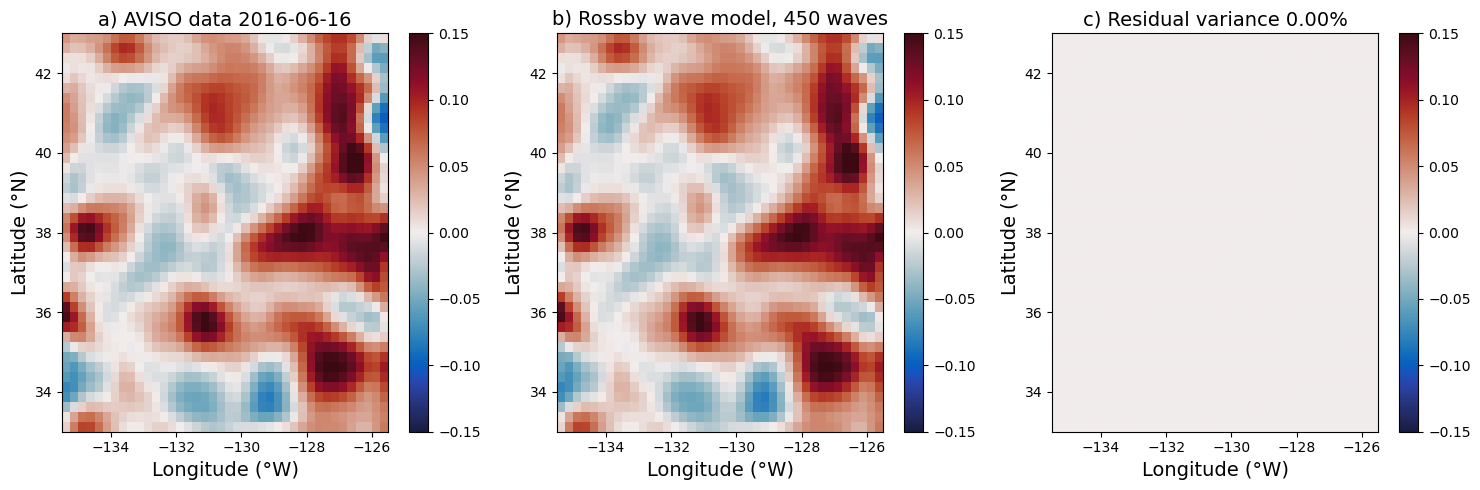

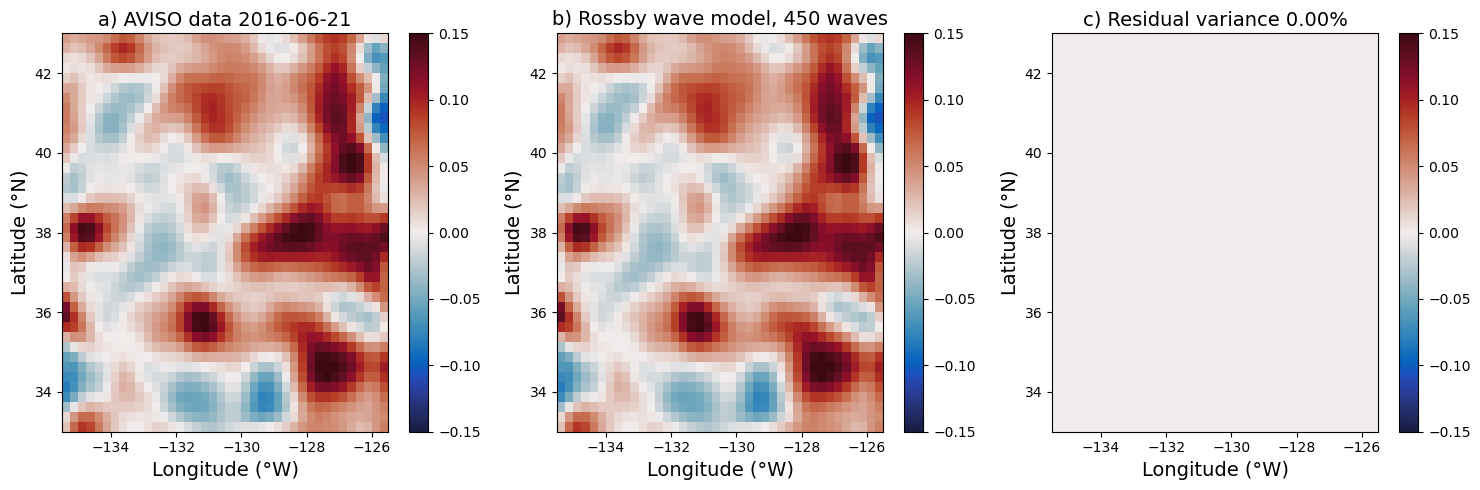

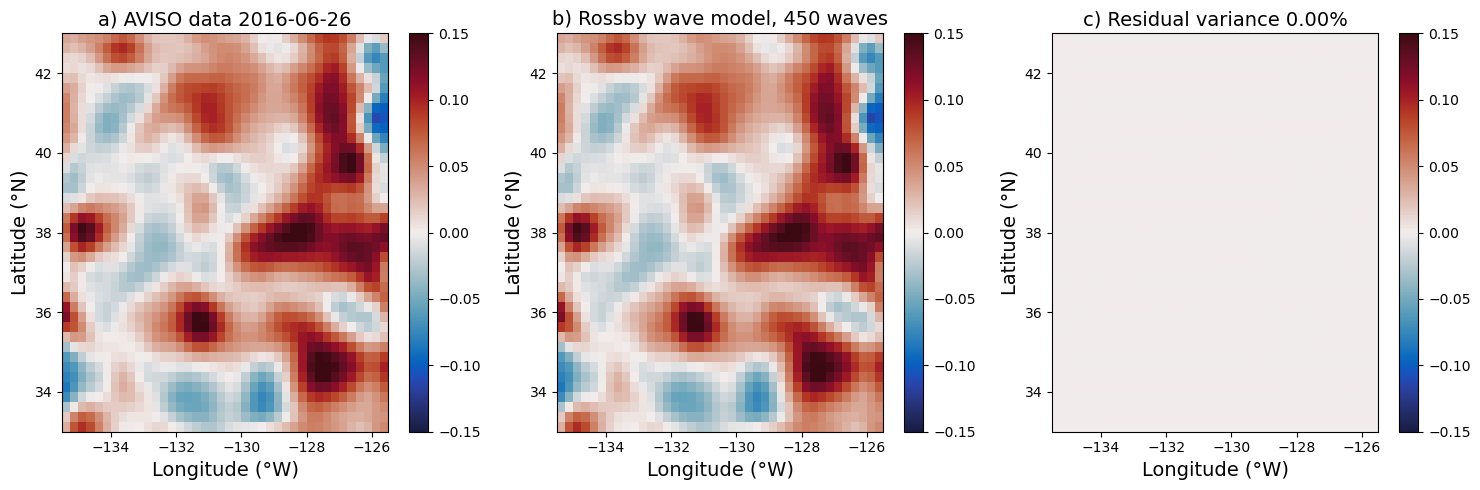

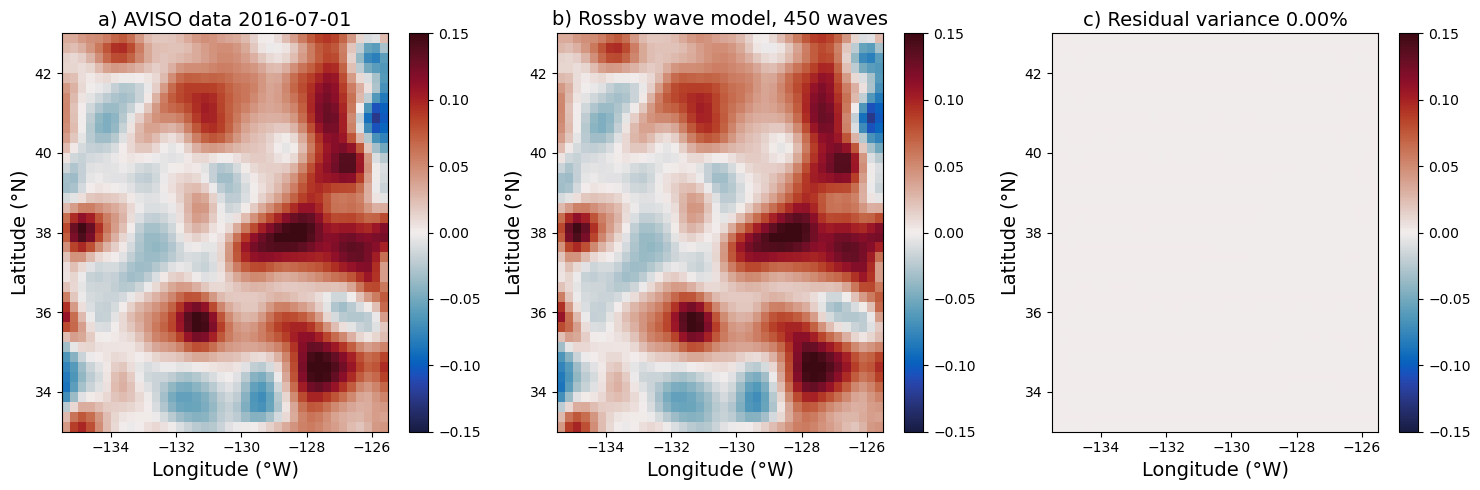

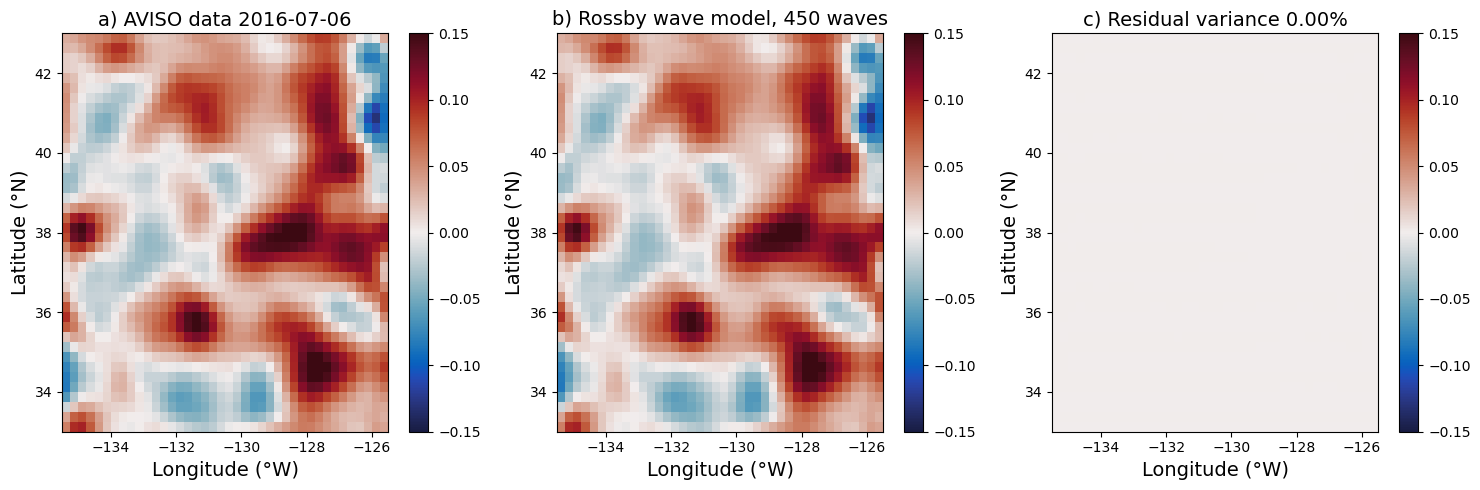

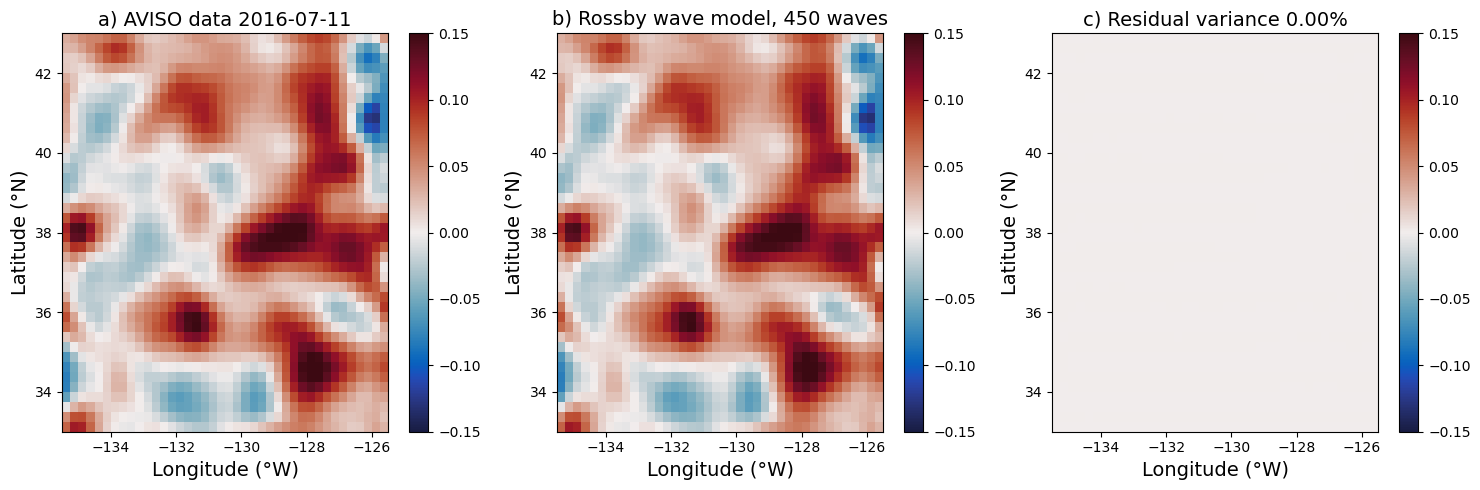

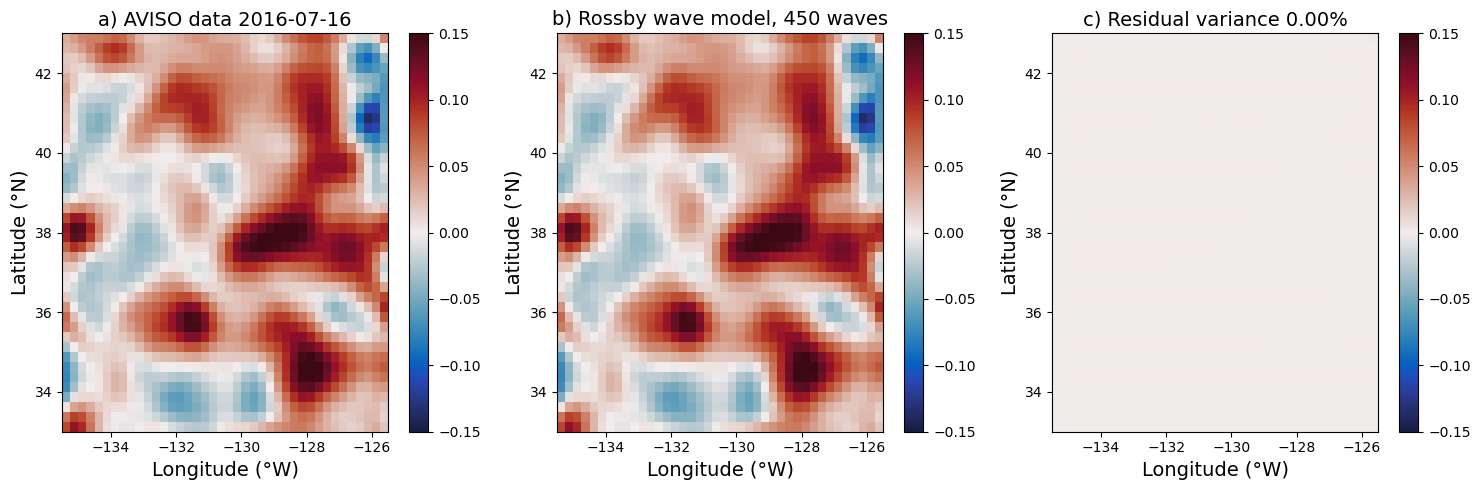

In [34]:
# verify that with perfect data and known amplitudes, we reconstruct the field exactly
SSHA_predicted = np.zeros([time_range, MSLA0[:, :, 0:1].size])
ssh_estimated_matrix=np.transpose(np.reshape(ssh_estimated,[MSLA0.shape[-1],MSLA0.shape[0],MSLA0.shape[1]]),(1,2,0))
SSHA_true = np.zeros([time_range, MSLA0[:, :, 0:1].size])
variance_explained_inverse  = np.zeros(time_range)
MSLA_fwrd = np.zeros([MSLA0.shape[0], MSLA0.shape[1], time_range])
for day in range(10):
#for day in range(1):
    # SSH data
    #MSLA = SSHA_masked[:, :, day0+day: day0+day+1]
    MSLA = ssh_estimated_matrix[:, :, day0+day:day0+day+1]
    # Build basis function H matrix
    H_all = build_h_matrix(MSLA, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, day0 - day0 + day)
    # forecast SSH
    SSHA_predicted[day], SSHA_true[day], variance_explained_inverse[day] = forecast_ssh(MSLA, amp,  H_all)
    # reverse vector
    MSLA_fwrd[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day,:])

    plt.figure(figsize = (15, 5))

    plt.subplot(131)
    plt.pcolormesh(lon, lat, MSLA[:, :,0], cmap = cmo.cm.balance, vmin = -.15, vmax = .15) 
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('a) AVISO data ' + str(date_time[day])[:10], fontsize = 14)

    plt.subplot(132)
    plt.pcolormesh(lon, lat, MSLA_fwrd[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('b) Rossby wave model, 450 waves', fontsize = 14)

    residual = MSLA[:, :,0] - MSLA_fwrd[:, :, day] 
    plt.subplot(133)
    plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('c) Residual variance ' + str((variance_explained_inverse[day]) * 100)[:4] + '%', fontsize = 14)
    #data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABcgAAAHqCAYAAAAwHK1VAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAADM30lEQVR4nOzdd3hT9f4H8PdJmqR7UkorUDayZQ+VoTLdC0REZSniYDgQF6gojisiKg5UkCsq1+vCe3GATAEXCNeJCJSySlndO/n8/uCXSEj6PUlOS5vm/XqePA+czxnfJKfnnfM9SxMRARERERERERERERFRiDHVdAOIiIiIiIiIiIiIiGoCO8iJiIiIiIiIiIiIKCSxg5yIiIiIiIiIiIiIQhI7yImIiIiIiIiIiIgoJLGDnIiIiIiIiIiIiIhCEjvIiYiIiIiIiIiIiCgksYOciIiIiIiIiIiIiEISO8iJiIiIiIiIiIiIKCSxg5yIiIiIiIiIiIiIQhI7yImIiKhWWrt2LTRNw6xZs3yepn///ujZsydEpPoaVgsE8tlQ8GvSpAmaNGliaB6zZs2CpmlYu3ZtlbSJiIiIiCjYsYM8iK1ZswaapmHFihU13ZQ6pX///tA0raabQUREAZg5cya+//57vP/++35Np2ma2yssLAwpKSm45JJLsGrVqmpqLVHdsWfPHkRHR0PTNEycONGjnpGR4fF3duqrsr/ZnTt3Yvjw4UhOTkZERAQ6duyIl156CQ6Ho7rfEhGFmEWLFsFsNuPnn3+u6aYEzN8DqYsXL4amaVi8eHG1tcmbqjjge6awf4AoNLCDPIgNGDAA/fr1w7333gu73R7QPPLz8107M/fcc49bLScnB5GRkUhISEBJSYlyPi+++CI0TcNdd90F4O8z27ztIG3cuBHXXnstzjrrLFitViQkJODss8/G9ddfj7fffrvSZXz88ce47LLLkJqaCqvViuTkZFx00UV46623An7/1eXmm2+GpmnIyMiotmUUFhbinXfewfDhw9GqVStEREQgPj4e/fr1w3vvvVfpdA6HAy+99BI6duyIiIgIJCcnY/jw4di5c6fX8d955x3ceuut6NatG2w2m88/oPbs2YMJEyYgPT0dNpsNKSkpGDBgAD744AO/3+uXX36J/v37IzY2FjExMejfvz++/PJLj/H0dr41TYPZbPZ5uUVFRXjuuedw/fXX4+yzz4bJZPL5e127di0uv/xy1K9fHzabDY0aNcKVV16J7du3+/PWichPAwYMQNeuXfHII4/4fRZ5UlISZs6ciZkzZ+Kee+5Bjx49sGLFCgwcOFC5XSUKdSKCMWPG+DRup06dXH9np77at2/vMe5vv/2G7t2745NPPsHgwYNdvzPvvPNOr78xiYiMGD16NJo2beqxX6zHue936ismJgZdu3bFM888g9LS0mpqMVHV83XfW09paSkee+wxtGrVCuHh4UhNTcX48eORlZVVJcveuHEjevfujZiYGLRp0wZvvfWW1/H++OMP2Gw2zJ8/3+/3QKElrKYbQMbcc889uPTSS/Hee+/hhhtu8Hv6ZcuWobCwEJqmYcmSJZgzZw4sFgsAID4+HldddRWWLl2Kjz/+GCNHjqx0Ps6N0bhx45TLW7x4McaOHYuwsDAMGzYMLVu2RHFxMXbv3o0VK1Zg/fr1uOmmm9ymKSwsxPXXX4/ly5cjISEBF198MRo1aoQjR45gxYoVGDduHBYuXIjly5cjOTnZ788gWG3YsAGjR49GUlISLrzwQlx99dXIzs7GRx99hOuvvx6bNm3Ciy++6DHdxIkTsXDhQrRt2xZ33nknDh8+jGXLluGrr77Cpk2b0LZtW7fxH3roIezduxf16tVDamoq9u7dq9u2lStX4oorrgAAXHrppWjWrBlOnDiB//3vf1i1ahWuvfZan9/n0qVLccMNN6BevXq46aaboGka/vWvf2HIkCF45513MGrUKNe48fHxmDlzptf5/Pjjj/jvf/+LwYMH+7zs7Oxs1w/k9PR0JCQk4Pjx47rTPfHEE3jooYeQlpaGK664AvXq1cPhw4exceNG/Pzzz+jUqZPPbSAi/91www2YOnUqvv76a1x00UU+T1evXj2PW5a8//77GDlyJGbMmKHMQaJQ9uKLL2Ljxo145plnMG3aNOW455xzjs+3BrrtttuQm5uL//73vxg2bBgAYPbs2Rg6dCgWLlyIkSNHYsCAAUabT0QEAAgLC8OUKVNw55134ptvvsF5553n1/Tjxo1Dw4YN4XA4cPDgQXzyySeYPn06Vq9ejS+++KKaWu3u66+/PiPLCSVLlixBUVFRTTfjjPBn31vF4XDg8ssvx5dffomePXviqquuwq5du7Bo0SKsXLkS3333HRo0aBDwsjMzMzFo0CDUr18ft9xyC7799luMGzcOiYmJrn4I4OQB/FtuuQXnnHMO7rjjjir5jKgOEwpq5eXlkpycLOeee25A0/fq1UtsNpvceeedAkA+/PBDt/rq1asFgFx00UWVzuOnn34SANK1a1fXsDVr1ggAufXWW13DCgsLJSYmRmJjY+Xnn3/2mE9ZWZl89dVXHsOvvfZaASAXX3yxnDhxwq1WXFws48ePFwDSp08fKS8v9/WtV6pfv35i9E/jpptuEgCyZ88ew+2pzLZt22Tp0qVSVlbmNjwrK0vS09MFgHz//fduNef3ef7550tJSYlr+KpVq0TTNOnbt6/HclauXCkZGRkiIjJnzhwBIIsWLaq0XZmZmRIbGystW7aUvXv3etT9+Y6OHz8u8fHxUq9ePcnMzHQNP3jwoDRo0EDi4+Pl+PHjPs3rkksu8bqOq+Tn58tXX30lx44dExGRwYMH636vn376qQCQK664QoqKijzqVbGOEoUKZ5bMnDlT1q1bJ3379pWoqChJSEiQkSNHyr59+7xOd+DAAQEg119/vc/LAiCtW7f2GO5wOCQ6OloAyJEjR9xqhYWFMnPmTGndurXYbDZJSEiQYcOGycaNGz3mU1xcLP/4xz+kY8eOEhsbK1FRUdKsWTO57rrr5H//+59rPLvdLgsXLpTu3btLQkKCRERESHp6ulx++eWybt26gD4bu90uTZo0kcTERLdt/6m6d+8uFotFDh8+XOlndOzYMTGZTHL55Ze7Df/+++8FgADw+E569Ogh0dHRrm1fTk6OPPXUU9K3b19JTU0Vi8UiqampMnr0aPnrr7/cpn300UcFgCxZssRre9555x0BII899pjb8N27d8u4ceOkUaNGYrVapUGDBnLTTTe5sswX6enpkp6eLjk5OTJx4kRp0KCBREZGyvnnny9btmwREZFDhw7JjTfeKMnJyRIRESGDBg2SnTt3ep3fxo0bZdiwYZKQkCA2m01at24tM2fOlMLCQq/jf/LJJ9KtWzcJDw+X+vXry/jx4+X48eOudp2utLRUnnvuOencubNERkZKdHS0nHfeefLpp596jDtz5kwBIGvWrPH581DZuXOnREZGygMPPOD195/Tnj17BIDcdNNNPs13x44dAkAGDBjgUfv2228FgIwcOVJ3Ps8//7wAkI8//tht+KRJkwSAXHjhhW7Df/vtNwEgEydOdA378ccf5fbbb5d27dpJbGyshIeHS/v27WXOnDkev8OaNWsm0dHRlX63F110kWia5vEb6ZNPPpELLrhA4uPjxWazSbt27eTZZ5+ViooKt/F83UYQUWCOHDkiYWFhMmrUKJ+nce77bd682W340aNHJS0tTQDI6tWrq7qpVWLRokW6+3fVobI8o5pTlfveb731lgCQ6667ThwOh8fwG2+80dCyn3zySTGZTK7fdhUVFdKqVSsZPHiw23xfe+01sVgsbr+1iSrDDvJapLS0VObPny+DBg2Shg0bitVqleTkZLnyyitl69atlU43YcIEASB//vmnX8v79ddfBYBcffXV8tdffwkAGTZsmNs4DodDmjdvLiaTyWtnp4jIHXfcIQBkwYIFrmHedpC+++47AeCxY62yatUqASAtW7b02tnobON5550nAOTNN9/0ed4bNmyQvn37SmRkpCQmJsrw4cMlMzPTawf5gQMH5JFHHpGePXtKcnKyWK1WSU9Pl9tuu82jM8HZOX36q1+/fq5xPvroI7nuuuukefPmEhERIbGxsXLeeefJv//9b5/br/Lkk08KAHn22Wfdho8cOVIAeN2BGjJkiACQHTt2VDpfXzrIJ06cKADk66+/Drj9Tq+99poAkEcffdSj9tRTTwkAee2113Tnc+DAATGbzVK/fn2PHVl/+NJB3qZNG4mJiZGcnJyAl0NEJzmzZPDgwWK1WuXKK6+UGTNmuP4WGzVqJFlZWV6nbdy4saSmpvq8LFUHeVRUlABwO0hbUlIivXr1EgDSpUsXmT59uowZM0YiIyMlLCzM42Dc8OHDBYB07NhRJk+eLPfdd59cd911kpKS4rZNve+++wSANG/eXG6//Xa5//77ZfTo0dKkSROZOXNmwJ/NE088IQBk6dKlHu/xf//7n+v3gJ5zzjlH4uPjxW63u4Y988wzrqw7tTM7Ly9PwsLCZOjQoa5hmzdvFqvVKoMHD5ZJkybJvffeK5deeqmYzWZJTEx068TetWuXAJBBgwZ5bcuQIUNE0zTZvXu3a9i3334rcXFxEhYWJldeeaXce++9cu2110pYWJjUr19fdu3apfseRU5meWpqqnTv3l06dOggkydPluuuu05MJpMkJCTI77//Lunp6dKzZ0+ZOnWqXHrppa516PQOzX//+98SFhYmkZGRMmbMGJk+fbp07dpVAEjv3r09Dlq8/fbbAkBiY2NlwoQJcu+990qbNm2kS5cukpqa6tGhUFJSIv379xcA0rlzZ7nzzjtl4sSJ0qhRIwEgL774otv4VdlBbrfb5bzzzpM2bdpISUmJTx3kAwcOlAULFsiTTz4pixcvrvRAl/M3wJw5czxqDodD4uPjJS0tTbeN27ZtEwBy1113uQ1v27atAJCIiAgpLS11DV+wYIEAkGXLlrmG3XrrrZKWlibXXXed3Hvvva7OcgBy1VVXuc33kUceEQDy7rvverTl4MGDYjKZ3H4TiojMmDFDAEjDhg1l3LhxMnXqVNc6cs0117iN6+s2gojcrV+/Xq644gqpX7++WK1WadiwoVx55ZWyYcMGj3EHDhwoNptN8vPzfZp3ZR3kIn8fjDt9v0xEZPv27TJixAhp0KCBWCwWady4sdxxxx1y9OhRj3FXr14tQ4YMkdTUVLFarZKamir9+vWThQsXuo1XWcfzsWPH5NZbb5X69etLRESEdOvWTT766COvHeSnHoQ/XWUHO1evXi1jxoyRVq1aSVRUlERFRUnXrl0r3VfztYPcmYmnHwx3+uabbwSAjB07NuC2OPfV9+/fLzfddJOkpKSIpmmunPTWP+DPAX8R9+xdtmyZdO7cWcLDw6VBgwZy5513VtrX4et663A45M0335Q+ffpITEyMRERESNeuXf3qH6mqfW8Rkd69ewsArycntGnTRmw2m+Tl5QW87Ntuu01SUlLcxhs+fLi0adPG9f9Dhw5JfHy8PPDAAz61mYgd5LXIoUOHXD+ab7nlFpk+fbpce+21YrPZJDw83ONsYCfnUbhXX33Vr+VNmzZNALjOLurTp4+YzWbZv3+/23izZ8+udGNVWloqiYmJEhER4dZx4G0HaefOna7OgVN3rFWuv/56n97b559/LgB8PpN+1apVYrFYxGazyY033ij333+/dO/eXRo1aiQdO3b0CMD33ntPoqKi5LLLLpO77rpL7r77brngggsEgDRr1sytM/T555+XTp06CQCZPHmyzJw5U2bOnOn2o6N169bSoUMHuemmm+T++++XcePGSXJysgCQ+fPn+/QeVJ599lkBIM8//7zb8NTUVImKivLYeXe2G4C8/vrrlc5Xr4Pc4XBIYmKiJCUlicjJM66ee+45efbZZ2XlypU+f+9Ozg59bz82nVcu+HKGqLNj6J577vFr+afT6yDfvn27a2e5oqJCVqxYIU899ZTMnz9ftm3bZmjZRKHImSUA5I033nCrOc8uPnWH6FRXXnmlAHDrPFWprIP8n//8pwCQdu3auQ1/7LHHBICMGjXK7cyY7du3u84md/7wz8nJEU3TpFu3bh7b34qKCrf8TExMlLPOOsvj7FOHw+G6mkXE/8/m0KFDEhYW5vVs3LvuuksAyOeff17Zx+MydepUAeA6i1pEZOjQodKhQwepX7++jBkzxjX8v//9rwCQZ555xjUsJyfH7X04rV69Wkwmk4wfP95t+Lnnnitms1kOHTrkNvzw4cMSFhYm5513nmtYWVmZNGnSRGJiYjy2uRs2bBCz2SyXXHKJ7nsU+ftg97XXXut25Y9zJy0+Pl6mTp3q9t3fdtttAkA++ugj17C8vDzXGcHbt293DXc4HK7fOI8//rhreG5urusKg1MPWJeVlUnfvn0FgEeHwgMPPCAAZNasWW7tycvLk27duonVapUDBw64hldlB/lzzz0nJpNJNm3aJCLef/85OTtVTn+FhYXJtGnTPH4j3HPPPQKg0pMHunXrJgAqPVPbyeFwSFJSknTo0ME1LCsry3X2+OknDjivXDz1BIiMjAyPv12HwyFjx44VAPLNN9+4hjt/755+0omIyD/+8Q+Pv9mvvvpKAMjQoUPd3ovD4XCddHDqZ+DrNoKI/vbSSy+JpmkSGRkpo0aNkhkzZsiNN94ozZo1k8mTJ3uM7zzQ9cUXX/g0f1UHuTMbTt8v+/TTT8Vms0lkZKTr4NvFF1/sOjns1LNl//Of/4imaZKQkCA333yzzJgxQ8aPHy/dunWT/v37u83XW8dzYWGhdOjQwXVg9v7775dRo0aJxWJxLdNoB/ngwYOlefPmMmrUKJk+fbrceuutriydNm2ax3x87SDPz8+XyMhIr7/RRP4+OevUTPO3LQCkffv20qhRI+nUqZPcddddMnHiRNdvHW8d5P4c8Bf5O3uvueYaiYqKkuuvv16mTp0qbdq0qXSf1tf19tTfFK1atZJbb71V7rzzTjn77LMFgNx99926n7NI1e17FxcXi8lkqvQ7mzx5sgBwu3uAv8t+8skn3fqu7Ha7nH322W5nkF977bXSsmVLKS4u1m0zkQg7yGuVkpISj85pEZFffvlFoqOjK73NibNT7vTLVFTKysokOTlZkpKSXGfUOo/azZ49223c/fv3i9lslqZNm7rteImILFu2TADIDTfc4Dbc2w6Sw+GQLl26uI7QLlq0SH777TevnbVOTZo0EQCVXrLsVFRUJGFhYWK1WpXzEzm58WzWrJlomuZ25PXUYDk9AA8fPuz1DALnEe3TPzO9W6x4O4MtPz9fOnToIHFxcbo7eyoVFRXSoUMH0TTN7VY2BQUFrvD35j//+Y8AkHvvvbfSeet1kDvP9uvevbvrx8qpr86dO1d6ppg3zp1fb2dRON9P9+7dlfNwXgUBQH7//Xefl+2NXgf5m2++KQBkwoQJrjNLT32NGjXK7Sw1IlJzZknr1q098qeoqMh1awtvf1fObdD69et9WhYASUpKch3UnD59ulx88cWuHZPTr7xp1qyZWCwWr9u0W2+9VQDIP//5TxE52enp60HcxMREadq0qe62IpDP5qqrrhJN09zObCopKZHExERp3LixTwcxnbeRcp4JV15eLjExMTJ58mQZPny4286us4OzsgP8p+vQoYM0adLEbdgrr7wiAGTu3Lluw+fNm+dxAP2jjz7y6HA+1VVXXSUmk0lyc3N12+LckT59BzczM1MASHR0tBQUFLjV1q9f79GhsGTJEgEgt912m8cyMjMzJSwsTJo3b+4a5vxdceedd3qMv2HDBo8OcrvdLgkJCdKiRQuP9UBEZPny5QK4n0VeVR3kO3bskIiICJk6daprmKqD/PDhwzJz5kzZtm2b5OXlSXZ2tixfvtzVOXD//fe7je+8QnLlypVel+88UeHgwYO6bb3yyitF0zTJzs4WEZH333/ftX0ICwtzfWcOh0OSk5Olbdu2Pn0GW7ZscR2cOFXPnj0lLCzMtTync845R8LDw91OrLjssssEgNsl5U7Og2unXt3h6zaCiE763//+J2azWdLS0jx+wzscDrcDiE7OrHvkkUd8WkZlHeTZ2dmSmprqkYVHjx6V2NhYadiwocdV2u+++64AkDvuuMM17KqrrhIAbgdaT53Xqbx1PDu3+xMmTHAb/uWXX7r2U4x2kHs7IaG8vFwGDhwoZrPZ4336c4uVUaNGef09UVZWJklJSdKoUSO3DPS3Lc7PYMyYMV77Eio7g9yfA/7O7yAuLk7++OMP1/CioiJp1aqVaJrmti76s96+/vrrAkDGjRvndlC/tLTUdYXbjz/+6NHW01XFvrfIyf4rAJWelPDSSy8JAHn55ZcDXnZGRoZERERIixYt5J577pHzzz9fgL9vp+o8qFRbb21EtZMJVGvYbDacddZZHsPbtWuHAQMGYP369SgvL/eop6SkAAD279/v87KWL1+OI0eO4LrrrnM9lHP48OEIDw/HW2+9BRFxjXvWWWdh0KBB2LNnD9auXes2H18fzgkAmqbhgw8+QO/evbFu3TqMGTMGbdu2RWxsLC666CIsXrwYdrvdbRrnE44bNWqknHdERASSkpJQVlaGY8eOKcf95ptvsHv3blxyySVuD17RNA1PPvkkzGazxzT169dHdHS0x/DRo0cjNjYWq1atUi7zdM2aNfMYFh0djZtvvhm5ubn44Ycf/JrfqR5++GH8/PPPGDNmDNq3b+8anpubCwCIi4vzOl1sbKzbeIHIzs4GAGzduhXvvPMOFi1ahOPHj2PPnj2YMGECfvrpJ1xzzTU+z0/V5qioKJjNZt32rlu3Drt27cJ5552Hs88+24934z/n+3/rrbdw9OhRrF69Gvn5+di6dSt69+6NpUuX4uGHH67WNhDVReeeey40TXMbFhERga5du6K4uBh//vmnxzSJiYkAgKNHj/q8nGPHjuHRRx/Fo48+iqeffhr//e9/ERkZiZUrV6Jv376u8fLy8rB79260aNECDRs29JhP//79AQDbtm0DcHL7OmTIEGzcuBFdunTBk08+iQ0bNqCsrMxj2uHDh2PPnj1o3749Hn74YaxatQqFhYWVttmfz+bWW2+FiODNN990Dfv4449x/PhxjB07FiaT/s/Cvn37wmQyYc2aNQBOPgA5Pz8fAwYMwIABA7B3717s2bMHALBmzRrExsaiS5cubvNYu3YtrrjiCqSmpsJisUDTNGiahp9//hkHDx50G3fEiBGwWq1455133Ib/85//hNVqxfDhw13Dvv32WwDAH3/8gVmzZnm8srKy4HA4vK4v3sTHxyM9Pd1tWGpqKgCgZcuWiIqK8lo7cOCAa9hPP/0E4O914lSNGjVC8+bNsWvXLuTn5wMAtm/fDgA4//zzPcbv3bs3wsLC3Ibt2LEDJ06cgM1mw6OPPurxnp0Phfvjjz98es++cjgcuPnmm5GWlobZs2f7NE39+vUxa9YsdOrUCTExMUhOTsall16K1atXIykpCXPnzsWJEyeqtJ1OAwYMgIi4fseuWbMGiYmJOPfcc9G1a1fX+vzrr7/iyJEjHg/+LCsrw9y5c9GjRw/ExsbCZDJB0zR07doVADzW29GjR6OiogLvv/++a9ivv/6Kbdu24dJLL3X7XfPtt98iKioKb775psf39/zzzyMiIsLt+/N3G0EU6l599VXY7XbMnj0bTZo0catpmoa0tDSPaQLZvwaAN954A7NmzcLMmTMxfvx4nH322Th06BDuuOMOdO/e3TXekiVLkJeXhzlz5qBx48Zu8xg5ciS6dOnitv1wioiI8BiWlJSk264lS5bAarXisccecxs+aNAgXHjhhb6+PaWmTZt6DAsLC8PEiRNht9td29lA3HDDDQDg8VtgxYoVOHbsGEaNGuX2WyiQtlitVjzzzDNe+wK8iYuLc/3WPNWAAQPQrl27SvsHJk+ejNatW7v+HxERgZEjR0JEsGXLFtdwf9bbl156CVFRUXjppZfcfidYrVY88cQTAID33ntP9z1Vxb633nwA7/0O/i47PT0dX375JZKSkvDKK68gOzsbr7/+Oq666ioUFhZi0qRJGDt2LAYMGIClS5eiefPmCAsLQ7t27bBy5Urd90ChKUx/FDqTtm3bhmeeeQbffPMNsrKyPDrEjx496toBcwqkE8C5czx69GjXsPj4eFx66aX44IMPsG7dOreduXHjxuHzzz/HokWLXDsN+/fvx8qVK9GsWTP069fPp+U2a9YMmzZtwrZt27Bq1Sr88MMP2LRpE77++mt8/fXXWLJkCT7//HPYbDaf34uTs1P/9I6C06l2PtPT09GoUSNkZGR41D766CO89tpr2Lp1K06cOOHWmX/6jpGe7OxsPPXUU/j888+xd+9eFBcXu9X9nZ/T66+/jjlz5qBz58544YUXApqHEQ6HAwBgt9vx+OOP4+abbwYAJCQk4PXXX8f//vc/fPfdd66nwmdkZGDx4sVu84iPj8eUKVOqrE3Odd3bQZxt27bhk08+cRvWpEkTV7v95Xz/DocD//rXv9C5c2cAQOfOnfHJJ5+gRYsWeOmll/DYY48FtI4Thar69et7He7cgfX2Y925XY2MjPR5Oa1bt3Z1ROXk5OCTTz7Bbbfdhquvvho//vij6yB2Xl6e2/JP16BBA492/fvf/8aTTz6J9957Dw8++CAAICYmBmPHjsWTTz7pauf8+fPRrFkzLF68GLNnz8bs2bMRHh6O4cOH47nnnkO9evXcluXPZzNw4EA0bdoUixcvxuOPPw6z2Yw33ngDJpMJY8eO9ekzio+PR+fOnbFhwwZUVFRgzZo1MJlM6Nu3r+sgobPz8aeffsKwYcPcdjY/+OADjBgxAtHR0Rg8eDCaNGmCyMhIaJqGxYsXY+/evW7LS0hIwMUXX4yPP/4Yf/zxB84++2zs2LEDW7ZswVVXXYWEhATXuMePHwcALF26VPkefO1M9LaT5tzxdO7ceaud+tvNl3Vlx44dyMvLQ0xMjOv78va9ms1mj44Q53v+9ddf8euvv1b6Xqq6A3X+/Pn49ttvsXr1ar/+xrxp0KABhg0bhn/+85/44YcfMGjQIAB/f/6V7Yw7P1tv38XpnL9d16xZg2uvvRZr1qxBv379YDKZMGDAAMydOxfFxcWuTpPTO8ivueYafPbZZ2jVqhVGjBiB+vXrw2KxICcnBy+88AJKS0vdxr/uuuswdepULF26FHfeeSeAkwd1APff3sDJ77CiogKPPvpope0/9fvzdxtBFOq+//57AHBtW3wRyP41ALcD0E5TpkzB888/7zbMeUD322+/xV9//eUxTUlJCY4ePYqjR4+iXr16GD58OD766CP07NkTI0eOxAUXXIDzzz+/0t8Ap8rPz8eePXvQtm1b1++TU51//vn4+uuvfX2LyuX84x//wCeffIJdu3Z55E6g+7fAyd8vDRo0wPvvv4+5c+e6fldUtl0NpC1Nmzb1e/u5du1azJs3D9999x2OHj2KiooKV81qtXqd5vSTBgC4TrbIyclxDfN1vS0qKsLPP/+MtLQ0PPXUUx5152+Sqj5QXhucf/75rr+lUz344IMoLS3Fs88+i++++w433HCD6/f8q6++issuuww7d+70epILhTZ2kNcimzZtwgUXXADg5IawZcuWiI6OhqZp+OSTT7B9+3aPH+CA/50ABw4cwFdffYWWLVuiZ8+ebrWbbroJH3zwAd588023DvLLLrsMycnJ+PDDD/HSSy8hNjYWixcvhsPhwNixY3U7pU93zjnn4JxzznH9f+3atbjhhhuwZs0aLFiwAFOnTgVwcqcpIyMD+/btQ4sWLSqdX3FxMY4fPw6r1er1SO6pVDufwMmd2NM7yJ977jncc889SE5OxqBBg9CwYUPXEfx58+Z5/V4qc/z4cXTv3h2ZmZk499xzcdFFFyE+Ph5msxnbtm3Dp59+6tf8nBYtWoSJEyeiQ4cOWLlypccZ777uaFZ2pNcXp0572WWXedQvvfRSfPfdd/jxxx9dHeSn7xCmp6e7OshPbfPpnQKFhYWw2+3K9ubk5ODDDz9EbGys21mGTtu2bfNYfr9+/QLuIHe2pWHDhq7Ocaf69eujZ8+eWLVqFX7//Xe39Z+I1Jwdr6c7fPgwAO/bLWfHYXJyckDLjI+Px8033wy73Y7x48fj9ttvdx1Qc3bIOZdfWbtO7biLiorCE088gSeeeAJ79uzBmjVr8Oqrr+KFF15AcXExXnvtNQCAxWLBvffei3vvvRcHDx7EunXrsGjRIixZsgRZWVn48ssv3Zblz2ejaRomTJiABx54AP/973/RoUMHrF69GkOHDtW9UutUAwYMwJYtW7BlyxasXbsW55xzDhISEpCQkIC0tDSsWbMGycnJcDgcHh2Ns2bNQnh4OLZs2YKWLVu61bydLQec3PH9+OOP8c4772D27NmV7hA7P+/PPvsMl1xyic/vpzr5u644vy9v36vdbsexY8fcrjZ0Tnf11Vfj3//+d9U1XMe2bdsgIh7fr9Nrr72G1157DZdffrnHgWhvnJ0SRUVFrmHO9WPnzp0e44sI/vrrL6SlpXmcye9Nu3btkJycjDVr1uDQoUP4888/cccddwA4uT4/9dRT2LRpE9auXQtN09xO/Pjhhx/w2WefYfDgwfjvf//rdsDn22+/9XpCQlJSEoYOHYrly5fjr7/+QvPmzfHuu++iXr16GDJkiNu4sbGx0DTN5444f7cRRKEuJycHmqZ5nGSmEshBdgDYvHkzevXqhbKyMmzfvh2TJk3CvHnz0L59e7eTdZy/UV5++WXl/AoLC1GvXj2MGDECFosF8+bNw2uvvYYFCxZA0zT0798fc+fOVe5X+LLva1RZWRn69++PrVu3onPnzhg9ejSSkpIQFhaGjIwMvP322wHt3zqZzWaMHDkSzz//PFauXIkhQ4YgNzcX//3vf9GlSxe0bdvWcFv8/Rz8PeDvpDr4fuoJeL6utydOnICI4MCBAz4faK2M0X1vb/Pxxlu/Q1Ut+8cff8RLL72EpUuXIiEhAfPmzUOLFi3w8ssvQ9M09OrVC2lpaViwYAGefPJJ3flRaOEtVmqRJ554AqWlpfj666+xfPlyPPfcc67LZb0d7XXytxPAeSuTnTt3ui5rdr6cO5Qffvih2wbNYrFg9OjRKCoqwrJly1zzMZvNAXcmnqp///54/PHHAQCrV692De/Tpw8A6B7VXrduHSoqKtC9e3fdy6JUO5+A505sRUUFHn/8caSlpeHXX3/F0qVL8fTTT7sun/N2ibzKm2++iczMTMyePRvffPMNXnzxRTz++OOYNWsWevXq5de8nN566y2MHz8ebdu2xddff+31UruoqCikpqZiz549HreyAf7eAT29w8IfLVq0cH3+8fHxHnXnMOePzv79+0NOPgvB9Tr14IRq59iX9r777rsoLi7GyJEjvf7Avfnmmz2Wf/pthPzhvFzO23s/dfjpVwwQkdrGjRvdbv0FnPw72rJlCyIiItCqVSuPaXbs2AGLxWL41kpjx45Fly5d8Omnn2LTpk0ATnZoNWvWDH/99Zfb7TSc1q1bBwCV7rA2bdoUY8eOxbp16xAdHY3ly5d7HS8tLQ0jR47EF198gZYtW2LVqlUe2w9/P5uxY8fCYrHgjTfecN1Sbfz48T59Fk7OA+hffvklNm7c6Dq4D5zsbFyzZo3rTNzTby2ya9cutGnTxmPbffDgQezatcvr8i6++GIkJCRg6dKlcDgcePfdd5GYmIhhw4a5jec86L9582a/3k91ch4s9ZYtBw4cwK5du9CsWTPExMQAADp16gQA2LBhg8f4mzdvdjs7DQDatGmD2NhY/Pjjj15vw1dd+vXrh3Hjxnm8nN/J2WefjXHjxmHgwIE+zc95ptypl5E7152vvvrK6/g5OTk+X8Ho7PT+448/XFcYONfb8847D1arFV9//TXWrVuH9u3bu51F6FwvL774Yo/fmN6+J6dTbwmwbt067Nu3z9XJdaqePXvi2LFjXn/r6PFlG0EU6uLj4yEiOHTokM/TGD3IbrVa0b17d6xYsQIJCQm466673H4vOA9u/vzzzx77Iqe+Tr3N11VXXYX169fj+PHj+PzzzzF+/HisW7cOgwcPdjvz+HTOZfm67wvAdcu10zMH8N7p+emnn2Lr1q0YP348tm7dildeeQWzZ8/GrFmzPA4KBsp5UNx5m5UPPvgAJSUlHgfLA22Lvyf8nXrA/4MPPsCzzz7r6rsJDw/389158nW9dX6/Xbt2Va5Lvtzixui+t1Pz5s1hMpkqzTVv86qKZVdUVGDChAkYMmQIRowYAeDkmfOdO3d2fb9RUVFuV4wSnYod5LXIrl27XPdDPFVRURG2bt1a6XQ7duwAAHTo0EF3GSKCRYsWQdM0jBkzxuvOTc+ePVFcXIx3333XbVrnUe9Fixa57us8ePBgr/dND4S3M4Ccne9z585FSUlJpe9pzpw5AODTJeKqnc+9e/di3759bsOOHj2K3Nxc9OrVy+NH0o8//uh1R8S5A+WtI9q5o+XtDGvVjlZlnJ3jZ599NlavXq38IdevXz8UFhZi48aNHjXnGUe+7mx6Y7PZXAc1fvvtN4+6c9jp91GrjLMt3naOfWmv8zJHfzt/AtWrVy9ERERg9+7dXtfX33//HYDv75+ITtqxY4frmRdOzz77LI4cOYKRI0d6XMZaXl6On376Cd26dTN8+wdN0zBz5kwAcHuGwE033YTy8nLMmDHDrYP6l19+waJFixAXF4crrrgCAHDkyBFXB+CpTpw4gdLSUtcVSaWlpVi9erVHh3dhYSHy8/NhsVg8Ouj8/WxSUlJw2WWXYcWKFXj99dfRoEEDXHrppX59Jueffz7MZjNeeuklFBYWup1FPGDAABw4cADvvPMO4uPjPQ4SpKen46+//nLbIS8pKcFtt93mdUccgOte4xkZGXj66aexZ88eDB8+3OO9XX755WjcuDHmzp2L9evXe8ynvLwc33zzjV/v1ajLL78ccXFxWLRokdstUEQEM2bMQHl5uduJBpdffjliY2Px1ltvud0rvby8HA899JDH/MPCwnDbbbdh7969uOeee7x2kv/yyy+Vdoyc6uabb3ad+aZnzJgxeOONNzxe9957L4CT2fzGG2/g9ttvd03z/fffe23f3LlzsXHjRrRt29b1Gw0AWrVqhb59+2LNmjVYsWKFa/ipn8WECRN02+rkXE+feeYZ1K9fH+3atQNw8gzRHj164I033sCxY8c8zop3dlCdvu78+uuvrt+f3jjvNb506dJKr3oAgLvuugvAyd+w3p6jk5WV5fr9EMg2gijU9ejRA4D3/YnK+LN/rZKcnIyZM2eiqKjI7exeIwd0nc81ef3113HzzTcjOzsb3333nXL8pk2b4q+//nI93+tU3vY/nbcv83YSgPPZGqeq6v1bbzp37oy2bdvik08+QWFhId555x3XmeVnui3O5fh7wN8fvq63MTExaNOmDX7//XflgRJfGN33dgoPD0ePHj2wY8cOr2fSf/XVV7DZbG53M6iKZc+dOxd//fUXFixY4Db89CsGSkpK/D4gQiGi2h7/SX4bNGiQaJomv/zyi2tYRUWF3Hbbba4nK5/+BGMRkUcffVQAyJdffqm7jNWrVwsA6devX6XjbN++XQBI165dPWq9evUSAHLuuee6PSX4dM4nX996662uYbt375YXX3xR8vLyPMYvKCiQPn36CAB56qmn3GrOp3ZfeumlkpOT41YrKSmRW2+9VQBInz593J7aXBm73S5NmzYVTdNkw4YNruEOh0Ouv/5612d96vgRERHSpEkTKSwsdA0/fvy49OzZUwB4PIH7nnvuEQCydu1aj+U/+eSTAkAWLFjgNnzp0qVenyKu8sYbb4imadKmTRvJysrSHd/5/Z9//vlSWlrqGr5q1SrRNE369u2rnH7OnDm67XM+ef3CCy+UkpIS1/Dff/9dIiMjJSYmRo4fP67/5uTkZxwXFyf16tWTzMxM1/CDBw9KgwYNJD4+vtJ5/fTTTwJAOnbs6NOyfDF48OBK/w6dbrnlFgEgDz74oNvwJUuWCAA577zzqqw9RHWdM0sGDRokVqtVrrzySpkxY4brb7FRo0Zet32rVq0SAPL000/7vCwA0rp160rrXbt2dduuFxcXS48ePQSAdOvWTaZPny5jx46VqKgoMZvN8q9//cs1rXN71K5dOxk9erTcf//9MmHCBKlfv74AkFdeeUVERE6cOCEApFmzZjJy5EiZPn263H777ZKeni4AZPr06YY/GxGRr776ypU3p87TH873bjab3XJ9165drnlffvnlHtO9+OKLAkBSU1PlzjvvlNtuu01atGghzZs3l06dOrnl76m++eYbASAWi0UAyMaNG72O9/3330tSUpIrhyZPniyTJ0+WK6+8UurVq6f8jk+Vnp7uke1Olf2O2rNnjwCQm266yW34v/71LzGbzRIVFSVjx46V6dOnS7du3QSA9OjRQ4qLi93GX7x4sQCQ2NhYueWWW+Tee++VNm3aSJcuXSQ1NdWjXSUlJTJw4EABIM2bN3ct44YbbnB9pps3b3aNP3PmTAEga9ascZvP6NGjBYD885//9Okz8sbb7z+nfv36SUpKigwfPlzuvvtumTRpknTu3FkASEJCgmzZssVjml9//VXi4uLEarXKDTfcIPfdd5907NhRAMj48eP9attvv/3mWjeHDx/uVnv44YddtY8//titVlFR4Vrfzz//fLn33ntlxIgREhERIddcc43X79xp/PjxrvW2ZcuWlbbNufz4+Hi57rrrZPr06TJ+/Hjp37+/mM1mmTNnjoj4t40gopP+97//idlslrS0NMnIyHCrORwOOXjwoMc0Y8aMEQCyY8cOn5Zx0003eWxrnYqLiyUtLU3CwsJk9+7dIiKSnZ0tMTExkpyc7Lbv71RYWOg2r1WrVnlkhYjIJZdcIgBk3bp1rmHe8uuRRx4RADJhwgS34V9++aXX/c/S0lKJjo6WxMREOXbsmGt4VlaWNG/e3GO759z/u++++9zmv3btWlduz5w5062mytnKOPdFn3jiCdE0TYYMGeIxTiBt0esf6devn8fvk1atWklsbKzbb63i4mK57LLLPPoTRCrPXhGRRYsWeXwH/qy3r7zyigCQa665RgoKCjzmv3v3buX+q1Mg+94HDx6U33//3aOf5q233hIAct1114nD4fAYfuONNxpe9unvMTIyUl544QW34SNHjpT4+HhX+3bt2iVms9ljX51I5OTlFlRLfPbZZ64fx7fccovcdddd0rFjR0lKSpL+/ftX2jF33nnnSUJCgtfQPN2oUaMEgLz99tvK8bp06SIAZNu2bW7DFy5c6NrgJycnS1lZmdfpve0gOTsIwsPDZeDAgTJlyhSZMWOG3HjjjZKYmOjqlD+1E1pEJD8/X4YNGyYAJDExUUaPHi0PPPCATJgwQc466ywBID179pTDhw/rvn+nlStXisViEZvNJjfeeKPcf//90qNHD2nUqJFrx+tUd999twCQFi1ayNSpU2XcuHGSlpYmvXv3lrS0NI9wX7Fihauz5aGHHpI5c+bI0qVLRURk3759EhcXJ2azWa699lq55557ZNCgQWIymVwHA3zpIP/6669F0zTX5zxz5kyP1+k7eSJ/76y1bdtW7r33XrnxxhvFZrNJXFyc/Prrrx7jL1y4UG666Sa56aabXOvFueee6xp2+jIcDodrh7F169Zy1113yU033STR0dFiMpnknXfe0X1vp/rnP/8pAKRevXpyxx13yF133SUpKSm6O/F33HGHAJD58+f7tbzT3X333a73mpaWJgDk6quvdg37/fff3cY/evSotGrVyvVD6+6775bLLrtMNE2ThIQEr58xEXnnzJKZM2fKunXr5Pzzz5fIyEhXJ9KpP6BPdfPNN4vVapXs7Gyfl6XXQe7M6PPPP981rKCgQB5++GFp1aqVWK1WiY+Pl6FDh7odfBU52ak1a9Ys6du3r6SmporVapW0tDQZMmSI28HtsrIyefrpp2XQoEHSsGFDsVqtkpKSIv369ZP333+/Sj4bkZPb6bPOOks0TZOdO3f6/Bmdavr06a78PZ2zs+7555/3uuxXX31V2rVrJ+Hh4dKgQQMZN26cHD582OsO6KmaNWvm6hxU2b9/v0yePFlatmwpNptNYmNjpU2bNjJ+/Hj5+uuvfXp/VdlBLiKyfv16GTp0qMTHx4vVapVWrVrJww8/7HVHVkTk448/lq5du4rNZpP69evL+PHj5fjx45W2q6KiQl577TU599xzJTY2Vmw2mzRu3FiGDBkir7zyittyKttJ79y5s18Hsb1RdZAvXLhQhgwZIg0bNpTw8HAJDw+X1q1by+TJk2Xfvn2VznPHjh1yzTXXSFJSkthsNmnXrp3Mnz9f7Ha73+1r0KCB20EpJ+cJBJqmuXUGOWVnZ8vYsWMlLS1NwsPDpUOHDvLyyy/L7t27lR3k69atc/1ufvTRR5VtW7lypVx66aWSnJwsFotFGjRoIL1795bHH3/c9ffszzaCiP724osviqZpEhUVJaNGjZIHHnhAxo4dKy1atJDJkye7jetwOKRx48bSpk0bn+ev6iAXEZk/f74AkJtvvtk17D//+Y9ERESI2WyWiy++WO6++265/fbb5ZJLLpGYmBgZPHiwa9xOnTpJQkKCXHnllTJ16lSZNm2a68Bdnz59pKKiwjWut5woKCiQ9u3bu8a///77ZdSoUWKxWOTiiy/2uv95//33u04Eu+uuu2TMmDFSr149ufrqqz22e/n5+dKkSRMBIMOGDZP77rtPLr/8cjGbza7xq6KDPDMzUzRNc3V0O/evTxVIWwLpIPf3gL+/HeTOZfiy3jocDtc6mJqaKqNHj5bp06fLzTffLL169RJN0+S9996r9P2dyt99b+dyT297RUWF66SNnj17yvTp0+Xaa68Vk8kkjRo1kkOHDhle9qkGDx4sPXr08Pht8P3334umadKuXTuZOnWqpKenS0REhBw4cMCnz4NCCzvIa5l///vf0qVLF4mMjJR69erJ8OHDZdeuXa4Nz+kd5BkZGaJpmkyZMkV33jk5ORIRESExMTEendCnc27w77zzTrfheXl5EhUVJQBk2rRplU7vbQeppKREPvzwQ7nlllukU6dOUq9ePTGbzZKQkCDnnXeezJ07t9JOfofDIR988IFcfPHFkpKSIhaLRZKSkuSCCy6QN954w6czx0+3fv166du3r0REREhiYqJce+21snfvXq8BWFZWJk888YRrZ7tx48Yybdo0yc/PrzTcn3nmGWnZsqUrwE8N3W3btsmgQYMkISFBYmJipF+/frJq1apKw9Eb57iql7cdNrvdLvPnz5d27dqJzWaTpKQkueaaayo9Q8K57lX2Ov0HhohIeXm5zJ0717WM2NhYGTRokNcz6n3x+eefS9++fSU6Olqio6Olb9++8sUXX1Q6fnFxsSQkJIjNZjO0oy/yd0dPZS9vP3KOHTsmd911lzRq1EgsFoukpKTI6NGjZdeuXYbaQkT6Tpw4ITExMTJmzJiabkqtdeDAAQkLC5MBAwbUdFOolsjNzRWTyST33ntvTTeFiKharFmzRi655BJJTEwUq9UqDRs2lKuvvtrjiqS1a9cKAJk3b57P89brIC8pKZGzzjpLzGaz2z7XH3/8IePGjZP09HSxWq2SkJAgHTp0kLvuuku+//5713jvv/++DB8+XJo3by6RkZESFxcn55xzjjzzzDMeB1or2zc9duyY3HLLLZKcnCzh4eHStWtX+eijjyrd/6yoqJBHHnlEGjVq5Dqw+8ILL1R6YHD37t1y9dVXS3JyskRGRkr37t3l/fffdzug70s79QwYMEAASHR0dKV9Gv62JZAOcn8P+AfSQS7i+3orIrJs2TK56KKLJCEhQSwWi5x11lnSv39/ee655+TIkSOVvr/T+bPvXVkHucjJ9f7RRx+VFi1auA7ojh071utVG4Es2+mdd96RsLAw2b59u9f60qVLpUWLFmKxWKRjx44+nyxBoUcTOe0mdhRUHnnkETz11FP4/fff0bx585puDhERUY2aOXMm/vGPf+DPP/+ssmdk1DX33Xcfnn32WSxbtgzDhw+v6eZQLfD555/jyiuvREZGhvLB8EREdd2NN96I//znP9i9ezfi4+NrujlERHSGhNV0AyhwOTk5mD9/Pm677TZ2jhMREeHkg6WWLFnCzvHT5Obm4pVXXsHevXuxcOFCtGvXDldffXVNN4tqiaFDh1b6MHQiolDx119/4d1338Wzzz7LznEiohDDM8iD2LZt2/DJJ5/gzjvvRFJSUk03h4iIiGqpjIwMNG3aFBEREejZsydeffVVtG7duqabRUREVGusXbsWGzZswPTp02G1Wmu6OUREdAaZaroBFLhzzjkHs2bNYuc4EVElFixYgKZNmyI8PBxdu3bFhg0bKh330KFDuP7669G6dWuYTCZMmTLFY5zFixdD0zSPF8+8pNquSZMmEBEUFRVhzZo17BwnolqL2U01pX///nj44YfZOU5E5Ke6kN3sICciojpp2bJlmDJlCh588EH89NNPOP/88zF06FBkZmZ6Hb+0tBTJycl48MEH0alTp0rnGxsbi0OHDrm9wsPDq+ttEBERhQxmNxERUXCpK9nNW6wQEVGd1LNnT3Tp0gWvvPKKa1ibNm1wxRVXYM6cOcpp+/fvj3POOQfz5s1zG7548WJMmTIFOTk51dBiIiKi0MbsJiIiCi51JbtD8iGdDocDBw8eRExMDDRNq+nmEBHVOBFBfn4+0tLSYDJV3cVFJSUlKCsrq5J5iYjHNttms8Fms3mMW1ZWhi1btuD+++93Gz5o0CBs2rTJUDsKCgqQnp4Ou92Oc845B48//jg6d+5saJ6kj9lNROSO2e07ZnfNYHYTEbljdvvuTGd3SHaQHzx4EI0aNarpZhAR1Tr79u1Dw4YNq2ReJSUliI2IRDmq5kKl6OhoFBQUuA2bOXMmZs2a5THu0aNHYbfbkZKS4jY8JSUFWVlZAbfh7LPPxuLFi9GhQwfk5eXhhRdewLnnnovt27ejZcuWAc+X9DG7iYi8Y3arMbtrDrObiMg7ZrdaTWR3SHaQx8TEAADWv/4PREdEeB2n/ES2ch5lR9VftKPM+I3jK/JzlfXyvDxl3RyufrhIROMWynpUa/0jM7akVN1xVOwlhep6sbru0KlX5Oeo51+Yr6wDAEzqsx3CouOUdXN4pM78zYbqYTHx6ukBWBPrq+cREaWsl+flKOvF+/9S1osyflfWSw54vzeVa/5ZB5V1ACjPVa8L4lCHRXj9eGU9qql6IxzboZeyntC1r7IOAFnFFcq6Xec9pEC93cn67O1Ka4WlZRjy9CLX9rEqlJWVoRyC7uHxMMPYWUN2CH4oyMG+ffsQGxvrGu7tKPapTj/y7e1ouD969eqFXr3+/q7PPfdcdOnSBS+++CLmz58f8HxJX1Vkd2m2elsiFcbPumB2M7t9qdeK7M7coawXZf6prJfs36Oe/+HDyjoAlJ0o0B1HxZYUq6xHt1A/jFY3u885T7cNWWUOZd1odh/6dFGltcLSMgx99m1mtw5md81xrpu//W+7Yj3lmeVEVLfYHZX/NsjPz0eHc85hduuoiewOyQ5y55cUHRGB6MhKdrJL1Dd+LwtXrxwOTf1j2RflZRZ13ar++sxW9fSROu8hOlJn5xCALVq9c6bHblbvNNg1vbr6c66oUO902B0+dIboXPYSFqFeV8yVdOT8PX/1TrSmt5Mdpf89WaOj1fPQ28l2lCvr5kr+jpxMOuua2aZeV00W/U1VeZj6c9LtINdZRrRN3WlV2bbEKdaHACww63WQq9f3GJ1NeoHO9wB4BltVsGoawjRjl49VyMn3Hhsb6xbUlalXrx7MZrPHUevs7GyPo9tGmEwmdO/eHTt37qyyeZJ3VZHdFp3OZ1Fv6nzC7GZ2AyGS3Trrqi/ZbdHJbj22as5uX3ZeC0r1OsiNZXe+znYLYHb7i9l95jjXzZiYGMVvYXaQE1Hdopf9ALPbX2ciu6vuhjdERERemKBVycsfVqsVXbt2xcqVK92Gr1y5En369Kmy9yYi2LZtG1JTjZ2RS0REVJswu4mIiIILs9uYkDyDnIiI6r5p06Zh9OjR6NatG3r37o3XX38dmZmZmDhxIgBgxowZOHDgAJYsWeKaZtu2bQBOPhDkyJEj2LZtG6xWK9q2bQsAePTRR9GrVy+0bNkSeXl5mD9/PrZt24aXX375jL8/IiKiuobZTUREFFzqSnazg5yIiKqVWTPBbPBSr0AeNzJixAgcO3YMjz32GA4dOoT27dtjxYoVSE9PBwAcOnQImZnu978/9anYW7Zswbvvvov09HRkZGQAAHJycnDLLbcgKysLcXFx6Ny5M9avX48ePXoE+taIiIhqHWY3ERFRcGF2G8MOciIiqrMmTZqESZMmea0tXrzYY5iI+ifB888/j+eff74qmkZEREReMLuJiIiCS13IbnaQExFRtQrkXmbe5kFERERnBrObiIgouDC7jWEHORERVSuTpsFs8CndjhAOaiIiojON2U1ERBRcmN3GGLs5DRERERERERERERFRkArpM8hNEVEwR0R6rWn1zMppxWFX1kv279FdflHmbmW9YPch9fTHK5T18Hj1e9Bjia+nO47JYlXWtTCLsi4V5eq6zuest/yw2ARD0wOAvbhAWa8oyDVU18zq78kcEa2sm2wRyrovzDrzMCXpfM8670GvjeaoWGU9LDpGWQeA0iNZyrqjtFRZtyap1/eIxi2U9fhOfZT1DZnHlHUA+PjP48r64Xz1fbp6NFT/vU0Z/1Cltbz8fOCx15TTB4qXelFVCvbsLsnVye44Yz/NqiK7TbZwZd1RWqKsM7v1s9scqa77otqzW+c96H1PYbF/KetA7c/ubw6cUNaB6s/uOyc8UmktPz8fmL1QOX2gmN105gTySDgiotrLbKo8/1Q1o5jdxoR0BzkREVW/qniatqOK2kJERET6mN1ERETBhdltDG+xQkREREREREREREQhiWeQExFRtTJDg9ngpVqh/LAQIiKiM43ZTUREFFyY3cawg5yIiKoV74VGREQUXJjdREREwYXZbQxvsUJEREREREREREREIYlnkBMRUbUyaxrMGi/1IiIiChbMbiIiouDC7DaGHeRERFSteKkXERFRcGF2ExERBRdmtzG8xQoRERERERERERERhSSeQU5ERNWKT9MmIiIKLsxuIiKi4MLsNiakO8itCfVhjY7yWtNMZuW0YdFxyrre9ABgLy5U1ivy1fWwqBJl3RIXrZ4+Nl5Z94WjtFhZ17tEwVFepq4XF+hMX66zBON0v0uHQ13WeY8mi1VZF6tdWbfrfEYAUHbkoLKu9z3qfQYVhbnq+et9jzp/C1IF37NmUq+NessQh/p7CIvwvi1x+uPYYWUdAH7MEGV9/xH195BTpH4PadE7K60VF6q/A6LaItiz2xxepKxbE2OV9TOR3brT13B2622PfVLd2R2mnr6iQJ2bgP76WN3ZbderF+Qp61WR3XqCIbsPHlP//tDL7vqRzG6qC7T/f1UH9d/g38snorrBl795o/S2GWeiDXSmhXQHORERVT9TFRzJtnPHhoiI6IxhdhMREQUXZrcx7CAnIqJqxYeFEBERBRdmNxERUXBhdhvDh3QSERERERERERERUUjiGeRERFStquJhIUanJyIiIt8xu4mIiIILs9sYdpATEVG1MmkaTBov9SIiIgoWzG4iIqLgwuw2hrdYISIiIiIiIiIiIqKQxDPIiYioWplh/FItc9U0hYiIiHzA7CYiIgouzG5j2EFORETVygzjQRvKQU1ERHSmMbuJiIiCC7PbGN5ihYiIiIiIiIiIiIhCUkifQe6oKIOj3OK1FhYdp5w2PC1dWTdFROku3xylXkZkk9a681DPP1ZZD4tW100R0frLsEUo6+KwK+sVeSeU9dLD+9TT5xxV1mFWH/8y2cLV0wPQTOp56L1Ho7SyYmW9Ikd/+fbCPGXdnHNEPQOdz0Dveyzet1NZL9q7W1kvO3ZcWQcAR3mFsi52h7IeFlOorFuT9yvrpTrrYlKE923Nqc5KKFXWo2zq7zpJ5092W3bl61JZkXo9M8IkmuGHfZgkdB8WQu6Y3caz22Sx+tWm01V7duswRep/TzWe3Rb1Nt+Xz0Avu03Hs9RtCFN/z3Uhuyt0sqt2ZLf6Pehl9y9HSyqtlRVVXjOK2U3Bg+sZUWjh33xlmN3GhHQHORERVT8TNMP3Qgvlp2kTERGdacxuIiKi4MLsNoa3WCEiIiIiIiIiIiKikMQzyImIqFrxYSFERETBhdlNREQUXJjdxvAMciIiIiIiIiIiIiIKSTyDnIiIqpW5Cu6FZnR6IiIi8h2zm4iIKLgwu42p1WeQz5kzB5qmYcqUKQCA8vJyTJ8+HR06dEBUVBTS0tJw44034uDBgzXbUCIiqpSpil4UHJjdRETBj9kdWpjdRETBj9ltTK197z/88ANef/11dOzY0TWsqKgIW7duxcMPP4ytW7fio48+wp9//onLLrusBltKREREALObiIgo2DC7iYiIauktVgoKCjBq1CgsXLgQs2fPdg2Pi4vDypUr3cZ98cUX0aNHD2RmZqJx48ZnuqlERKSDl3qFBmY3EVHdwewODcxuIqK6g9ltTK08g/z222/HxRdfjIsuukh33NzcXGiahvj4+ErHKS0tRV5entuLiIjODHMVvah2Y3YTEdUdzO7QwOwmIqo7mN3G1LozyN9//31s3boVP/zwg+64JSUluP/++3H99dcjNja20vHmzJmDRx991GN4WfYBlEZGeJ3GZLEqlx2RnKqshyelKOsAEJ6cpqyLw66sW6Irf88AYLZ5f29O9tJiZb0s74SyDgBlJ44q66WH9ynrJQd2Kev5f/ysnn+2evmaWX0MyBIXo6wDgDkiUlk3WSw600cp62Gx8eoG6KwHdpP+Jkwzq8exFxeop9dZRtmRQ8p60Z6dynr+XweU9ZLcCmUd0P2YdIXHlyrrkY2OKetlxw4r6+1T0nXbUGp3KOvFFep6Ton6Q9h5vPLPsbxYlNMSqTC7/8bsZnYDOCPZbbKFq6ev4ewuUmROVQmG7C4oU68L+WXq6f84Vl5prbxYPS2RypnMbjX+BiX6W+ieves7bjOoetSqM8j37duHyZMn45133kF4uPpHf3l5Oa677jo4HA4sWLBAOe6MGTOQm5vreu3bp97xIyKiqqPB+INC+FOx9mJ2ExHVPczuuo3ZTURU9zC7jalVZ5Bv2bIF2dnZ6Nq1q2uY3W7H+vXr8dJLL6G0tBRmsxnl5eUYPnw49uzZg9WrVyuPYgOAzWaDzWar7uYTEZEXVXGpVihf6lXbMbuJiOoeZnfdxuwmIqp7mN3G1KoO8gsvvBA//+x+We6YMWNw9tlnY/r06W4hvXPnTqxZswZJSUk11FoiIiJidhMREQUXZjcREZG7WtVBHhMTg/bt27sNi4qKQlJSEtq3b4+Kigpcc8012Lp1K/7zn//AbrcjKysLAJCYmAirVX3vUSIiOvN4JLtuY3YTEdU9zO66jdlNRFT3MLuNqVUd5Hr279+P5cuXAwDOOecct9qaNWvQv3//M98oIiJSMmknX4bmUTVNoRrA7CYiCj7M7tDG7CYiCj7MbmNqfQf52rVrXf9u0qQJRPjEWiIiotqM2U1ERBRcmN1ERBTKan0HORERBTde6kVERBRcmN1ERETBhdltTCifPU9EREREREREREREIYxnkBMRUbXivdCIiIiCC7ObiIgouDC7jQnpDvKK3GOoKAv3WjM1baOc1h6mfnJ3UUmZ7vJNkXHKekl5hbJ+IrdEWbc7ipX1hEibsl4/vp6yDgClRw6q64f2Kuv5f/ysrOf8mqGsl+Q6lHWzRVmGJTJPPQIAS5R6Jta4KGXdVj9ZWdcs6vlrJp2LXMz6mzCTNUJ3HBVHuXp9thcXKusVRep1sbzIrqwX5+tv5UtKjCWByaxug6NU/fdWUaBel1q0TtRtQ5ld3YaMEwXKenZRkbJeWFb5vSTLFTWjeKkXVSUj2V1uUv/sKSlV5y7A7AaY3QCzG9DP7tKi4M/uZi3jddug9zefmav+nI8dVWd3SXnltXJFzShmNxFRTeC9/ylwzG5jQvngABERERERERERERGFsJA+g5yIiKqfZhKYNGNnQ2jCsymIiIjOFGY3ERFRcGF2G8MOciIiqlYmVMG90EI3p4mIiM44ZjcREVFwYXYbw1usEBEREREREREREVFI4hnkRERUrczayZfReRAREdGZwewmIiIKLsxuY9hBTkRE1cpkEpgMXqtl4hPdiYiIzhhmNxERUXBhdhvDW6wQERERERERERERUUjiGeRERFStTFoVPCwkhC/1IiIiOtOY3URERMGF2W0MO8iJiKha8VIvIiKi4MLsJiIiCi7MbmNCuoPcZA2HyRbhtRaR0lA57YGcfGU9t7hUd/l2Ua945XaH7jxUoqwWdd1mVS+/IFd3GaWH9ynrhbt/U9czDqjnn6/+DBx2ZRkV5ep6aZH+Z2zJV3+XMTqH2Kz11I3UTGbdNqiYwtTfIwCYbOGG5mEvL/SrTaczh9uUdUukzmdwXOeLBlBYqr5jVLlD/T1F6qwLjnL1yuQoLVbWffHn0TxlfcVfBcr6rmz1/JvUq7ym8/EQ1RqGsjtPvS2rC9ldlndcdxnMbma3L5jdvvnruHqfQC+7/8xSz79Jsr8tIgo2ej9Cq6Kzhj90ieqOM9GBeya2S1TbhHQHORERVT+T6eTL0DyqpilERETkA2Y3ERFRcGF2GxPK752IiOq4BQsWoGnTpggPD0fXrl2xYcOGSsc9dOgQrr/+erRu3RomkwlTpkzxOt6HH36Itm3bwmazoW3btvj444+rqfVEREShh9lNREQUXOpCdrODnIiIqpXzXmhGX/5atmwZpkyZggcffBA//fQTzj//fAwdOhSZmZlexy8tLUVycjIefPBBdOrUyes4mzdvxogRIzB69Ghs374do0ePxvDhw/Hdd9/53T4iIqLaitlNREQUXJjdxrCDnIiIqpXzUi+jL3/NnTsX48aNw/jx49GmTRvMmzcPjRo1wiuvvOJ1/CZNmuCFF17AjTfeiLi4OK/jzJs3DwMHDsSMGTNw9tlnY8aMGbjwwgsxb948/xtIRERUSzG7iYiIgguz2xh2kBMRUZ1TVlaGLVu2YNCgQW7DBw0ahE2bNgU8382bN3vMc/DgwYbmSURERMxuIiKiYFOXspsP6SQiomqlVcHDQpzPEc/Ly3MbbrPZYLPZPMY/evQo7HY7UlJS3IanpKQgKysr4HZkZWVV+TyJiIhqG2Y3ERFRcGF2G8MzyImIqFqZzIDJLAZfJ+fVqFEjxMXFuV5z5sxRLlvTNLf/i4jHMH9VxzyJiIhqE2Y3ERFRcGF2G8MzyImIKGjs27cPsbGxrv97O4oNAPXq1YPZbPY4wpydne1xJNofDRo0qPJ5EhER1WXMbiIiouASitnNM8iJiKhambQqeFjI/x8ojo2NdXtVFtRWqxVdu3bFypUr3YavXLkSffr0Cfi99O7d22OeX331laF5EhER1TbMbiIiouDC7DYmpM8gN8cnISwy0mut0KE+bf9wfpGyfqSwRHf5xeV2Zd1qVh+/aBAToaynxUUr67bSAmU9f9evyjoAFGfuVNbLTxxX1jWT+nOOTFSvog6HKOslOerPuDBP//IMh3oWiNL5HjXnNSqV1S0WZd0UEaWsmyPVdQAwR6jXBV2lxcqy3nsIi1Yv3xIbrqybzOp1FQCK7Orvski9qiC+UP33Zi9Sfwais6LsOXJC3QAA7/+ifp+ZX6q3OyZ7qbJuuSah8mI1psHJS70MziOAaaZNm4bRo0ejW7du6N27N15//XVkZmZi4sSJAIAZM2bgwIEDWLJkiWuabdu2AQAKCgpw5MgRbNu2DVarFW3btgUATJ48GX379sXTTz+Nyy+/HJ9++ilWrVqFb775xtgbJJ8xu3Wye88fyjqgn91lx44q66GQ3XqY3aGR3XuP5aobgOrP7nBFdpsrlJMawuym2oO3wiGiU3GbUBlmtzEh3UFORER114gRI3Ds2DE89thjOHToENq3b48VK1YgPT0dAHDo0CFkZma6TdO5c2fXv7ds2YJ3330X6enpyMjIAAD06dMH77//Ph566CE8/PDDaN68OZYtW4aePXuesfdFRERUVzG7iYiIgktdyW52kBMRUbXSTCdfhuahcxZhZSZNmoRJkyZ5rS1evNhjmIj+gq655hpcc801gTWIiIgoCDC7iYiIgguz2xh2kBMRUbWqqUu9iIiIKDDMbiIiouDC7DYmlN87EREREREREREREYUwnkFORETVqiYv9SIiIiL/MbuJiIiCC7PbGJ5BTkREREREREREREQhiWeQExFRtTp5LzTN2DyqqC1ERESkj9lNREQUXJjdxrCDnIiIqhUv9SIiIgouzG4iIqLgwuw2JpQPDhARERERERERERFRCAvpM8jN1giYbREBTVtcXqGsZxeV6s4jp8SurMeHm5X1BjHqtsdHhSvrx7f/pKwXZfyurANAec4xZd0cGamsRzdP112GSkVBgbJu2ntYWS8tUn8HvrCXO5R1R3m5sq6Z1N9zWHSsuh6boKwDgMmqXlfEYexzkAr1exSdz6A8N09Zt9jU37MvyqA+FFpcpj5eWFFQqF6Azme4L0f/PXy/Q70uJO/7r7Jujlb/PZm1npXWHJqxS7FUNJMGzeClXppUX/souNT27I6xBn92h0VHK+vRzdXZricYslvs6jqzWz+7wyzMbsCH7I5qqK5rfSqtMbspeMj/v6jmGP171Pv+zsTfe3WvQ1XxHoy2kdvNM6Mm1yVmd20V0h3kRERU/TQzg5qIiCiYMLuJiIiCC7PbGN5ihYiIiIiIiIiIiIhCEs8gJyKiamUyaTCZDD5N2+D0RERE5DtmNxERUXBhdhvDDnIiIqpeVXCpF0L4Ui8iIqIzjtlNREQUXJjdhvAWK0REREREREREREQUkngGORERVSvNbIJmNnY8VpPqftI4EREROTG7iYiIgguz2xh2kBMRUbXSTBo0g/cyMzo9ERER+Y7ZTUREFFyY3cbwFitEREREREREREREFJJ4BjkREVUrXupFREQUXJjdREREwYXZbUxod5CbTCdfXoRbLYZmXWY3vlLZdFbs2HCrug15Ocp6+fHDyrq9ME9ZBwBTmPpzimzSSlm3xNdT1sVhV9ZLD+83NL29PFtZB4DyIoeybrbobIB02qDHHBGtrIfFJOrOw2QLV4/g0HmPum1IUNejYtWLryhT1qMPHVXWASDhSIV6GSXq78msqf9m7SXqNtqLC5X1OJ2/VwBITVKvK+Z63ZX1ioj6ynq5YrukqhHVKorstoaZDc26KrI7UicTmN1nJrsrSpjdNZ3dMb5k97GazW5HaYmy7kt2109UrytWZjcR1QrVvb2oC9uj2vAeakMbyDjV98jvuLYK7Q5yIiKqdpqpCo5kO/hDgoiI6ExhdhMREQUXZrcx7CAnIqJqpZlM0Co549f3eYRuUBMREZ1pzG4iIqLgwuw2hg/pJCIiIiIiIiIiIqKQxDPIiYioWlXJw0JC+FIvIiKiM43ZTUREFFyY3cawg5yIiKoVL/UiIiIKLsxuIiKi4MLsNoa3WCEiIiIiIiIiIiKikMQzyImIqHqZNcDgpV5wOKqmLURERKSP2U1ERBRcmN2GsIOciIiqVdVc6sULnoiIiM4UZjcREVFwYXYbE7rvnIiIiIiIiIiIiIhCWkifQR4WFYuw6CivtZKyckPzjrfpf7T1I9XHJxpEhyvrqXHRynr5icO6bVAxR6jnDwBhsQnKenhqE2XdmpzmT5M8lOzfpaxrJrOyHhatnh4AKgoKlHWzzaas25IbKOuW+HrKuinC+zrqqtvU6wkAmCxWnRF0Pied71n3c9aZ3lFRpqyXZuuvy8lHdqtHyFKXrRb1wyjsJeptQnHmTmW9Y58h6gYAmNgnQll/P6qJsp5TqJ5/lFWrtFZmr7xmVNU8TZvHc+kkVXaXVdgNzbsqsvus2EhlndnN7AaY3U41nd1FGX8o6x17DVQ3AMDt5+pkd3QTZV0vu8MtleezuYLZTcFC+/9XIKrigXHV97dCRGfamXiIpN42o3Y+yJLZbUxId5ATEVH10zSzbkeM/jxq548QIiKiuojZTUREFFyY3caE7qEBIiIiIiIiIiIiIgppPIOciIiqVZVc6mX0adxERETkM2Y3ERFRcGF2GxO675yIiIiIiIiIiIiIQhrPICciomqlmUzQTAaPZBucnoiIiHzH7CYiIgouzG5j2EFORETVy2Q++TI0j9B9WAgREdEZx+wmIiIKLsxuQ0L30AARERERERERERERhTSeQU5ERNWKDwshIiIKLsxuIiKi4MLsNoYd5EREVK1O3gvN2KVemslRRa0hIiIiPcxuIiKi4MLsNiakO8ijGjdHdEyM19of2bmG5n1WbITuOLE2q7KeFh+trEdb1Ed2iirKlPWw2ERl3RShXj4AmCOilHVb8lnKenhSfd1lqIRFxSnreu8hPDVddxkOnc/RrLMMc1SsoelNtnBlXTMbvMeUD/Q2siaben236Kxrlvh66nqc+nsGAEuk+u/BajF2L62Cw+XKetjmjYbmDwCjrp2krCdF5Cvr3+wvUNZbJVa+zSkpqsC/lFMT1Q41nd0JEeptckpspLIepXNfv2Jm9xnJbpNV/V2HxSYo68zu2pHdDp19uFDI7n8rpyaqC7SabgAR1Sq1YZug14bQvY93MAvpDnIiIqp+vNSLiIgouDC7iYiIgguz2xh2kBMRUbXSTGZe6kVERBREmN1ERETBhdltTOgeGiAiIiIiIiIiIiKikMYzyImIqHppZsDgkWxooXskm4iI6IxjdhMREQUXZrchtfoM8jlz5kDTNEyZMsU1TEQwa9YspKWlISIiAv3798evv/5ac40kIiIl573QjL4oODC7iYiCH7M7tDC7iYiCH7PbmFr7zn/44Qe8/vrr6Nixo9vwZ555BnPnzsVLL72EH374AQ0aNMDAgQORn69+QjwRERFVL2Y3ERFRcGF2ExER1dIO8oKCAowaNQoLFy5EQkKCa7iIYN68eXjwwQdx1VVXoX379nj77bdRVFSEd999twZbTERElfr/h4UYeRm+VIyqHbObiKgOYXaHBGY3EVEdwuw2pFZ2kN9+++24+OKLcdFFF7kN37NnD7KysjBo0CDXMJvNhn79+mHTpk1nuplERET0/5jdREREwYXZTUREdFKte0jn+++/j61bt+KHH37wqGVlZQEAUlJS3IanpKRg7969lc6ztLQUpaWlrv/n5eVVUWuJiEiP62i0oXmE7sNCggGzm4iobmF2133MbiKiuoXZbUyt6iDft28fJk+ejK+++grh4eGVjqdpmtv/RcRj2KnmzJmDRx991GP4rmP5iC4Vr9MczCtUtjXaqv7oUmIilXUAiI2wKesxEZV/BgDgKCtW1s0RUcp6ZOOW6ultEcr6yXHUbTRZrMq6ZjJ2EUN4Un2d5VuUdUfjVrrLsETHKuvW2ARlvcxuV9bDRF0vOXZYPf8TR5V1AHCUqtcVPVJRpqxrxQU6yy9R1stz1O+h/MRxZR0ASnLVG/LCEvXfrMP7psAlv1i9rh4/pv6My/O+Vi8AgDU5VVnvM/AGZb244oCy3qlBYqW1wgL9v/eAmTXA6MM+zJVv46lmMbvd6WU3dLanzG5mtxOz23h2Fx5mdgeM2V2nnensBuT/X4GoivUo0GX7ymgbq6J9ofD3ZvRzCoXPiKpGda5r1bgeMrsNqVW3WNmyZQuys7PRtWtXhIWFISwsDOvWrcP8+fMRFhbmOoLtPKLtlJ2d7XF0+1QzZsxAbm6u67Vv375qfR9EREShgtlNREQUXJjdRERE7mrVGeQXXnghfv75Z7dhY8aMwdlnn43p06ejWbNmaNCgAVauXInOnTsDAMrKyrBu3To8/fTTlc7XZrPBZlOf8UVERNWjai71Ct2HhdR2zG4iorqH2V23MbuJiOoeZrcxtaqDPCYmBu3bt3cbFhUVhaSkJNfwKVOm4Mknn0TLli3RsmVLPPnkk4iMjMT1119fE00mIiIdDOq6jdlNRFT3MLvrNmY3EVHdw+w2plZ1kPvivvvuQ3FxMSZNmoQTJ06gZ8+e+OqrrxATE1PTTSMiIiIvmN1ERETBhdlNREShpNZ3kK9du9bt/5qmYdasWZg1a1aNtIeIiPyjmUyGH+pndHo6s5jdRETBjdkdepjdRETBjdltTK3vICcioiBnMgNmg5dqhfClXkRERGccs5uIiCi4MLsNCd1DA0REREREREREREQU0ngGORERVSs+LISIiCi4MLuJiIiCC7PbGJ5BTkRE1erkvdDMBl+BxdWCBQvQtGlThIeHo2vXrtiwYYNy/HXr1qFr164IDw9Hs2bN8Oqrr7rVFy9eDE3TPF4lJSUBtY+IiKg2YnYTEREFF2a3MSF9Bvnvh3MQUVAe0LRpsVHKelJ0pO48zDorXkmZum3h1ghlPSI5Wj3/cvX8c4pLlXUAsBer55FgUq9iVoddWa8oKlTWRWf6sAj1Z2BJjlXWASDzWI6ynrEzU1kvszuU9Ubx6ja2qp+mrDtK9TcQZaXFhubh0Ju+TF0vO3ZYWS/a/buyXpiZpawDQM5x9ZHO4gpNdx5GlDvU8y/N19/W2AvylPUom1VZT460KetpcZWva/kmUU4bjJYtW4YpU6ZgwYIFOPfcc/Haa69h6NCh+O2339C4cWOP8ffs2YNhw4ZhwoQJeOedd7Bx40ZMmjQJycnJuPrqq13jxcbGYseOHW7ThoeHV/v7oZOCP7vVf8cRyeptfmFpmbKeU+zDj0ZmN7Mb1Z/dBXsOKusAsxtgdp+O2U2egmE9rw1trA1tqO34Gemr3tz1jd73VBVt5LpQlepKdod0BzkREZ0BZtPJl9F5+Gnu3LkYN24cxo8fDwCYN28evvzyS7zyyiuYM2eOx/ivvvoqGjdujHnz5gEA2rRpgx9//BH/+Mc/3IJa0zQ0aNAgsPdBREQUDJjdREREwYXZbQhvsUJEREEjLy/P7VVa6v1Kl7KyMmzZsgWDBg1yGz5o0CBs2rTJ6zSbN2/2GH/w4MH48ccfUX7KFTcFBQVIT09Hw4YNcckll+Cnn34y+K6IiIjqLmY3ERFRcAnF7GYHORERVSvj90H7+2EjjRo1QlxcnOvl7Yg0ABw9ehR2ux0pKSluw1NSUpCV5f2WPVlZWV7Hr6iowNGjRwEAZ599NhYvXozly5fjvffeQ3h4OM4991zs3LnT6MdERERUazC7iYiIgguz2xjeYoWIiKpVVT5Ne9++fYiN/fv+wzab+t6tmuZ+jzoR8RimN/6pw3v16oVevXq56ueeey66dOmCF198EfPnz/fhnRAREdV+zG4iIqLgwuw2hh3kREQUNGJjY92CujL16tWD2Wz2OGqdnZ3tcbTaqUGDBl7HDwsLQ1JSktdpTCYTunfvzrPQiIiIKsHsJiIiCi6hmN28xQoREVUvk7lqXn6wWq3o2rUrVq5c6TZ85cqV6NOnj9dpevfu7TH+V199hW7dusFisXidRkSwbds2pKam+tU+IiKiWo3ZTUREFFyY3YbwDHIiIqpWmskMzVw1l3r5Y9q0aRg9ejS6deuG3r174/XXX0dmZiYmTpwIAJgxYwYOHDiAJUuWAAAmTpyIl156CdOmTcOECROwefNmvPnmm3jvvfdc83z00UfRq1cvtGzZEnl5eZg/fz62bduGl19+2dD7IyIiqk2Y3URERMGF2W0MO8iJiKhOGjFiBI4dO4bHHnsMhw4dQvv27bFixQqkp6cDAA4dOoTMzEzX+E2bNsWKFSswdepUvPzyy0hLS8P8+fNx9dVXu8bJycnBLbfcgqysLMTFxaFz585Yv349evToccbfHxERUV3D7CYiIgoudSW7A+4g37VrF1avXo1NmzZh//79OHr0KCIjI5GcnIwOHTqgX79+6Nu3L6xWa1W2l4iIgkxVPizEX5MmTcKkSZO81hYvXuwxrF+/fti6dWul83v++efx/PPPB9SWmsbcJiIiXzG7aw/mNxER+YLZbYxfHeQigvfeew+vvvoqNm7c6Bp2uuXLl+PJJ59EQkICbr75Ztx+++1o2rRp1bS4CmUVlSK8ko8gNUr9hNZom/f74jhF2fR/oJTb7cp6SblOvbBCdxkqhaVlynpBabnuPCIs6lUoISpCWS8vyFPWy04cVdbFof6MTDb18s3h4cq6L4p1vqeCMvX3FF1UoqwX6czfZNN/D3qX2eh9jvbiQmW9/PhhZb3k0F5lvWhfprp+pFRZBwCHqN9jtMVzW3WqyAj1ZxAeoZ7eGqksI6FtA/UIAGwpjZR1u8OhOw+VE0XFldYKitXroSEmDTAZfOSFqfInYFPl6lpuA3U/u/X+zkvK1dPXhew2R0Sr68xuALU/u4uP66+LzG59zO7QVBfzm4iqQihsV8/Ee9Rbhvr3Q63F7DbE50/uiy++QMeOHXHDDTdgx44dGD9+PN58801s374dWVlZKCsrQ25uLvbs2YMvvvgCs2bNQps2bfD888+jTZs2mDZtGk6cOFGd74WIiIj+H3ObiIgo+DC/iYiIzjyfzyAfNmwY+vXrh88++wxDhgyB2ctZLTExMYiJiUF6ejoGDRqEhx9+GJmZmXjjjTfw4osvIj4+Ho888kiVvgEiIqrdNHMVPCzE4PShiLlNRESBYnbXHOY3EREFgtltjM8d5KtXr0b//v39XkDjxo3x2GOP4e6770ZGRobf0xMREZH/mNtERETBh/lNRER05vncQR5ISJ8qLi4OnTp1MjQPIiIKPjX5sJBQxtwmIqJAMbtrDvObiIgCwew2xq+HdBIREfmLQU1ERBRcmN1ERETBhdltjMHHmxIRERERERERERERBSe/ziCPjIz0ewGapqGwsNDv6YiIqI4wmU++jM6D/MbcJiKigDC7axTzm4iI/MbsNsSvDvL69etD0zSfxi0oKMCxY8d8Hp+IiOomPk275jC3iYgoEMzumsX8JiIifzG7jfGrg9yXp2GXlJRg/vz5eOqppwAArVu3DqhhREREZAxzm4iIKPgwv4mIiM6sKntIp4hg0aJFmDVrFg4cOIAGDRrgqaeewrhx46pqEVUu1hqGCJv3jyA5yqaeNlxdN0F0lx9uMfbxl5RVKOtldruh+Uf40L4om0VZD7eo60Wlxcq6XafuKFZfRiiOo+r5Fxco6wBwVuOW6nk44pT1fTnqZViNHuGrgktgpLxMWXfofE4VeSeU9bJjR5T18lz1/B0+rMrRUQ5lPTJO/TcZ2yReWQ9vkKKsW2LV01uTGyjrAGBLaaSsOxzq92DWOXPocH5RpbXCgsprRmmayfjDQjQ+MqOqBWNuA9Wb3ZpDnauAfq7p0c1unenNJvXfQl3I7vIcdXZXFOYq6wCzG2B2A8xuI5jdtVdw5rf2/y8iomBgdHulyn79vsJAMbuNqZIO8uXLl+OBBx7A77//jpiYGDz++OOYOnUqIiIiqmL2REQUzHgvtFqHuU1ERErM7lqJ+U1ERJVidhtiqIN806ZNmD59OjZt2gSr1YrJkyfjoYceQmJiYlW1j4iIiKoIc5uIiCj4ML+JiIiqV0Ad5L///jtmzJiBzz77DJqmYdSoUZg9ezYaN25c1e0jIqIgp5lN0MzGLtUyOn2oY24TEZE/mN21A/ObiIh8xew2xq8O8oMHD+KRRx7BkiVLUFFRgaFDh+Kpp55Chw4dqqt9REQU5DST2fi90EL4Ui8jmNtERBQIZnfNYn4TEZG/mN3G+NVB3qJFC5SWlqJ58+aYPXs2+vfvDwDIzs5WTle/fv2AG0hERESBYW4TEREFH+Y3ERHRmeVXB3lJSQk0TcOuXbswcuRIn6bRNA0VFRUBNY6IiOoAPiykxjC3iYgoIMzuGsX8JiIivzG7DfGrg7xv377QNK262kJERERViLlNREQUfJjfREREZ5ZfHeRr166tpmYQEVGdVQX3QgvlI9lGMLeJiCggzO4axfwmIiK/MbsN8auDnIiIyF8nn6Zt8GEhIfw0bSIiojON2U1ERBRcmN3GhHQH+YBmDRAdE+O1lhofq5y2+MhBZb3wWKHu8k22cGU9LCJaWY/RmR4RkcqyVecPp8xuV88fQLhFvQqJQz0PU5hVWTfbIpR1e2Gesl6m8z2VHt6nrAOAvahAWU9v101ZN5uMbWCibOrPKL9A/RkAQEXeCWW97Kje57Rfp35AXc8+oqyXHCtW1u3lyjIAwBYpynpsk3hlPaZNG2U94qxmyro5IkpZN+msywCgWSzKenyU+m++Ubx6m2ENq/xvvsCs/vyIaovqzO6iIMju/OJSZZ3Z/f/LYHYzu8HsJiIiIiLf+N1Bnp2djeXLl8PhcOCSSy5BWlpadbSLiIjqCj4spEYxt4mIyG/M7hrH/CYiIr8wuw3xq4N827ZtGDhwICIjI6FpGqZPn44vv/wSPXr0qK72ERFRkNOq4F5ohu+lFqKY20REFAhmd81ifhMRkb+Y3cb4df3olClT0KRJE+zcuRN//vknWrRogSlTplRT04iIiMgI5jYREVHwYX4TERGdWX51kP/000+48MILYbVaYbVaceGFF+KXX36prrYREVEdoJnM0MwGXyF8JNsI5jYREQWC2V2zmN9EROQvZrcxft1ipW3btlizZg3s//8AqDVr1qB169bV0jAiIqobeKlXzWFuExFRIJjdNYv5TURE/mJ2G+NXB/kLL7yAwYMHo0WLFtA0DdnZ2VixYkV1tY2IiIgMYG4TEREFH+Y3ERHRmeVXB3mPHj3w22+/4bPPPoPdbsewYcOQnp5eXW0jIqK6wGQ6+TI6D/Ibc5uIiALC7K5RzG8iIvIbs9sQvzrIASA1NRW33HJLdbSFiIjqIOf9zIzOgwLD3CYiIn8xu2se85uIiPzB7DYmdA8NEBEREREREREREVFI8/sM8rpE27YaWmSE11rG/t3Kae3Fhcq6NTlVd/nhZzVXzyMpRVkPi4pT1m0JScq6JcyqrBeUlinrvoiyqZcRFhmlrNtLSwwt315coKxXFOTpzkPT+ZyKk89S1hukNFTWzZqmrBce3KusF2X+qawDQNHuX5X14v0Z6vq+fcp64cEcZT3nkCjruQXqo5QVdvVnBAAJMRXKerzdoazrPYxCHHZlXW+boFcHAOi0IUen3iBavU0oyzpSaU0Ki5TTGqGZTFXwsBAez6WTmN21P7sdFTptOK4uM7v/fxxmN7MbzG6qK+T/X0Skpp+dVBWqe3uk+h6r7ztmdhvj8zvv2LEjPvroo4AWcvDgQdxxxx14+umnA5qeiIiI/MPcJiIiCj7MbyIiojPP5w7yxo0b45prrkHz5s0xa9Ys/PLLL8rxc3Jy8O9//xtXXHEFmjVrhg8++ABdunQx3GAiIgoyJnPVvMgvzG0iIgoYs7vGML+JiCggzG5DfL7Fyn/+8x+sXr0aDz/8MB577DE8/vjjiI6ORqdOnZCSkoKEhAQUFxfj+PHj2LlzJ3bt2gUAiIuLw9133437778fMTEx1fZGiIioduLDQmoGc5uIiALF7K45zG8iIgoEs9sYv+5BfsEFF+CCCy7Azz//jMWLF2P16tXYtGkTHA73+wMmJSXh8ssvxxVXXIHhw4cjPDy8ShtNRERE+pjbREREwYf5TUREdGYF9JDODh064LnnngMAFBYW4uDBgzh27BgiIiKQnJyMtLS0Km0kEREFL00zG39YiBa6R7KrAnObiIj8weyuHZjfRETkK2a3MQF1kJ8qKioKLVu2RMuWLauiPUREVMdopioI6hC+F1pVY24TEZEeZnftw/wmIiIVZrcxPj+kk4iIiIiIiIiIiIioLjF8BjkREZEKHxZCREQUXJjdREREwYXZbQw7yImIqHqZTIDRS7VMvOCJiIjojGF2ExERBRdmtyEh3UGeufQNRIV5X3n2bC1VThtmFmW9ae943eXX6z9IWTdZrMq62RahrOvdO+hEYbGynp1fpKwDgMmkKetlFXZlPTU+Rlk32wp122CE3md8chyLsi4VZeoZFOYpy0XHDivr+b//qKzn/e9b9fIB5P3+h7Kes7tAWT90WL2p2F+h3ohmQ/0ZlejUw6G/kW+Va1PWY/epv4ewmL+U9bJjR5R1R3m5sq6Z9YPGmpSsrBft/lVZr9BZ10qzDlZaKyyrUE5LVFvU9ezWm/5EXu3PblOYOruN3tswVLI7f8efyvqJv9RtZHYzu4lCgzrTTlLnPxGFGr3tht42w5ftDgWbkO4gJyKi6seHhRAREQUXZjcREVFwYXYbww5yIiKqVprZ5NNZeHrzICIiojOD2U1ERBRcmN3GhO47JyIiIiIiIiIiIqKQZqiDvKKiAs8//zx69OiB2NhYhIX9fUL6tm3bMGnSJPz5p/r+iUREVLc5L/Uy+iLjmNtEROQLZnftwvwmIiI9zG5jAr7FSnFxMQYNGoRNmzahXr16iI2NRWHh3w9latq0KRYtWoTExETMnj27ShpLREREgWFuExERBR/mNxERUfUL+AzyJ598Ehs3bsScOXOQlZWF8ePHu9Xj4uLQr18/fPnll4YbSUREwYtHsmsH5jYREfmK2V17ML+JiMgXzG5jAj6DfNmyZejfvz/uu+8+AICmaR7jNGvWDD/99FPgrSMioqCnmczQzHyadk1jbhMRka+Y3bUH85uIiHzB7DYm4DPIMzMz0b17d+U4sbGxyM3NDXQRREREVEWY20RERMGH+U1ERFT9Aj6DPCYmBkeOHFGOs2vXLiQnJwe6CCIiqgM0k8nwkWjNZOiZ0gTmNhER+Y7ZXXswv4mIyBfMbmMC7iDv1asXPvvsM+Tm5iIuLs6jvn//fqxYsQJXXHGFkfZVqz1byxBRycrzn5I85bRRJouyfuX/jusuP+6co8q63oodFhWrrJdAPf2hvEJl/UBekbIOAGYvl/idyuEQZT3Cql4F4yKj1MuPUNfDYhOUdbE7lHUAsMQb+7FZdDBDWc//9Ttl/fimr5X1Q5v36bZhV5Z6fd2j/hpx0K4+IyXXXqrbBiMsmv5GOsqi/q6TDqr/HsSRpbMEdb28RD21JVxn9gAik9Xfpcmifg/FR4qV9QLFZqnIYVdOa0RV3MsslC/1qip1IbeBup/dxTp/inUhu0029QaR2X0Ss5vZDTC7qe7kd+B0NnZnbB41TZ3NdeM9EtUWwfn3xOw2JuBDA/feey+OHz+Oiy66CJs2bUJFRQUAoKioCF9//TUGDRqE8vJyTJs2rcoaS0RERIFhbhMREQUf5jcREVH1C/gM8r59++Lll1/GXXfdhfPPP981PCYmBgBgNpuxYMECdO3a1XgriYgoeJlN0MwGL9UyOj0xt4mIyHfM7lqD+U1ERD5hdhsScAc5AEycOBH9+vXDq6++iu+++w7Hjx9HbGwsevbsiUmTJqFdu3ZV1U4iIgpSvNSr9mBuExGRL5jdtQvzm4iI9DC7jTHUQQ4Abdq0wQsvvFAVbSEiIqJqxtwmIiIKPsxvIiKi6lPrzp1/5ZVX0LFjR8TGxiI2Nha9e/fG559/7qoXFBTgjjvuQMOGDREREYE2bdrglVdeqcEWExGRimY2V8krEAsWLEDTpk0RHh6Orl27YsOGDcrx161bh65duyI8PBzNmjXDq6++6jHOhx9+iLZt28Jms6Ft27b4+OOPA2pbXcLsJiKqW5jddR+zm4iobmF2G+PzGeTr168PeCF9+/b1edyGDRviqaeeQosWLQAAb7/9Ni6//HL89NNPaNeuHaZOnYo1a9bgnXfeQZMmTfDVV19h0qRJSEtLw+WXXx5wG4mIqHrU1KVey5Ytw5QpU7BgwQKce+65eO211zB06FD89ttvaNy4scf4e/bswbBhwzBhwgS888472LhxIyZNmoTk5GRcffXVAIDNmzdjxIgRePzxx3HllVfi448/xvDhw/HNN9+gZ8+eht5jVTtTuQ0wu4mI6hpmd83hfjcREQWC2W2MJiLiy4gmkwmapgW0ELvdHtB0TomJiXj22Wcxbtw4tG/fHiNGjMDDDz/sqnft2hXDhg3D448/7tP88vLyEBcXh7mJLRFRyZf/n5Jc5TyiTBZl/cr6Vt12tLrxImU9sfcQZT2ycUtl3R6doKz/duiosn4gr0hZBwCzzjpxVmyksp6eFKusx5nVq2fBnj+U9ZJDGcq62B3KOgDYktOUdWtSirJeUVSgrOf/+p2yfnzT18r6oc37lHUA2JWlXl/3aOXK+kF7obKeay/VbYMRFk3/Ype2FvX63tGmnkdyA2PbqfISdd0Srj+PyGSbsm6yqMOq+Eixsl5wvPJakcOOCXt3Izc3F7Gx6r9LXzm3tZm7/kLs/z9IKuB55eejcfMWfrWvZ8+e6NKli9vZTm3atMEVV1yBOXPmeIw/ffp0LF++HL///rtr2MSJE7F9+3Zs3rwZADBixAjk5eW5nWE1ZMgQJCQk4L333gv07VWLmsxtgNldGWY3sxtgdjsxu5ndpwv17Abq5n73vj27DaxPgX0WdY9etw0/J6JgkJefj0ZNmzK7a2F2+3wG+SOPPOIR1N9++y2+/PJLtGrVCn369EFKSgoOHz6MTZs24c8//8TgwYPRq1evgBtnt9vxwQcfoLCwEL179wYAnHfeeVi+fDnGjh2LtLQ0rF27Fn/++Sfvx0ZEVEtpJhM0k7E7evk7fVlZGbZs2YL777/fbfigQYOwadMmr9Ns3rwZgwYNchs2ePBgvPnmmygvL4fFYsHmzZsxdepUj3HmzZvnV/vOhJrIbYDZTURUFzC7aw73u4mIKBDMbmN87iCfNWuW2/83bNiAOXPm4PXXX8e4cePcQlxEsHDhQkyePBkPPvig3436+eef0bt3b5SUlCA6Ohoff/wx2rZtCwCYP38+JkyYgIYNGyIsLAwmkwlvvPEGzjvvvErnV1paitLSv8+SycvL87tNRERU807ffttsNthsnmfvHT16FHa7HSkp7meJpqSkICsry+u8s7KyvI5fUVGBo0ePIjU1tdJxKptnTTqTuQ0wu4mIyDtmt3+4301ERDUtFLPb5w7y0z388MO4+OKLMX78eI+apmm45ZZb8MUXX+Dhhx/GmjVr/Jp369atsW3bNuTk5ODDDz/ETTfdhHXr1qFt27aYP38+vv32Wyxfvhzp6elYv349Jk2ahNTUVFx0kffLnufMmYNHH33UY3h0lB0RlRwciS9TXy4Zo6kve42up3+JkzVRfXmv3uW/4Tr1zGM5ynpuSZmynl9WoawDQJhJ/T6PF6sv340qUF9WGpOsvvRW7zMSh/HbBIRFxSnrjnL151icob6U/MT36vsM7vzqgLL+Q5H+urbXcUJZz7er30NNCzfpb6pMov4cisvUR0KP6GxnC3Smz9e54j/ch6sek4+oL5ePjFL/PTns6oXYIiu/NLMK7qihoMH4ZZ8np2/UqJHb0JkzZ3rsSLpNddoZWCKivGzZ2/inD/d3nrVFdeY2wOx21XWzu76ynnlMfZsYZrdvqj27v1X/jTC7AYumfw9LZjez2+tUzG43dWG/u2rWp1DHz4+I9DC7jQi4g3zLli2YPHmycpw2bdpg/vz5fs/barW6HhbSrVs3/PDDD3jhhRcwb948PPDAA/j4449x8cUXAwA6duyIbdu24R//+EelQT1jxgxMmzbN9f+8vDyPL5uIiKqH3eGA3aF/z2C9eQDAvn373O6F5u0oNgDUq1cPZrPZ4whzdna2x5FopwYNGngdPywsDElJScpxKptnbVKduQ0wu4mI6hJmd+3B/W4iIvIFs9uYgG9OY7Va8dNPPynH+emnn2C16j/wSo+IoLS0FOXl5SgvL4fptHvimM1mOBQrgc1mQ2xsrNuLiIiCz+nb8sqC2mq1omvXrli5cqXb8JUrV6JPnz5ep+ndu7fH+F999RW6desGi8WiHKeyedYmZzK3AWY3ERGdxOw2hvvdRER0poVidgd8BvmgQYPwr3/9C0899RSmTZvmFshlZWV47rnn8OWXX2LEiBF+zfeBBx7A0KFD0ahRI+Tn5+P999/H2rVr8cUXXyA2Nhb9+vXDvffei4iICKSnp2PdunVYsmQJ5s6dG+hbISKiauQQgV0qv0Tc13n4a9q0aRg9ejS6deuG3r174/XXX0dmZiYmTpwI4ORZTgcOHMCSJUsAnHxy9ksvvYRp06ZhwoQJ2Lx5M9588023p2RPnjwZffv2xdNPP43LL78cn376KVatWoVvvvnG0Ps7E6ortwFmNxFRXcPsrj24301ERL5gdhsTcAf5s88+iw0bNuDBBx/ECy+8gG7duqF+/frIzs7Gjz/+iOzsbKSlpeGZZ57xa76HDx/G6NGjcejQIcTFxaFjx4744osvMHDgQADA+++/jxkzZmDUqFE4fvw40tPT8cQTT7g+eCIiql0cDofybCNf5+GvESNG4NixY3jsscdw6NAhtG/fHitWrEB6ejoA4NChQ8jMzHSN37RpU6xYsQJTp07Fyy+/jLS0NMyfPx9XX321a5w+ffrg/fffx0MPPYSHH34YzZs3x7Jly9CzZ09D7+9MqK7cBpjdRER1DbO79uB+NxER+YLZbYwmEvjhhaysLNx///3417/+hZKSEtfw8PBwDB8+HE899RQaNGhQJQ2tSnl5eYiLi8PrjZohwuT9AUJfnFA/cEfvQV8Xt9G/cXyTG0Yq64l9hijr0Y1bKut6D+n884i6fqigRFkH9B/0lRypfmBao/hoZb2pzoO+Ko4eVNZLj6jrvtB70Jfew8QKd/5PWT+y5jNl/c8VGcr6D0X6f8J77fnKem1/0FeMWf+S0RYm9SWczSv5W3eKsKqD4Iw86CtSvS5FRqkXYuRBX0V2B278Yzdyc3Or7HJY57b2rz//RExMjKF55efno0WrVlXavlAUrLkN1KXsbqGs6z2kk9ntm2rP7q8/Udb//GKfsh4K2R1pUv+9AUBrs/p7YnYzu+mkYM1v5/q0b88exBpcn4iI6oK8/Hw0atqU2V0LBXwGOXDypumLFy/GwoULsWPHDuTm5iIuLg6tW7d23TeGiIhCm90hsDuMXepldHo6iblNRES+YHbXLsxvIiLSw+w2xlAHuZPFYkH79u2rYlZERFTHVOXTtKlqMLeJiEiF2V07Mb+JiKgyzG5j1NcdEhERERERERERERHVUQGfQd6sWTOfxtM0Dbt27Qp0MdWq0XlnIcrq/SO4+if1vSOj0yKU9foXDtRdfnz3C9TL0LlPaXZegbKeW1yqrOtdOqF3j1IAMGvqcfSWUViqvl9sTmGxsp6cnKasm23q76kqlOjcK7X0sHpdyv8zU1nfXai+/+ZByVPWAaDIof6c9eh9zxZN3UabTj3epL7fbTLUdQBooKmP94WZ1etiaYX6PebqHEg9AfU9SM3iw99Tkfpz0ruPaXJr9foe37lTpbWC0jLgj93K6QPlcAgcBi/VMjo91Y3cBoIhu9XPB2F215Hs/uuAsl4bsltPuEm9GxAK2X1Mq1DWLaJ/LhGzWz0PMq5u5Lf8/8sbH272rztvIl8YXdeIajdmtzEBd5A7HA5oXnawcnNzkZOTAwBITU2F1ar/cD0iIqq77OKAXQxe6mVwemJuExGR75jdtQfzm4iIfMHsNibgDvKMjAxlbdq0aTh8+DBWrlwZ6CKIiIioijC3iYiIgg/zm4iIqPpVyz3ImzRpgmXLluHEiRN48MEHq2MRREQUJJxP0zb6ourD3CYiolMxu4MD85uIiJyY3cZU20M6LRYLBg4ciH/961/VtQgiIiKqIsxtIiKi4MP8JiIiMi7gW6z4oqioCMePH6/ORRARUS3ncDhgdxi7l5nD4PTkG+Y2EREBzO5gw/wmIiJmtzHV1kG+fv16vPfee2jdunV1LYKIiIKAXYxfqmWX0L3U60xhbhMRkROzO3gwv4mICGB2GxVwB/kFF1zgdXhFRQUOHDiAjIwMiAgeeuihgBtHREREVYO5TUREFHyY30RERNUv4A7ytWvXeh2uaRoSEhIwcOBATJ06FYMHDw50EUREVAc4ROAweCTa6PTE3CYiIt8xu2sP5jcREfmC2W1MwB3koXxfGiIi8t3Jp2Eby4xQfpp2VWFuExGRr5jdtQfzm4iIfMHsNqZaH9JZ2yX2vgDREeFea3EdTyinjWrdWVlP6tZPd/kH84qV9ezD6get6N0bqLCs3ND0VpNJWQeACItZWY+2qVexKJtFWTebNGW9XOdvNyw2UT293a6eAYBwi/o9lB47rKyLQ70Mk1X9GSaa1Bu4dEeUsg4A5ZZIZT1K1N91PNT1uDD1FxFh0VnXrOr3GBamv5EPs6g/Z72cKMhXfw/hFep10Qp13axTBwCd1R3h0ep6QtcuynrD6ydXWssvKADmLlMvgKgWSDp3oCK7jyqnPTPZfUxZZ3YzuwFmt2ucGs7ucJ3PkNlNdCaEbmcMnWl665r+Np/qCqPbHa4rdZH+XlQlmjVrhvnz5yvHefXVV9GsWbNAF0FERHXAySPZxl9kDHObiIh8xeyuPZjfRETkC2a3MQGfQZ6RkYGcnBzlOLm5udi7d2+giyAiojrALmL4adih/DTtqsLcJiIiXzG7aw/mNxER+YLZbUzAZ5D7Ijc3FzabrToXQURERFWEuU1ERBR8mN9ERETG+HUG+fr1693+n5GR4TEMAOx2O/bv349//vOfaNWqlbEWEhFRUHNUwaVajhC+1MsI5jYREQWC2V2zmN9EROQvZrcxfnWQ9+/fH5p28mb0mqbh7bffxttvv+11XBGBpml48sknjbeSiIiClt3hqIKnaRubPlQxt4mIKBDM7prF/CYiIn8xu43xq4P8kUcegaZpEBE89thj6NevH/r37+8xntlsRmJiIgYMGIA2bdpUVVuJiIjID8xtIiKi4MP8JiIiOrP86iCfNWuW69/r1q3DmDFjcOONN1Z1m4iIqA7hw0JqDnObiIgCweyuWcxvIiLyF7PbGL86yE+1Zs2aqmwHERERVSPmNhERUfBhfhMREVW/gDvIiYiIfOFwiOGHfYTyw0KIiIjONGY3ERFRcGF2G+NzB3mzZs2gaRpWrVqFpk2bolmzZj5Np2kadu3aFXADq1N0226IiYryWtNMZvXEac2V5XW7Dukuv8yuvvl9XLhFWTebTMp6cbldWdd7um20VX/1SI4KV9ZT47x/vk71Y6PVCygvVdcrypRle5hVWc8r1pk/gLIK9ecYFh2rrFsTU5T1mJZNlPW29t3KevoR/Yco6K3O4XGash6RlqCsWxPUdZNFvS47yssN1QHAUar+Lstz85X1qCx1PfKo+nNOKlT/PfryrIsws3oks0X9PVkT6yvr+ySi0lqBqNdzI3ipV82oi7kNAFFnd0Y0s7tSzO6TmN3MbgAIz9bJ7mL136POnyMAwBbG7FbNg/xXN/Nb+/9XILge1Q6Bfn9EtVHdXJ+Z3cb43EHucDhcT9L29v/KSAh/uERERDWFuU1ERBR8mN9ERERnns8d5BkZGcr/ExEReWN3OGD35RR6nXmQf5jbREQUKGZ3zWF+ExFRIJjdxvAe5EREVK0cVXCpl4NnRREREZ0xzG4iIqLgwuw2Rn3jPYULLrgAS5YsUY7z3nvv4YILLgh0EURERFRFmNtERETBh/lNRERU/QLuIF+7dq3u5V6ZmZlYt25doIsgIqI6wC4Cu8PgK4SPZFcV5jYREfmK2V17ML+JiMgXzG5jqvUWK4WFhbBYLNW5CCIiquWcYWt0HlT9mNtERAQwu4MN85uIiJjdxvjVQZ6Zmen2/5ycHI9hAGC327F//3588MEHaNKkiaEGEhERUWCY20RERMGH+U1ERHRm+dVB3qRJE2iaBgDQNA0vvPACXnjhhUrHFxE8++yzxlpIRERBzV4FDwsJ5Uu9jGBuExFRIJjdNYv5TURE/mJ2G+NXB/mNN94ITdMgIliyZAk6deqEc845x2M8s9mMxMREXHDBBRgyZEhVtZWIiIIQL/WqOcxtIiIKBLO7ZjG/iYjIX8xuY/zqIF+8eLHr3+vWrcOYMWNw1113VXWbzpjIlMaIjInxWrNExyqn3br3kLKeW1quu/yIMLPuOCp2h0Nd1znyE21Vf/31osJ129AsOUFZDyvOU9bz/9yurNsL1dObbOo2RqQ2Udbj4+sp6wBQXmFX1i1Rceo2NG6lrDsqypT18LRGyrq9IF9ZBwCY1c/jtcSov0dbSkNlPUznc9RM6nXdUVasrNuLCpV1ALAXFyjrFfknlPXYY0eU9cScY+r5F6iXX3ZcvS4DQGFWkbKu6XyPFXnq95gaF11pLd8UukFYl9W13AaY3cxuZrcTs5vZzeyuu+pifgdOq+kGEBH5SZXPzO7aKuCHdO7Zs6cq20FERHUUL/WqHZjbRETkK2Z37cH8JiIiXzC7jVGf0kBEREREREREREREVEcFfAY5AOTn5+Oll17CqlWrcPDgQZSWlnqMo2kadu3aZWQxREQUxHgvtNqDuU1ERL5gdtcuzG8iItLD7DYm4A7yI0eOoE+fPti1axdiY2ORl5eHuLg4lJWVobj45D0J09LSYLFYqqyxREQUfBxi/FKtEM7pKsPcJiIiXzG7aw/mNxER+YLZbUzAt1iZNWsWdu3ahSVLluDEiZMPl5k6dSoKCwvx3XffoUePHmjSpAl+/fXXKmssERERBYa5TUREFHyY30RERNUv4A7yFStW4MILL8QNN9wATXN/snT37t3x+eefIyMjA7NmzTLaRiIiCmLOS72MvsgY5jYREfmK2V17ML+JiMgXzG5jAu4gP3ToEDp37uz6v9lsdl3iBQAJCQkYOnQoPvjgA2MtJCKioOZ8mrbRFxnD3CYiIl8xu2sP5jcREfmC2W1MwB3kcXFxKC8vd/0/ISEB+/fvdxsnNjYWhw8fDrx1REREVCWY20RERMGH+U1ERFT9An5IZ7NmzZCRkeH6f+fOnbFy5UocP34ciYmJKC4uxmeffYbGjRtXRTuJiChIVcWR6FA+kl1VmNtEROQrZnftwfwmIiJfMLuNCbiDfNCgQXj++edRVFSEyMhI3HrrrbjmmmvQqVMn9OrVC1u3bkVGRgaeeOKJqmxvldIsFpgqedr3/uO5ymkLysqV9Wir/kcbF25V1qOs6ieR2x0OQ9PXi45Q1lOiw5V1AMjf84eyXnAwQ1kvO3pQWa/IO6HbBpWiemnKekTD5rrzCE9LV9btYerv0ZqsbgNM6gs5bPUbqZdfXKievw/MEVHKelh0nHr66Fh13aZe12Ayq+s+kPIyZd1Roa6L3a6evrRYWS/POaqsF2eo/1YAIO+3bcp6abbOMg7tU9YL131caa2oSP3+jKhwCCoM3svM6PRUN3IbYHYzu4Mju60678FRWqKevw+Y3cxuZndoqBv5Lf//8karZPip01Y3vTboMdpGo8snImJ2GxXwLVYmTpyIhQsXoqioCABw1VVX4dlnn0VBQQE+/PBDZGVlYdq0abjnnnuqrLFEREQUGOY2ERFR8GF+ExERVb+AzyBPTU3FiBEj3IbdfffdmDJlCo4ePYr69et7PGWbiIhCj6MKLvVyhPClXlWFuU1ERL5idtcezG8iIvIFs9uYgM8gr4zZbEZKSgo0TcOLL76Iq666qqoXQUREQcQugN1h8BW6OV3tmNtERHQ6Znftx/wmIqJTMbuNqfIO8lNt3boVn376aXUugoiIiKoIc5uIiCj4ML+JiIiMCfgWK0RERL7g07SJiIiCC7ObiIgouDC7janWM8iJiIiIiIiIiIiIiGornkFORETVyu4Q2B0Gj2QbnJ6IiIh8x+wmIiIKLsxuY9hBTkRE1YqXehEREQUXZjcREVFwYXYbw1usEBEREREREREREVFI8usM8mHDhvk1859//tmv8c+0ogMZMEdHea2Vx6Yqpy2zO5R1q1n/2INFZ5wIi1lZj42IVNaTotX1gv17lPWjP/+urANAyaEMZb38eLayXqZXP3ZUZ/pcZV1PeGp93XFi2nRW1qNbq+u25DRl3RKbqKybbBHKuqO0WFkHAKkoV8+jvExZL887rqxXFKi/h7DoOGXdmpSinj4qVlkHAEuy+m+23KTe3GXnFSrrBaXqzzCleSdlPbmlug4AVp11pWjXr8p68aF9yvret1+rtFZYYVdOa0SF4+TL6DzIf3UttwF1dpdEN1BOy+w+idkNxLTtpqxbE9W5xOxmdjsxu9XzoMDUxfyuXG04W7Gm21DTyyeqSzQfxjH6N6e3DFXdl/YFhtltjF8d5F988YXfC9C06vvyiYio9nNUwaVejhC+1MsI5jYREQWC2V2zmN9EROQvZrcxft1iZc+ePX6/du/eXV1tJyIiqhInTpzA6NGjERcXh7i4OIwePRo5OTnKaUQEs2bNQlpaGiIiItC/f3/8+qv7mYL9+/eHpmlur+uuu64a34k75jYREdVVdTW7AeY3ERHVTbU5u/06gzw9Pd2vmRMREdkdJ19G51Gdrr/+euzfv991xtYtt9yC0aNH47PPPqt0mmeeeQZz587F4sWL0apVK8yePRsDBw7Ejh07EBMT4xpvwoQJeOyxx1z/j4hQ33qhKjG3iYgoEMzumstugPlNRET+Y3Yby26/OsiJiIj8Vdufpv3777/jiy++wLfffouePXsCABYuXIjevXtjx44daN26tcc0IoJ58+bhwQcfxFVXXQUAePvtt5GSkoJ3330Xt956q2vcyMhINGigvjc2ERFRbcLsZnYTEVFwYXYby26/brFCRERU12zevBlxcXGukAaAXr16IS4uDps2bfI6zZ49e5CVlYVBgwa5htlsNvTr189jmqVLl6JevXpo164d7rnnHuTn51fPGyEiIgoRzG4iIqLgUtuzm2eQExFRtbLLyZfReQBAXl6e23CbzQabzWZo3llZWahfv77H8Pr16yMrK6vSaQAgJSXFbXhKSgr27t3r+v+oUaPQtGlTNGjQAL/88gtmzJiB7du3Y+XKlYbaTEREVJ2Y3cxuIiIKLsxuY9nNM8iJiKhaVTikSl4A0KhRI9cDPeLi4jBnzpxKlztr1iyPB3Wc/vrxxx8BAJqmeUwvIl6Hn+r0+unTTJgwARdddBHat2+P6667Dv/+97+xatUqbN261efPj4jo/9q79/ioyjuP49/JJJncAyRACMQElJsIFaRqQA24CogXihVRKgW12N2Wpa227kvcCnSrqEurrLZqWytesHSp1pW2pooC1nIRL4gCxgt3IdyTkNtkMnP2j5hAzOQ5gTOTzGQ+79drXm3md84zz3nmzHzxOXPOAdob2U12AwCiC9ntLLv5BTkAIGrs2bNHGRkZTX+bjmLPnj3b9s7VBQUF2rx5sw4cONCidujQoRZHqhs1XtustLRUvXr1anr+4MGDra4jSSNGjFBCQoI+/fRTjRgxwtg3AAA6A7IbAIDoEovZzQQ5ACCsQnmqV0ZGRrOgNsnOzlZ2drbtcoWFhSovL9fbb7+t888/X5K0YcMGlZeXa9SoUUHXaTx967XXXtPw4cMlSXV1dVqzZo0eeOCBVl9ry5Yt8vl8zcIdAIBIQ3afQHYDAKIB2X3C6WR3TE+Ql7/3pvzJwY+C9L3h343rHq6qNdYrvT7b16/11Rvr3VKSHNXLPt5krFdv32Ks1+7dbqxLUt3Rg+b6saPm+hFzvXx7mbG+d695Fz5Qbz5No4trl7EuSUOG7TTWe1562FjPOPciYz0xq/WjXqES8NYY694De4z12v3mcfJXmm9+EJ/RxVhP6pVvrvc501hvaKPAWPd3NY/z54fLjfVdFdXGetaRRGP9nJyuxrok5Y39hrF+/Iz+xvqxDebra+1547NWa9WBgHHdzmzw4MGaMGGCZs2apSeeeEKSdNttt+mqq65qdiftQYMGaeHChZo8ebJcLpd++MMf6r777lP//v3Vv39/3XfffUpJSdG0adMkSZ9//rmWLl2qiRMnKjs7W1u3btUdd9yh4cOHa/To0R2yrZ2BMbuv/75x3WM1XmOd7P6yHgvZffyYsZ4xtNBYJ7tjI7u/lptlrEtSLtndIchunGDOjAYOZ4w6hbaMk4nTMXT6+qHog51I6GMo+mASijHsDPuSXRt8Z4RDpGd3TE+QAwDCLxCw5A84+0dGwOH6dpYuXao5c+Y03R37mmuu0aOPPtpsmZKSEpWXn5iMufPOO1VTU6Pvfe97OnbsmC644AK9+uqrSk9PlyQlJibq9ddf1+LFi1VZWam8vDxdeeWVmjdvntxud1i3BwAAJ8hushsAEF3IbmfZzQQ5ACCsQnmqV7h069ZNzz33nHEZy2reCZfLpfnz52v+/PlBl8/Ly9OaNWtC1UUAANoN2Q0AQHQhu52Jc9wCAAAAAAAAAABRiF+QAwDCym9JfoeXSQ33kWwAAHAC2Q0AQHQhu51hghwAEFb+EFwLzen6AACg7chuAACiC9ntTMRdYuWxxx7TsGHDlJGRoYyMDBUWFuqVV15ptsy2bdt0zTXXKDMzU+np6brwwgu1e/fuDuoxAACxjewGACC6kN0AAJwQcb8g79Onj+6//36dddZZkqSnn35akyZN0vvvv68hQ4bo888/10UXXaRbb71VCxYsUGZmprZt26akpKQO7jkAIJhouFkInCG7AaBzIbs7P7IbADoXstuZiJsgv/rqq5v9fe+99+qxxx7T+vXrNWTIEN19992aOHGiHnzwwaZl+vXr197dBAC0kT8QgmuhOVwf4UV2A0DnQnZ3fmQ3AHQuZLczEXeJlZP5/X4tW7ZMVVVVKiwsVCAQ0F//+lcNGDBA48ePV48ePXTBBRfopZdeMrbj9XpVUVHR7AEAAEKP7AYAILqQ3QCAWBdxvyCXpA8//FCFhYWqra1VWlqa/vznP+vss89WaWmpKisrdf/99+vnP/+5HnjgARUXF+vaa6/VqlWrVFRUFLS9hQsXasGCBS2er/xkk6zEhKDrHP1grbGPZw8aaaxv3X/YWJckf8B8aCYpwfz21B45YKzXHdpnrtus7zt+zFiXpLpjR41170HzOFTtO26sH9hnHoMP/fXG+mf1ZcZ6Upz9R6D2g67GemGXd431+Azz+lbAb6zHeZKN9YC3xliXJO+BPcZ69fZtxnrlZ58Z6zWHzO+jO8F8LC45N8tYT8nva6xLUvrg84z1LucF/35oVNAt3VivqTe/T3U2h1r3VVQZ621pI3/gCGPd8vmM9Zzz3m61VuWrl7ZvN65/ugIhONUrhu8VEjUiIbvLP1xv7CPZ/WUbYc7ufV9EQ3a3/n0oSfGpGcY62R2a7E4bcK6x3vX8S431cGf3njLzGElSjc/8Xttld8Bba6yT3Qin9spuZ1wR0kasi4QxjIQ+2In0PkZC/yKhD3aioY8tkd3OROQE+cCBA7Vp0yaVlZXphRde0IwZM7RmzRp16dJFkjRp0iT96Ec/kiSde+65Wrt2rR5//PFWg/quu+7S7bff3vR3RUWF8vLywr4dAICG07TiONWr0yO7AaDzILtjA9kNAJ0H2e1MRE6QJyYmNt0sZOTIkdq4caMWL16sRx55RPHx8Tr77LObLT948GC99dZbrbbn8Xjk8XjC2mcAAGIZ2Q0AQHQhuwEAaBCRE+RfZVmWvF6vEhMT9fWvf10lJSXN6p988ony8/M7qHcAABO/ZSnOcnault/h+mh/ZDcARC+yOzaR3QAQvchuZyJugnzu3Lm64oorlJeXp+PHj2vZsmVavXq1iouLJUk/+clPNHXqVF1yySUaO3asiouLtWLFCq1evbpjOw4AQIwiuwEAiC5kNwAAJ0TcBPmBAwc0ffp07d+/X5mZmRo2bJiKi4t1+eWXS5ImT56sxx9/XAsXLtScOXM0cOBAvfDCC7rooos6uOcAgGACgYaH0zYQuchuAOhcyO7Oj+wGgM6F7HYm4ibIn3zySdtlbrnlFt1yyy3t0BsAgFPcLKTzI7sBoHMhuzs/shsAOhey25m4ju4AAAAAAAAAAAAdIeJ+QQ4A6Fz8lhTn8F4f/ti9VwgAAO2O7AYAILqQ3c4wQQ4ACKtAwPmpWrF8LTQAANob2Q0AQHQhu52J6Qny+MxuSvAkBq3V7PzYuG5iVo6x3i+7p+3rV9R4jfUuqcnGel3FQWPdlRB82xolZHQ11uuPHzPW28JfW2eu+5wdnnLLZa67zFcR8ln2n/7jMvex9miVsV531Pw+xdu8D3Ee835QX2H/PtV8sd1Yr9q101iv2Flmrh8xvw/19eYxTNxxwFjP/NRclyRv6T5j3V9TaaxnjxhjrE8cMshYP1hhbt/u8y5JdTZpZtdGep9+xnrPCd9stVZZUyu9+LZxfSASkN0hyO6A31h2mt1ucyRERXZ7D+831jtDdpcdMo9zwGY/CUV2d7XJ7kBdjbEeCdntt8z7mm12n9HfWCe70Tm4vnwAABCZYnqCHAAQfgErBHfTjuFTvQAAaG9kNwAA0YXsdoYJcgBAWPktycW10AAAiBpkNwAA0YXsdsZ8biUAAAAAAAAAAJ0UvyAHAISVPyC5HJ7q5fRmIwAAoO3IbgAAogvZ7QwT5ACAsAoEQnAttBgOagAA2hvZDQBAdCG7neESKwAAAAAAAACAmMQvyAEAYcWpXgAARBeyGwCA6EJ2O8MvyAEAAAAAAAAAMYlfkAMAwspvSS7LeRsAAKB9kN0AAEQXstuZmJ4g73nFTUpPSw1aq92307hu3ZFSYz09o6vt62d1Ny/jqzxu24ZJYlZPY90V5zbWA/V1tq9RX1FmrPtrqo11d5K5npBSaawn7nIZ6z2qsoz1tujftd5YT+3T3Vh3JwffxxpZAb+x7q8xj0F9VbmxLkn+avM4251H404wj3Oix/wtWus1n6xytMy8L5aWGcuSpJyDu411X/nLxrp33y5jvaJgkLGelFtgrPfqZa5LUnKPXsa6v7bWWK8uO2ysm/roq7LZRxywQnCzECuGT/VCc2R3O2S312usx0J2x6dmGOtOs9uuLoU/u5OSzetXVJj3tVjI7tw+/Yx1SUrKNn9myW5AkqwvH8GYv6taXw+RhfcxOti9T20R7vcyEvalcPYhfP0nu53hEisAAAAAAAAAgJgU078gBwCEnz8giZuFAAAQNchuAACiC9ntDBPkAICw8pvOqj2VNgAAQLsguwEAiC5ktzNcYgUAAAAAAAAAEJP4BTkAIKwCAcnl8FQtpzcbAQAAbUd2AwAQXchuZ5ggBwCEld+S82uhxfCpXgAAtDeyGwCA6EJ2O8MlVgAAAAAAAAAAMYlfkAMAwopTvQAAiC5kNwAA0YXsdoYJcgBAWPkDcn6qVwwHNQAA7Y3sBgAgupDdzsT0BPnbdclK8aYErY0bPcG4btXe7ca6r7LC9vUDvjpj3Qr4jXVXnNtYT8joaqy7k9OM9biERGO9LX1I7NbDWA/Um8cg01trrHc7cshY73vQXG+L5N65xnpKv8HGuqe7ef04T5KxHvD5jHW796Aty8QlJBjr7pT9xnri/sPGev1n5vd5f635ak97ZF5fknaWmdvo/8ZxY73vrtXGenq/D431lLw8Yz057yxjXZKScvONdVe8+TPpO3rAWDd9p9TUmD9rQKQgu8nutnCc3T3N3+l2uRmK7LZDdpPdZDc6hxi+4G2nwvsYGq6O7kAbdHQfQ/H6dvurXd2uD3weolFMT5ADAMIvYMnxvxEC/BsDAIB2Q3YDABBdyG5nuEknAAAAAAAAACAm8QtyAEBYBQIuKeDsVLiAw/UBAEDbkd0AAEQXstsZJsgBAGHlD0gWd9MGACBqkN0AAEQXstsZLrECAAAAAAAAAIhJ/IIcABBWHMkGACC6kN0AAEQXstsZJsgBAGEVCEgiqAEAiBpkNwAA0YXsdoZLrAAAAAAAAAAAYhK/IAcAhJU/4JLF3bQBAIgaZDcAANGF7HYmpifI/++TciUk1wetJSe4jete0r+/se4tO2z7+pbfb6wHfD7z+vV1xrrLnWSse7pkO6pLkqdnnrHuKztkrAe8tca6FbAZI2+Nse6vqTS377c/fyQ+LcNYT7AZpzhPsu1rmNiNQZva8Jn3Fe+hfcZ69fYtxnpcwiZj/fi+Xeb2j1nG+i7/cWNdkmoDwT/LjfbFpxjrRz9NN9bPPHjEWO9eWmaspx2x/06oO7zfWHcnpxrrvjJzH/01Va3WqurM3zdOcC00hBLZTXaT3Q3I7vBnd+rBg8a6JKWEObvrK1sfR7IbsSF2J2sAhEu4v1dM7YfvtcluZ7jECgAAAAAAAAAgJsX0L8gBAOFnWc6PRFvmHyoCAIAQIrsBAIguZLczTJADAMIqEHDJ5fBaZk6vpQYAANqO7AYAILqQ3c5wiRUAAAAAAAAAQEziF+QAgLAKBCSX01O9YvhmIQAAtDeyGwCA6EJ2O8MvyAEAAAAAAAAAMYlfkAMAwooj2QAARBeyGwCA6EJ2O8MEOQAgrKyAS+JmIQAARA2yGwCA6EJ2O8MlVgAAMe/YsWOaPn26MjMzlZmZqenTp6usrMy4zosvvqjx48crOztbLpdLmzZtarGM1+vVv//7vys7O1upqam65pprtHfv3vBsBAAAMYTsBgAgukRydsf0L8j3lVmKr7WC1j49WmVct9/RcmO9T7cs29f3VR431utrzH2orzT3Ic5XZ6wnZfU01g9Xm9eXJH9KV2M9I6uXsZ7qSbR9DZM6v99YT3S7jfVAvf02WjavYbt+wNn68cmpxnpZVa1tG3bj1H3AMGP9aHKase498IWx7orbZaxXuMz9qw3UG+ttcai+2ljfnWDeF7OrzPX0cnMfk46bP8+SVG/znWDHb/OdUXfsWOs1n/MxblXgy4fTNsJo2rRp2rt3r4qLiyVJt912m6ZPn64VK1a0uk5VVZVGjx6tKVOmaNasWUGX+eEPf6gVK1Zo2bJlysrK0h133KGrrrpK7777rtw2308Ijuwmu8nuBmR3O2R3dY2xLpHdtm2EEdkdTVxfPoIJnukAgFNEdjvK7pieIAcAtIMID+pt27apuLhY69ev1wUXXCBJ+u1vf6vCwkKVlJRo4MCBQdebPn26JGnnzp1B6+Xl5XryySf17LPP6rLLLpMkPffcc8rLy9PKlSs1fvz40G8MAAChQHaT3QCA6EJ2O8puLrECAIgaFRUVzR5er9dxm+vWrVNmZmZTSEvShRdeqMzMTK1du/a023333Xfl8/k0bty4pudyc3N1zjnnOGoXAIBoQnYDABBdYjG7mSAHAIRVXCA0D0nKy8trul5ZZmamFi5c6Lh/paWl6tGjR4vne/ToodLSUkftJiYmqmvX5pez6Nmzp6N2AQAIN7Kb7AYARBey21l2c4kVAEBYuQKSzaVq7X0Z1Hv27FFGRkbT0x6Pp9VV5s+frwULFhib3bhxY0MfXS2vi2lZVtDnnQpXuwAAhArZ3T7tAgAQKmS3s3aZIAcARI2MjIxmQW0ye/Zs3XDDDcZlCgoKtHnzZh04cKBF7dChQ+rZ03xDRJOcnBzV1dXp2LFjzY5mHzx4UKNGjTrtdgEAiCZkNwAA0SUWs5sJcgBAWLkDDUeznbBOY/3s7GxlZ2fbLldYWKjy8nK9/fbbOv/88yVJGzZsUHl5uaP/GD7vvPOUkJCg1157Tddff70kaf/+/froo4/04IMPnna7AACEG9lNdgMAogvZ7Sy7mSAHAITVydcyO12BMN5Ne/DgwZowYYJmzZqlJ554QpJ022236aqrrmp2J+1BgwZp4cKFmjx5siTp6NGj2r17t/bt2ydJKikpkdRwBDsnJ0eZmZm69dZbdccddygrK0vdunXTj3/8Yw0dOrTp7toAAEQispvsBgBEF7LbWXZzk04AQMxbunSphg4dqnHjxmncuHEaNmyYnn322WbLlJSUqLy8vOnvl19+WcOHD9eVV14pSbrhhhs0fPhwPf74403LPPTQQ/rGN76h66+/XqNHj1ZKSopWrFght9vdPhsGAEAnRXYDABBdIjm7+QU5ACCs3AFLcQHLURsuh+vb6datm5577jnjMpbVvA8zZ87UzJkzjeskJSXpkUce0SOPPOK0iwAAtBuym+wGAEQXsttZdsf0BLnXJ9W3cjDBb5l3Cp/ffGvYWl+97esnJCQY65avztyHimPGujvZvL5lsw0VNV5jXZKO2SzjLq8y1uPizHeUrarzGes1PvM2JLrNJ0l0TW79TrxNy6QkGesZNm0kJSYb6wGbc1j2HSk31j8/bK5LUrnXPI5ndks31/P7G+sJXbKMdbd5V1d7/B7HbXP34i4ydzIz1byvpfY07ydJvexvOpGUm2esx6dmGutxHnMfTHW/zT4CRAqyu+Oz205NvXkcyW6yu63IbnM9QHYjalhfPk53XQDoLPhOi1QxPUEOAAg/t99SXJzDI9l+/iEBAEB7IbsBAIguZLczTJADAMLKHQgozuHdPlzhvFsIAABohuwGACC6kN3OcJNOAAAAAAAAAEBM4hfkAICw4kg2AADRhewGACC6kN3OMEEOAAiruIDlOKgV5rtpAwCAE8huAACiC9ntDJdYAQAAAAAAAADEJH5BDgAIq7iAX3EBv7NGnK4PAADajOwGACC6kN3OMEEOAAgrl+U8qC0rdoMaAID2RnYDABBdyG5nuMQKAAAAAAAAACAmxfQvyFM8UrwneK1XaiuFL3VNSTbWkxISbF/f7623XcYRm4vz+721xnqqx34bjtV4jfVDVebXOFhtXn9/pc9Yr7O5gUAXj/kYkN37LEm9M8x9yPaZ38euqUm2r2FyuLLGWN9VUW3bxsEqZ/va0GFnGeuJ3XsZ66k5KcZ63g7zGB9PyDTWJalO5v29QObP7JCu5iOlOeekGutpZ51prKeeOdhYl6TkvP7GusvtNtbdqRnGuqdnn9aLNbWSXjKuf7pcVr1clrN90On66DzIbrI7ErLbb7MN0ZDdxkwQ2S2R3WQ32ofL4fqxe0M54NQ5/by1hd1nMtx9iN3vBLLbmZieIAcAhJ8r4JfL4aleTtcHAABtR3YDABBdyG5nuMQKAAAAAAAAACAm8QtyAEBYuQL1cgUcnurlcH0AANB2ZDcAANGF7HaGX5ADAAAAAAAAAGJSxE2QP/bYYxo2bJgyMjKUkZGhwsJCvfLKK0GX/e53vyuXy6WHH364fTsJAGgzlxWQy/I7fJhv5IaORXYDQOdCdnd+ZDcAdC5ktzMRd4mVPn366P7779dZZ50lSXr66ac1adIkvf/++xoyZEjTci+99JI2bNig3NzcjuoqAKAtAvUND6dtIGKR3QDQyZDdnR7ZDQCdDNntSMT9gvzqq6/WxIkTNWDAAA0YMED33nuv0tLStH79+qZlvvjiC82ePVtLly5VQkJCB/YWAACQ3QAARBeyGwCAEyLuF+Qn8/v9Wr58uaqqqlRYWChJCgQCmj59un7yk580O7INAIhQVn3Dw2kbiApkNwB0AmR3TCG7AaATILsdicgJ8g8//FCFhYWqra1VWlqa/vznP+vss8+WJD3wwAOKj4/XnDlz2tye1+uV1+tt+ruioiLkfQYAtMLyNzyctoGIRnYDQCdCdscEshsAOhGy25GInCAfOHCgNm3apLKyMr3wwguaMWOG1qxZo5qaGi1evFjvvfeeXC5Xm9tbuHChFixY0OL5UfkJ8qQEP1Xs4n7ma6x5qo8Z6zU2dUmKS0g01l029YQu2Y7at5ORnGS7TGq111gvPV5jrO89XmeuV5g/nH7LWFZ1svMbDLjjzPuaO858pSK79e2U15rH6GCV/RG+g9XmcUxPNL+P+8vM/7hNzhtgbr9/P2N9YOlHxnrmXo+xLknxbvPOkNPXvC90GdLXWE/t299YT+qVb6wn9swz1iX7z7QCzsIqzpPcas1fVe2obYDsbhAL2b2/0mes7yo35xLZHRnZndT7THP7MZDdnp59zPVeBca6FP7sdsW3/p1QX012w5n2yu7wcvZ9DSDUOvoz2dGvbyfS+xe7InKCPDExselmISNHjtTGjRu1ePFiDR48WAcPHtQZZ5zRtKzf79cdd9yhhx9+WDt37gza3l133aXbb7+96e+Kigrl5dlPVgEAQoCbhcQEshsAOhGyOyaQ3QDQiZDdjkTkBPlXWZYlr9er6dOn67LLLmtWGz9+vKZPn66bb7651fU9Ho88HvtfsQAAwsDyh+BaaLF7qle0IrsBIIqR3TGJ7AaAKEZ2OxJxE+Rz587VFVdcoby8PB0/flzLli3T6tWrVVxcrKysLGVlZTVbPiEhQTk5ORo4cGAH9RgAgNhGdgMAEF3IbgAAToi4CfIDBw5o+vTp2r9/vzIzMzVs2DAVFxfr8ssv7+iuAQBOBzcL6fTIbgDoZMjuTo/sBoBOhux2JOImyJ988slTWr61658BACIE10Lr9MhuAOhkyO5Oj+wGgE6G7HYkrqM7AAAAAAAAAABAR4i4X5ADADoXy6qX5fBmIU7XBwAAbUd2AwAQXchuZ/gFOQAAAAAAAAAgJvELcgBAmIXgZiGK3ZuFAADQ/shuAACiC9ntRExPkH9/ZL4y0tOD1g6tecm4bkXFUWPd0zPP9vWT+5xprCdkdDXX0zKMdVec21iPT0k11gOWy1iXpDRPgrmeaN7F0hPNJzEkJwSM9Tq/ZazblFXts1lA0vE68ykmdX7zF4g/YNdHc73Obx6Dtkg07wpyx5nf61qfeQzSuuca6ykFA4z1rIpyYz0154ixLknupERzG/36mutnnWOsJ/UqMNbjbT6v7pQ0Y70tAvV15tdINr9GQpfsVmuJiVWn1ae2sAJ+WS6Hp3oFYjeo0Vy0Z3d8sjl74xLM32WRkN0pCebXSLapt0d219SbvzM6OrvdbTiHk+wmuyVzdtdVkt2IFq4vHwDQGdj9W7Rjvu/Ibme4xAoAAAAAAAAAICbF9C/IAQDtwArBqV6OTxUDAABtRnYDABBdyG5HmCAHAIRVw920ba4V0IY2AABA+yC7AQCILmS3M1xiBQAAAAAAAAAQk/gFOQAgrBpuFuLsVK1YvlkIAADtjewGACC6kN3OMEEOAAgvq15yeKqXYvhULwAA2h3ZDQBAdCG7HeESKwAAAAAAAACAmMQvyAEA4WUFZDm+m3YgNH0BAAD2yG4AAKIL2e0IE+QAgLCyLL/joHYc9AAAoM3IbgAAogvZ7UxMT5DveOK/lOZJCFo78vZ7xnUT0pON9a5fP9/29d3JacZ6Ypdscz2jq7EekMtYr/Obd3x/wDLWJSkjyWOsF3RLN9YT481X+emRUmOsl3nN10eq85uPfiXH21+fKT3R/DFJjjfXU1vZxxq548xjYPc+uOPM73Nb2sjNSDHW+3Y372tlh7Yb6+60DGM9uU++sZ6QkWmsS5I7OdVYT+rT11zvVWCsJ3bPNdbjU8yfZ8vm8yZJfq95fw94a23bMInztP69FeeL3SBEdNn+2PxWs/voOx8Y142E7PZ0Ndd9NtFbFzDnWntkt13u9Egxf1cdqfEZ637LvA2JbvsrBNrle2xkdzdj3S67423+nRkL2d0W9dWVxrrT7HantD5G7jZ83oHI1x77sd13Lp8lAKFk+k7h+yZSxfQEOQAg/KxAvSyXs1teWIHYvVkIAADtjewGACC6kN3OcJNOAAAAAAAAAEBM4hfkAICw4lpoAABEF7IbAIDoQnY7wwQ5ACC8LH/Dw2kbAACgfZDdAABEF7LbES6xAgAAAAAAAACISfyCHAAQVlbAL8vl7GYfViB2j2QDANDeyG4AAKIL2e0ME+QAgLBquBaaw7tpx/CpXgAAtDeyGwCA6EJ2O8MlVgAAAAAAAAAAMYlfkAMAwooj2QAARBeyGwCA6EJ2OxPTE+TlW7aoPt4dtPbpZsu4bs/sCmM9fWDZ6XarSVxCorEekMtYr/U5u/ZQqsf8+pLkV42xnp6RbKyfkdXFWD9YUWmsH6v2GutVdT5jvc5v/+F3u8zj3DXFY6z3yEgz1v2V5cZ6hidgrBd0Db4Pn6y+0ry/1u3bYazv2/yase4rO2ys+21e3058RhfHy8SndzXWXW7zOFr1dea6zb4U5zF/FtrCX2Uex/qKo8a6LzWj9VpV1Wn1qS0syy8rQFAjNMo/2tpqdpdsMq/bq0fHZ7crzvxd4/Oav2vstCW76wPmbA13dlfUmrfRrh4N2Z2eYP73RzRkd33FMWPdTjRkd8BnrruTzfuBJLlt8t1uHP1V5n2p7ljr2V1HdqNTMH9ft49I6AOAzsM8nxi2VyW7HeESKwAAAAAAAACAmBTTvyAHAIQfp3oBABBdyG4AAKIL2e0ME+QAgLAiqAEAiC5kNwAA0YXsdoZLrAAAAAAAAAAAYhIT5ACAsLIC/pA8wunYsWOaPn26MjMzlZmZqenTp6usrMy4zosvvqjx48crOztbLpdLmzZtarHMmDFj5HK5mj1uuOGG8GwEAAAhQnaT3QCA6EJ2O8tuJsgBADFv2rRp2rRpk4qLi1VcXKxNmzZp+vTpxnWqqqo0evRo3X///cblZs2apf379zc9nnjiiVB2HQCAmER2AwAQXSI5u7kGOQAgrCwr4PhaZpYVCFFvWtq2bZuKi4u1fv16XXDBBZKk3/72tyosLFRJSYkGDhwYdL3GIN+5c6ex/ZSUFOXk5IS0zwAAhBPZTXYDAKIL2e0su/kFOQAgrCL9VK9169YpMzOzKaQl6cILL1RmZqbWrl3ruP2lS5cqOztbQ4YM0Y9//GMdP37ccZsAAIQT2U12AwCiC9ntLLtj8hfklmVJkqrrW3/ja2yOulT7zUdVKr0+2354qquNdZfNmxlnc3dar6/etg8m/rpE+2W8NY5eQwl1xnLl8UpjvarGvH5Vnfl98PntP/xxLpexXuky7wsViW5jPVBpfp8D9eZtCNSbx0CS6iurjPU6m33RV1NrU/ca6/5ac73ea78NduJtXsNuGxJsxiDe7THXLfPXaZzPfl8LeM19rKsy99Ffbf481lW1vh9Uftl24/djKFmBejk9Dm0FGr7PKioqmj3v8Xjk8ZjfGzulpaXq0aNHi+d79Oih0tJSR21/61vfUt++fZWTk6OPPvpId911lz744AO99tprjtqNRW3J7tooyO4El/m7otrh92Fbsru+xpytrjhzbjnNbrtxrqo1tx8N2e2vM3+ft+U/Pjo6u+tt3gd/J8hut9+8n7jb8N+IdtntteljgOw+LWR3dGjcNznAACC2tJ7Ljd+HZPcJkZLdMTlB3rhDfmv1x6ffyDGb+iPb7dt45IXTf30ACIPjx48rMzMzJG0lJiYqJydHpaX/DEl7aWlpysvLa/bcvHnzNH/+/KDLz58/XwsWLDC2uXHjRkmSK8hkmmVZQZ8/FbNmzWr6/+ecc4769++vkSNH6r333tOIESMctR1rGrP7pn98cvqNlNvUyW4AUYjsPoHsjiyN2X32sGEd3BMAiCxk9wmRkt0xOUGem5urPXv2KD093fGb0FEqKiqUl5enPXv2KCMjo6O70yEYA8agEePgfAwsy9Lx48eVm5sbsj4lJSVpx44dqqtz/itDKXhwmo5iz5492/bO1QUFBdq8ebMOHDjQonbo0CH17Nnz9DrbihEjRighIUGffvop/5F9isjuzoExYAwaMQ5kdzBkd+dCdncOjAFj0IhxILuD6SzZHZMT5HFxcerTp09HdyMkMjIyYvaLqRFjwBg0YhycjUGojmCfLCkpSUlJSSFvty2ys7OVnZ1tu1xhYaHKy8v19ttv6/zzz5ckbdiwQeXl5Ro1alRI+7Rlyxb5fD716tUrpO3GArK7c2EMGINGjAPZfTKyu3MhuzsXxoAxaMQ4kN0n6yzZzU06AQAxbfDgwZowYYJmzZql9evXa/369Zo1a5auuuqqZnfSHjRokP785z83/X306FFt2rRJW7dulSSVlJRo06ZNTddP+/zzz/Wzn/1M77zzjnbu3Km//e1vmjJlioYPH67Ro0e370YCANCJkN0AAESXSM9uJsgBADFv6dKlGjp0qMaNG6dx48Zp2LBhevbZZ5stU1JSovLyExexfvnllzV8+HBdeeWVkqQbbrhBw4cP1+OPPy6p4Vpwr7/+usaPH6+BAwdqzpw5GjdunFauXCm32+YmiAAAwIjsBgAgukRydsfkJVY6A4/Ho3nz5jm+i2w0YwwYg0aMA2PgVLdu3fTcc88Zl/nqncZnzpypmTNntrp8Xl6e1qxZE4ruoZPgc8oYSIxBI8aBMXCK7EZ74HPKGEiMQSPGgTFwKpKz22V99ZUBAAAAAAAAAIgBXGIFAAAAAAAAABCTmCAHAAAAAAAAAMQkJsgBAAAAAAAAADGJCfIId++992rUqFFKSUlRly5dWtSPHDmiCRMmKDc3Vx6PR3l5eZo9e7YqKiqCtvfZZ58pPT09aFuRLBTjsHr1ak2aNEm9evVSamqqzj33XC1durQdt8KZUO0LH374oYqKipScnKzevXvrZz/7WYubIEQquzH44IMPdOONNyovL0/JyckaPHiwFi9e3GK5v//977rwwguVnp6u7t2765vf/KZ27NjRDlvgXKjGwLIsLVq0SAMGDGjaX+6777522AKg8yO7G5DdZLdEdktkNxANyO4GZDfZLZHdEtkdi5ggj3B1dXWaMmWK/u3f/i1oPS4uTpMmTdLLL7+sTz75REuWLNHKlSv1r//6ry2W9fl8uvHGG3XxxReHu9shF4pxWLt2rYYNG6YXXnhBmzdv1i233KJvf/vbWrFiRXtthiOhGIOKigpdfvnlys3N1caNG/XII49o0aJF+uUvf9lem+GI3Ri8++676t69u5577jlt2bJFd999t+666y49+uijTcts375dkyZN0qWXXqpNmzbp73//uw4fPqxrr722vTbDkVCMgST94Ac/0O9+9zstWrRIH3/8sVasWKHzzz+/PTYB6PTI7gZkN9ktkd0S2Q1EA7K7AdlNdktkt0R2xyQLUeGpp56yMjMz27Ts4sWLrT59+rR4/s4777RuuummU2or0oRiHE42ceJE6+abbw5Bz9qPkzH49a9/bWVmZlq1tbVNzy1cuNDKzc21AoFAqLsaNqcyBt/73vessWPHNv29fPlyKz4+3vL7/U3Pvfzyy5bL5bLq6upC3dWwcTIGW7duteLj462PP/44TL0DYFlkdyOym+y2LLLbsshuIBqQ3Q3IbrLbsshuyyK7Ywm/IO9k9u3bpxdffFFFRUXNnn/jjTe0fPly/epXv+qgnrWv1sbhq8rLy9WtW7d26lX7CjYG69atU1FRkTweT9Nz48eP1759+7Rz584O6GX4ffU9HjlypNxut5566in5/X6Vl5fr2Wef1bhx45SQkNCBPQ2fr47BihUr1K9fP/3lL39R3759VVBQoO985zs6evRoB/YSiF1kdwOym+xuRHaT3UCkI7sbkN1kdyOym+yOdkyQdxI33nijUlJS1Lt3b2VkZOh3v/tdU+3IkSOaOXOmlixZooyMjA7sZfiZxuGr/vSnP2njxo26+eab27GH4Wcag9LSUvXs2bPZ8o1/l5aWtms/28O6dev0v//7v/rud7/b9FxBQYFeffVVzZ07Vx6PR126dNHevXu1bNmyDuxp+AQbg+3bt2vXrl1avny5nnnmGS1ZskTvvvuurrvuug7sKRB7yO4GZDfZfTKym+wGIhnZ3YDsJrtPRnaT3Z0BE+QdYP78+XK5XMbHO++8c0ptPvTQQ3rvvff00ksv6fPPP9ftt9/eVJs1a5amTZumSy65JNSb4kh7j8PJVq9erZkzZ+q3v/2thgwZEorNOS0dMQYul6vZ39aXNwr56vPtJRxjIElbtmzRpEmTdM899+jyyy9ver60tFTf+c53NGPGDG3cuFFr1qxRYmKirrvuug67aUp7j0EgEJDX69Uzzzyjiy++WGPGjNGTTz6pVatWqaSkJJSbBnQaZHcDspvslshuiewGogHZ3YDsJrslslsiu2EW39EdiEWzZ8/WDTfcYFymoKDglNrMyclRTk6OBg0apKysLF188cX66U9/ql69eumNN97Qyy+/rEWLFklq+GIOBAKKj4/Xb37zG91yyy2nuymOtPc4NFqzZo2uvvpq/fKXv9S3v/3t0+l6yLT3GOTk5LQ4Yn3w4EFJanGEu72EYwy2bt2qSy+9VLNmzdJ//ud/Nqv96le/UkZGhh588MGm55577jnl5eVpw4YNuvDCC0/ptUKhvcegV69eio+P14ABA5qeGzx4sCRp9+7dGjhw4Cm9FhALyO4GZDfZLZHdEtkNRAOyuwHZTXZLZLdEdsOMCfIOkJ2drezs7LC133g0zuv1Smo41cPv9zfV/+///k8PPPCA1q5dq969e4etH3baexykhiPYV111lR544AHddtttYXvttmrvMSgsLNTcuXNVV1enxMRESdKrr76q3NzcUw6CUAn1GGzZskWXXnqpZsyYoXvvvbdFvbq6Wm63u9lzjX8HAoGQ9eNUtPcYjB49WvX19fr888915plnSpI++eQTSVJ+fn7I+gF0JmR3A7Kb7JbIbonsBqIB2d2A7Ca7JbJbIrthxgR5hNu9e7eOHj2q3bt3y+/3a9OmTZKks846S2lpafrb3/6mAwcO6Otf/7rS0tK0detW3XnnnRo9enTTF2/jEapG77zzjuLi4nTOOee089acvlCMw+rVq3XllVfqBz/4gb75zW82HdFNTEyMihuGhGIMpk2bpgULFmjmzJmaO3euPv30U91333265557OuxUr1NhNwZbtmzR2LFjNW7cON1+++1N77Hb7Vb37t0lSVdeeaUeeugh/exnP9ONN96o48ePa+7cucrPz9fw4cM7atPaLBRjcNlll2nEiBG65ZZb9PDDDysQCOj73/++Lr/88mZHtwGcHrK7AdlNdktkt0R2A9GA7G5AdpPdEtktkd0xyUJEmzFjhiWpxWPVqlWWZVnWG2+8YRUWFlqZmZlWUlKS1b9/f+s//uM/rGPHjrXa5lNPPWVlZma2S/9DJRTj0FobRUVFHbJNpypU+8LmzZutiy++2PJ4PFZOTo41f/58KxAItP8GnQa7MZg3b17Qen5+frN2/vCHP1jDhw+3UlNTre7du1vXXHONtW3btvbfoNMQqjH44osvrGuvvdZKS0uzevbsac2cOdM6cuRI+28Q0AmR3Q3IbrLbsshuyyK7gWhAdjcgu8luyyK7LYvsjkUuy+qgq+MDAAAAAAAAANCB4jq6AwAAAAAAAAAAdAQmyAEAAAAAAAAAMYkJcgAAAAAAAABATGKCHAAAAAAAAAAQk5ggBwAAAAAAAADEJCbIAQAAAAAAAAAxiQlyAAAAAAAAAEBMYoIcAAAAAAAAABCTmCAHDHbu3CmXy6WZM2d2WB/GjBkjl8sV1teorKxUr1699L3vfS+sr9MWY8aM0QUXXCDLsjq6KwCAKER2tz+yGwDgBNnd/shuoDkmyBF2jWE3YcKEju5KyLRHeLanBx98UEePHtVdd93Vovb0009rwIAB6tatm771rW/p0KFDTbW9e/fK5XJp6NChQdtduHChXC6XsrKyFAgEWtSfffZZuVyuZv9AmDdvnt5++20tW7YsBFsGADgdZHfkI7sBACcjuyMf2Q1ELibIAYPevXtr27ZtWrhwYUd3JWzKysr0y1/+UjfeeKPy8vKa1f72t79p5syZOvvss3XzzTdr1apVmjx5ctNR5j59+qh///7asmVLswBvtHr1arlcLh09elSbN28OWpeksWPHNj03duxYnXfeebrnnns4mg0AOGVkN9kNAIguZDfZDXQ0JsgBg4SEBA0aNEi9evXq6K6EzbPPPquqqipNnz49aG3q1Kl66aWX9Itf/EIrV67UP//5T3366adNy4wdO1aWZTWFbqP6+nqtXbtWkydPliStWrWqRfuNQT5mzJhmz99000367LPP9PrrrzvfQABATCG7yW4AQHQhu8luoKMxQY6Is2XLFk2dOlU9evSQx+NR37599aMf/UhHjx5tsWxBQYEKCgpUVVWl22+/Xb1795bH49GwYcP0pz/9KWj7O3fu1NSpU9WtWzelpaWpqKhIb775pubPny+Xy9UscIJdC83lcmnNmjVN/7/x0bhMY/jMnz8/6Gu3dm21t956S0VFRUpNTVVWVpamTp2qPXv2tDpOlmXp97//vUaPHq2MjAylpKRo5MiR+v3vf9/qOsEsWbJEWVlZzY4mN/L7/YqLO/E14Xa7JanZaVuN6301qDdu3KjKykpNnTpVgwYNalHfs2ePtm/friFDhqh79+7Natdff70k6amnnjqlbQEAdAyym+wmuwEgupDdZDfZDZwQ39EdAE62du1ajRs3Tl6vV9ddd50KCgq0fv16Pfzww/rrX/+qdevWKSsrq9k6Pp9P48aN09GjR3Xttdequrpay5Yt0/XXX6/i4mKNGzeuadkvvvhCo0aN0v79+zVx4kR97WtfU0lJicaNGxc0qIKZN2+elixZol27dmnevHlNz5977rmnvd2vv/66rrjiCsXFxWnq1KnKzc3V66+/rtGjR6tr164tlrcsSzfddJOef/55DRgwQNOmTVNiYqJee+013Xrrrdq6dasWLVpk+7rHjh3T+++/rwkTJjQL5EZTpkzR9ddfr9raWvXr10/Lli3TyJEjNWDAgKZlGsftq0eqG/8uKipSUVGR/vjHPyoQCDS9TmM92Ljn5ubqjDPOCHr0GwAQWchuslsiuwEgmpDdZLdEdgPNWECY7dixw5JkjR8/3ric3++3+vfvb0myiouLm9XuuusuS5J16623Nns+Pz/fkmRNmjTJ8nq9Tc+vXLky6GvedNNNliTrv//7v5s9/9RTT1mSLEnWqlWrWvR9xowZzZYvKiqyWvv4rFq1ypJkzZs3r0UtWHt+v9/q16+f5XK5rH/84x9NzwcCAWvatGlN/TrZb37zm6bx8Pl8Tc97vV7r6quvtiRZ77zzTtD+neyvf/2rJcm6++67W13m0Ucftfr27WtlZGRYkydPtvbu3dtimcGDB1uSrNLS0qbnLr/8cmvQoEGWZVnW888/b0my3n333ab6zTffbEmyXnzxxaCvO3nyZEuStX37dtvtAACEFtl9AtlNdgNANCC7TyC7yW7gVHGJFUSMxmtsXXHFFRo/fnyz2t13362srCw9//zzqqura7HuQw89pMTExKa//+Vf/kX5+fnauHFj03Ner1fLly9Xz549NWfOnGbrz5gxQ4MGDQrxFrXNW2+9pe3bt+uqq67SRRdd1PS8y+XSfffd13R61ckeffRRpaam6tFHH1V8/IkTQRITE3XvvfdKkv7whz/YvvbevXslST179mx1me9///vavn27ysvL9eKLL6p3794tlvnq6V4+n09r165VUVGRJDX978lHplevXq24uLim2lc19qmxjwCAyEN2k90nI7sBIPKR3WT3ychuoAGXWEHEeP/99yWpxY0jJCk1NVUjR47U3//+d33yySc655xzmmpdunRR3759W6zTp08frVu3runvkpISeb1ejRw5slmoSw2hWFhYqI8//jhEW9N2H3zwgSTp4osvblHLz89XXl6edu7c2fRcdXW1PvzwQ+Xm5ur+++9vsY7P55OkNm3LkSNHJCno6WSnYuzYsfr1r3+tVatWaerUqdq4caOqqqqa3svc3FydddZZWrVqle644w7t3r1bO3bs0PDhw9WtW7egbTY+f/jwYUd9AwCED9lNdp+M7AaAyEd2k90nI7uBBkyQI2JUVFRIav2oak5OjiSpvLy82fOZmZlBl4+Pj292U4vG9r96Y4pGpqO54dS4PT169Aha79mzZ7OgPnbsmCzL0hdffKEFCxa02m5VVZXtaycnJ0uSampqTqHHLY0dO7bZjVZOvg5ao6KiIi1fvlx+v994HbRGjX1KSUlx1DcAQPiQ3WT3ychuAIh8ZDfZfTKyG2jAJVYQMTIyMiRJBw4cCFpvfL5xudNt/9ChQ8b2nWq8GUZ9fX2L2lf/kSGd+IfGwYMH29Svxu0477zzZFlWq4+23Gij8R8twe5UfiqysrI0dOhQlZSUaP/+/Vq9erUGDBigXr16NS0zZswYVVRU6L333msKdFNQN/aptX9YAQA6HtlNdp+M7AaAyEd2k90nI7uBBkyQI2IMHz5c0onraZ2surpa77zzjpKTkzVw4MDTan/gwIHyeDx69913W1xPzbIsrV+/vs1tNV6fzO/3t6g1njb1xRdftKg1ns52sq997WuSpH/84x8tart27dKePXuaPZeenq7Bgwdr27ZtKisra3Ofgxk6dKgk6dNPP3XUjnQidF999dVm10Fr1Pj36tWrtXr1arnd7qCntzUqKSlRQkJCh12jDgBgj+wmu09GdgNA5CO7ye6Tkd1AAybIETFGjx6tM888U6+88opWrlzZrLZw4UIdPnxYN954Y4vrmLWVx+PRddddp9LSUv3P//xPs9ozzzyjbdu2tbmtxut0BbuRxcCBA5WWlqaXX3652RHiAwcO6Oc//3mL5S+66CL17dtXf/nLX/TWW281PW9ZlubOnRv0HwNz5sxRdXW1Zs2aFfSUrh07djQ7Paw1Q4cOVbdu3fT222/bLmunMagXLVqk6urqFte0y8vLU9++ffXMM89o586dGjFiRKun6fl8Pr3//vsaOXIkp3oBQAQju8nuRmQ3AEQHspvsbkR2AydwDXK0mw8//FAzZ84MWhsxYoTmzJmjJUuWaPz48Zo4caKmTJmi/Px8bdiwQW+88YbOPPPMoDfHOBULFy7UypUr9ZOf/ESrVq3Sueeeq5KSEv3lL3/RhAkTVFxc3HSqlsmll16qP/3pT5oyZYomTpyopKQkDR06VFdeeaUSExM1e/Zs3X///RoxYoQmTZqk48ePa8WKFSoqKtLnn3/erK24uDj95je/0cSJE3XZZZdp6tSpys3N1RtvvKH9+/dr2LBh2rx5c7N1vvvd72r9+vV6+umn9c9//lOXXXaZcnNzdeDAAX388cfasGGDnn/+eRUUFBi3w+Vy6ZprrtEzzzyj/fv3Nzs161QVFRUpLi5OH330UdPfwZZZsmSJJPNpXm+++aa8Xq++8Y1vnHZ/AADOkd1kN9kNANGF7Ca7yW7gNFhAmO3YscOSZHxMmjSpafnNmzdb1113nZWdnW0lJCRY+fn51pw5c6xDhw61aDs/P9/Kz88P+rpFRUVWsF18+/bt1pQpU6zMzEwrJSXFuvjii601a9ZYs2fPtiRZ77//fou+z5gxo1kbPp/PuvPOO60zzjjDio+Pb7FMfX29dc8991h5eXlWYmKiNWDAAGvx4sXW9u3bg7ZnWZb15ptvWpdccomVnJxsdevWzZoyZYq1a9euVrfDsizrj3/8o3XZZZdZXbt2tRISEqzevXtbY8aMsX7xi18EHa9g1q1bZ0myfvGLX7RpeZMRI0ZYkqyzzjoraP2pp55qes9feeWVVtuZOXOmlZiYaB08eNBxnwAAp47sJrsbkd0AEB3IbrK7EdkNnDqXZVlWKCfcgWh10UUXad26dSovL1daWlpHd6ddjRo1SuXl5froo4/kcrk6tC9lZWU644wzdN111+n3v/99h/YFABDZyG6yGwAQXchushuIRFyDHDFn//79LZ5bunRp0ylTsRbSUsP1y7Zu3arly5d3dFf00EMPye/367/+6786uisAgAhBdrdEdgMAIhnZ3RLZDUQurkGOmHPOOedo+PDhOvvss+V2u7Vp0yatXr1a6enpWrRoUUd3r0OMGjVKjz/+uHw+X0d3RV27dtUzzzyj3r17d3RXAAARguxuiewGAEQysrslshuIXFxiBTHn7rvv1ooVK7R7925VVVWpe/fuGjt2rH76059q0KBBHd09AADwFWQ3AADRhewGEE2YIAcAAAAAAAAAxCSuQQ4AAAAAAAAAiElMkAMAAAAAAAAAYhIT5AAAAAAAAACAmMQEOQAAAAAAAAAgJjFBDgAAAAAAAACISUyQAwAAAAAAAABiEhPkAAAAAAAAAICYxAQ5AAAAAAAAACAmMUEOAAAAAAAAAIhJ/w9+ftCGNhLQaQAAAABJRU5ErkJggg==
    plt.tight_layout()

In [35]:
time_range, MSLA0.shape

(20, (40, 40, 10))

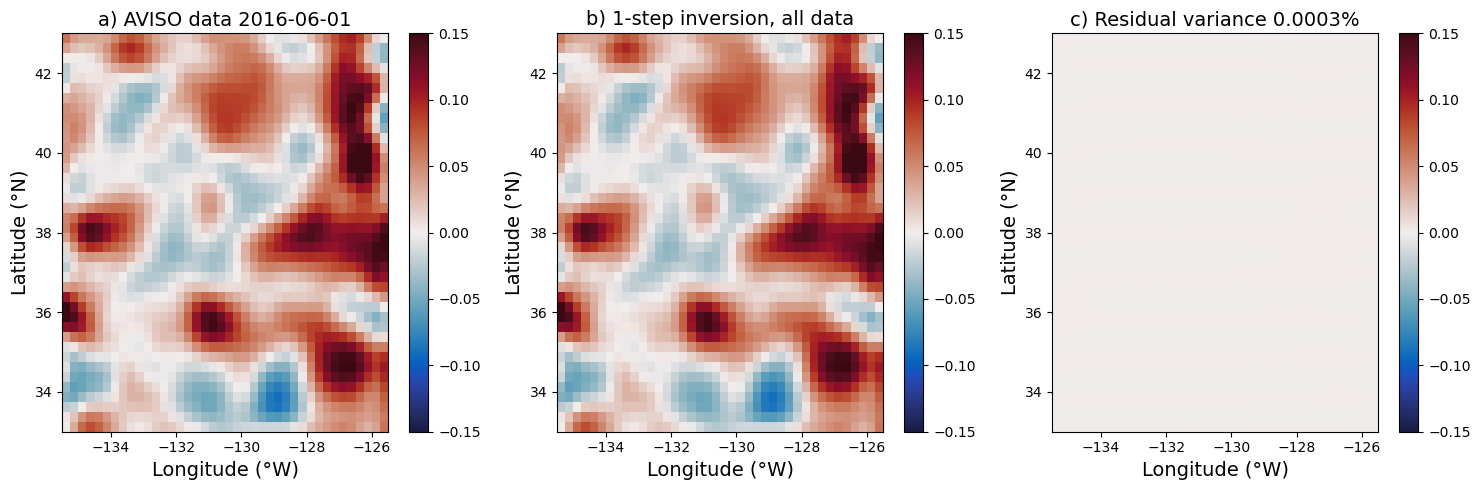

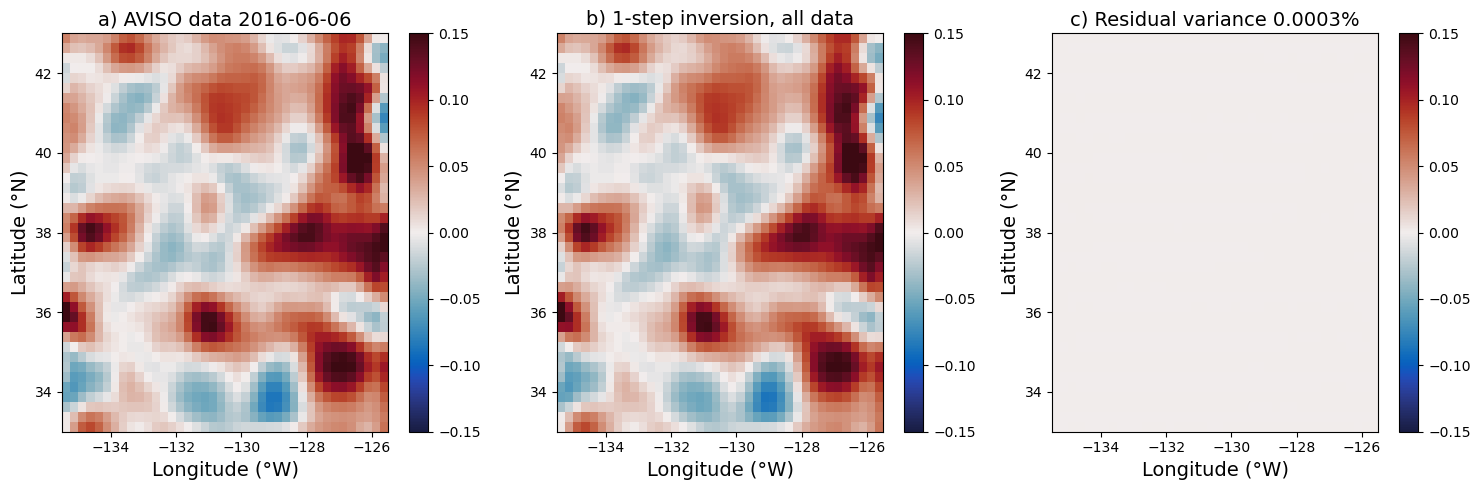

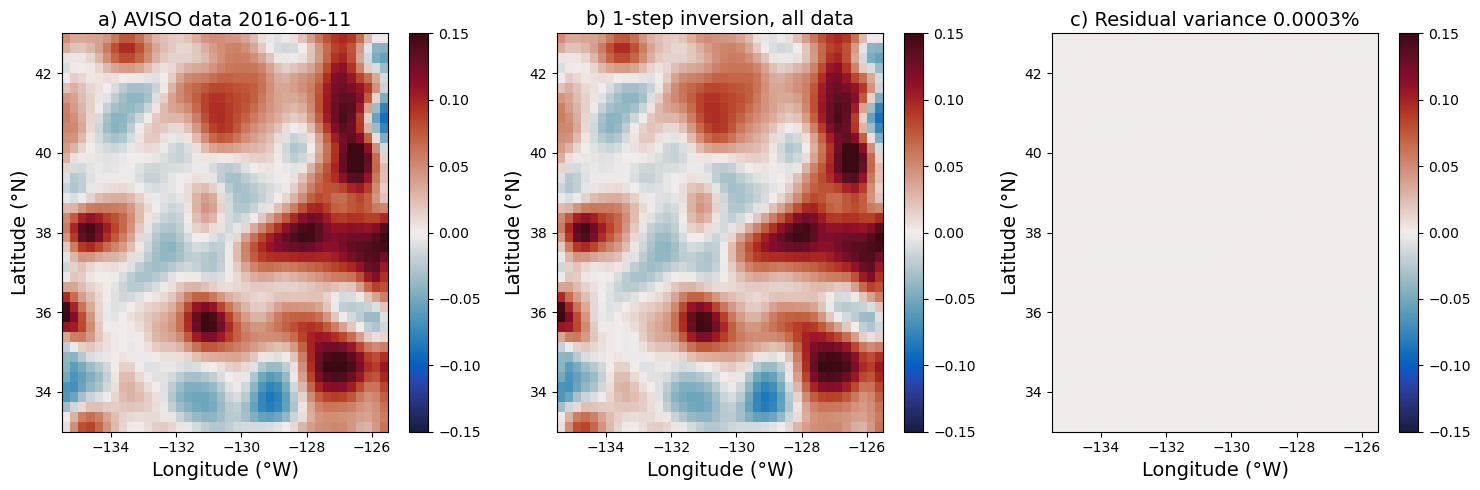

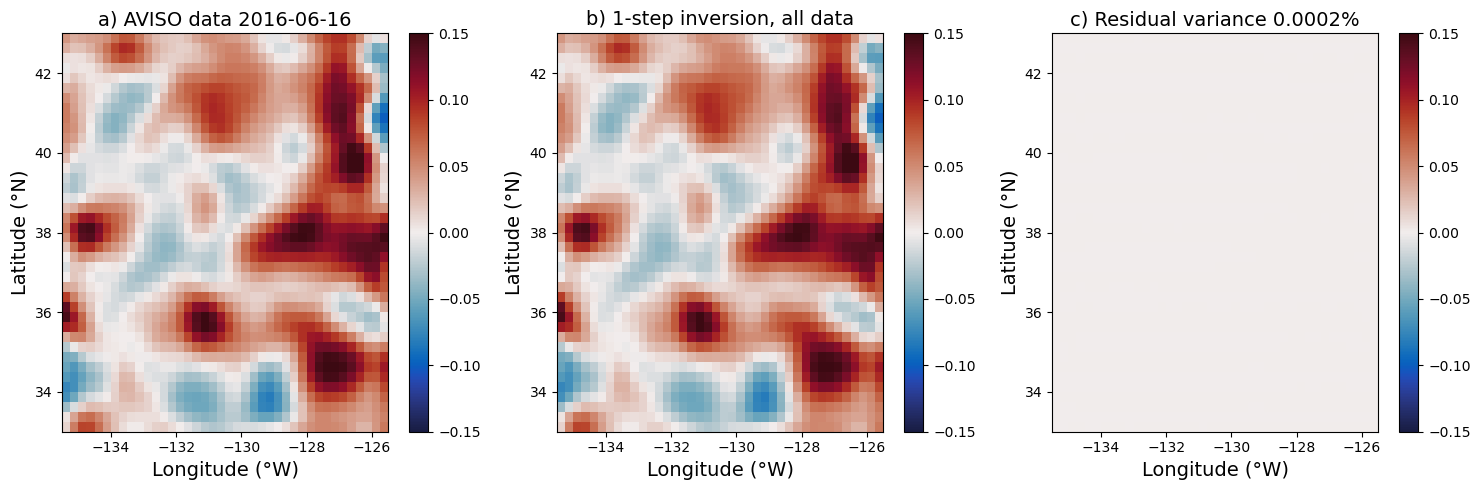

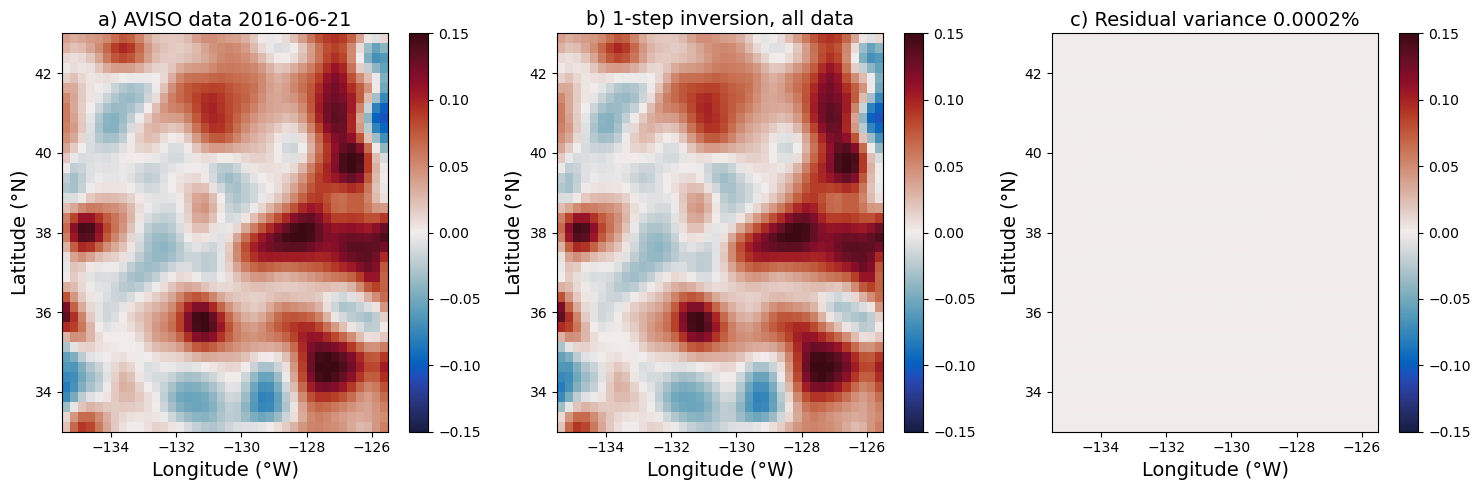

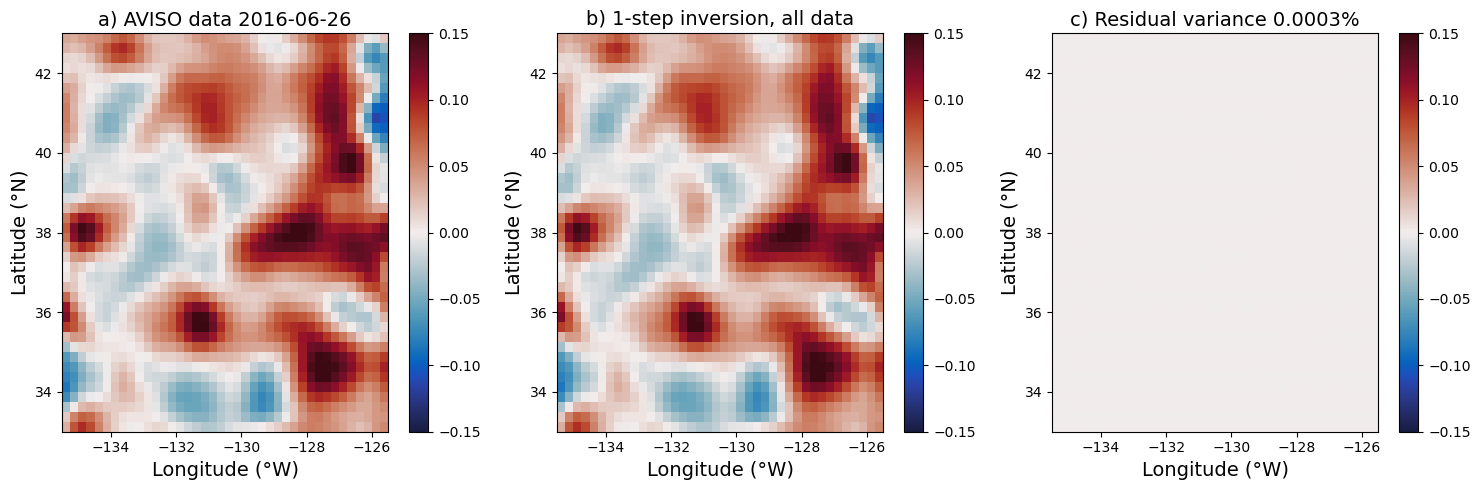

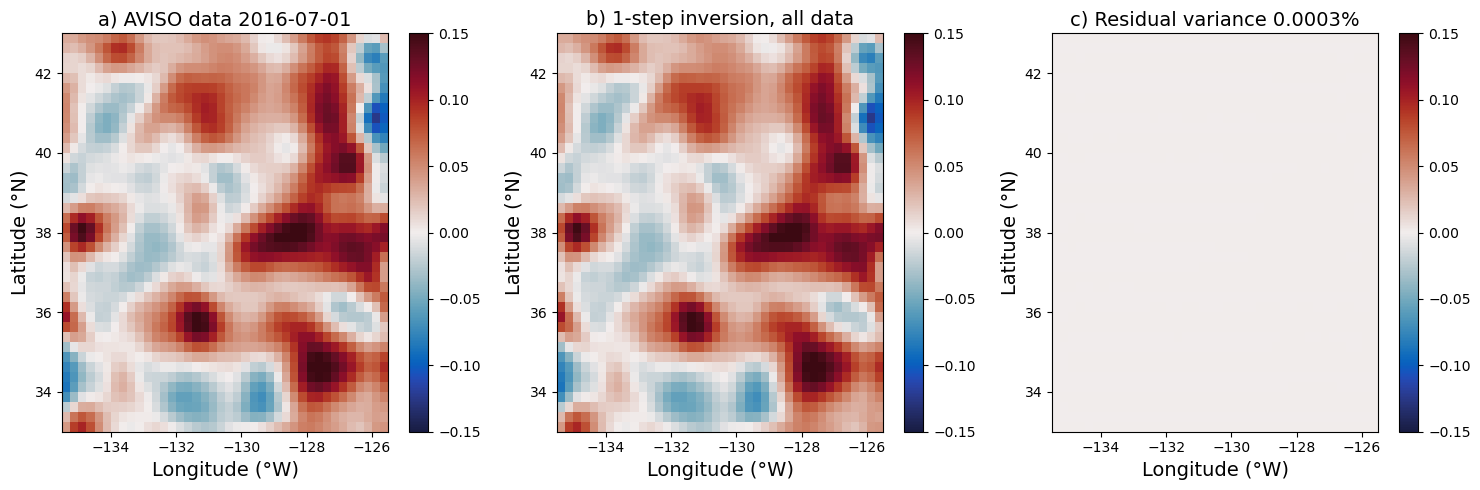

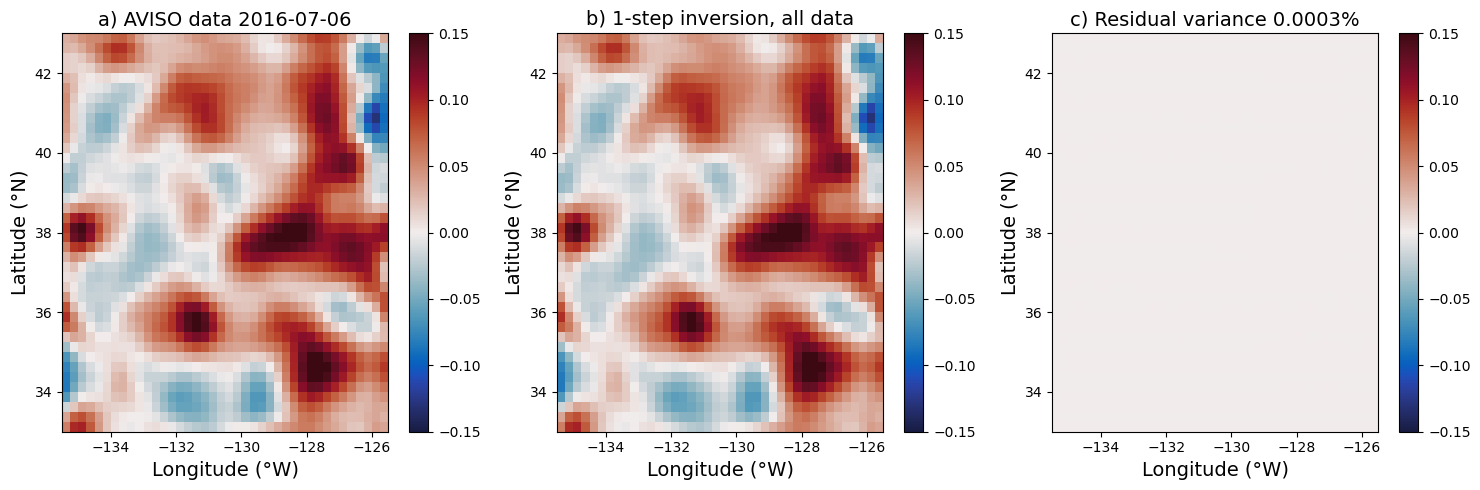

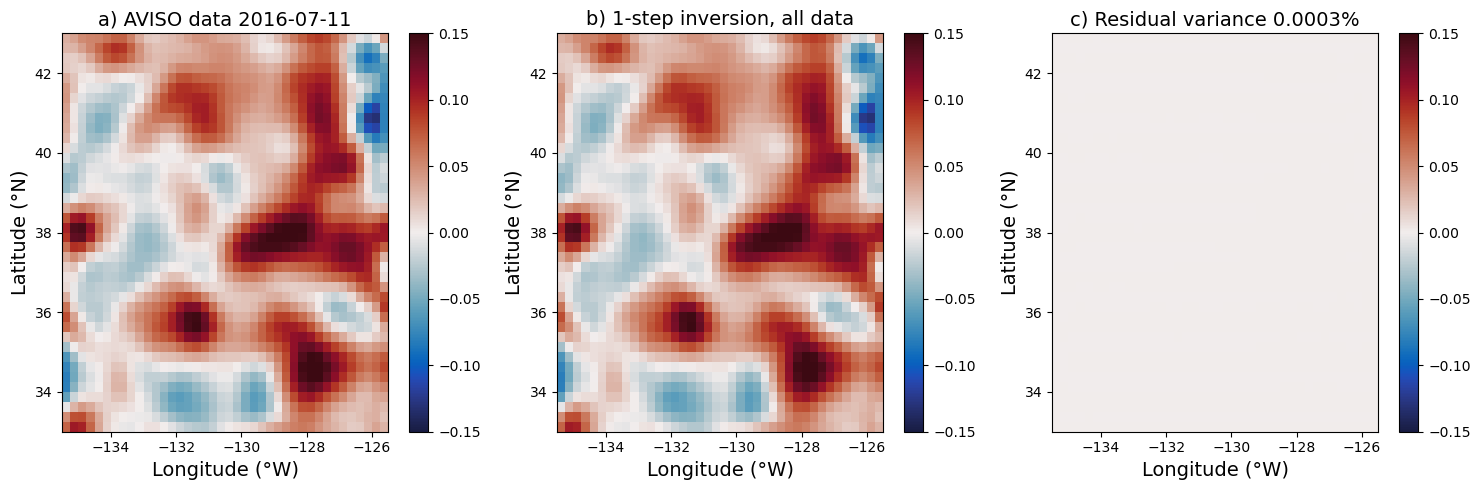

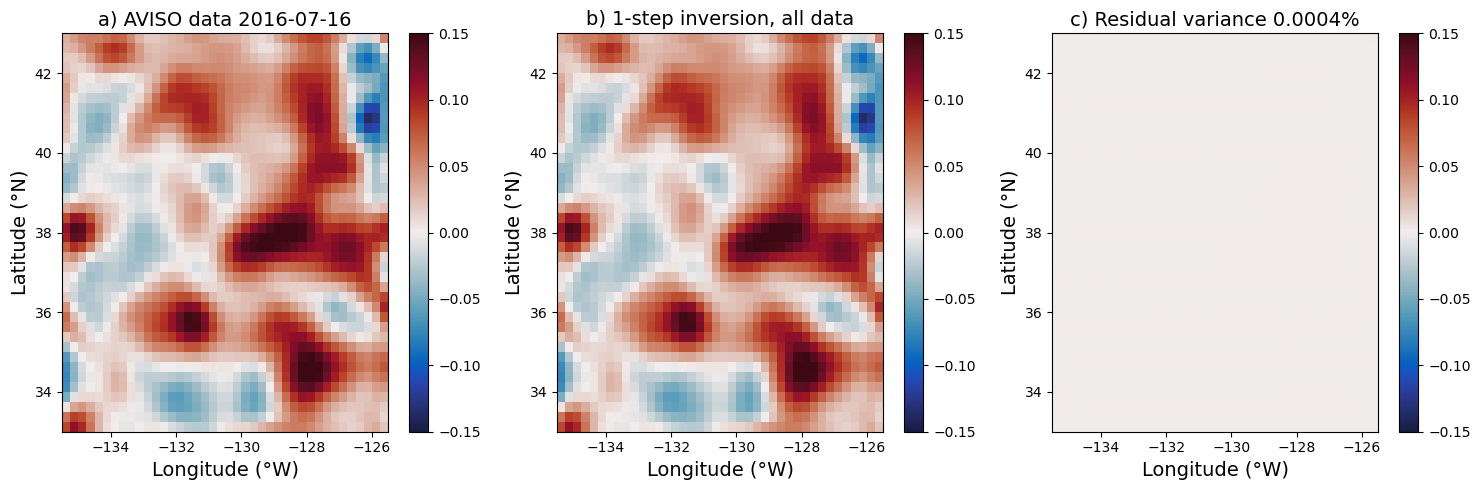

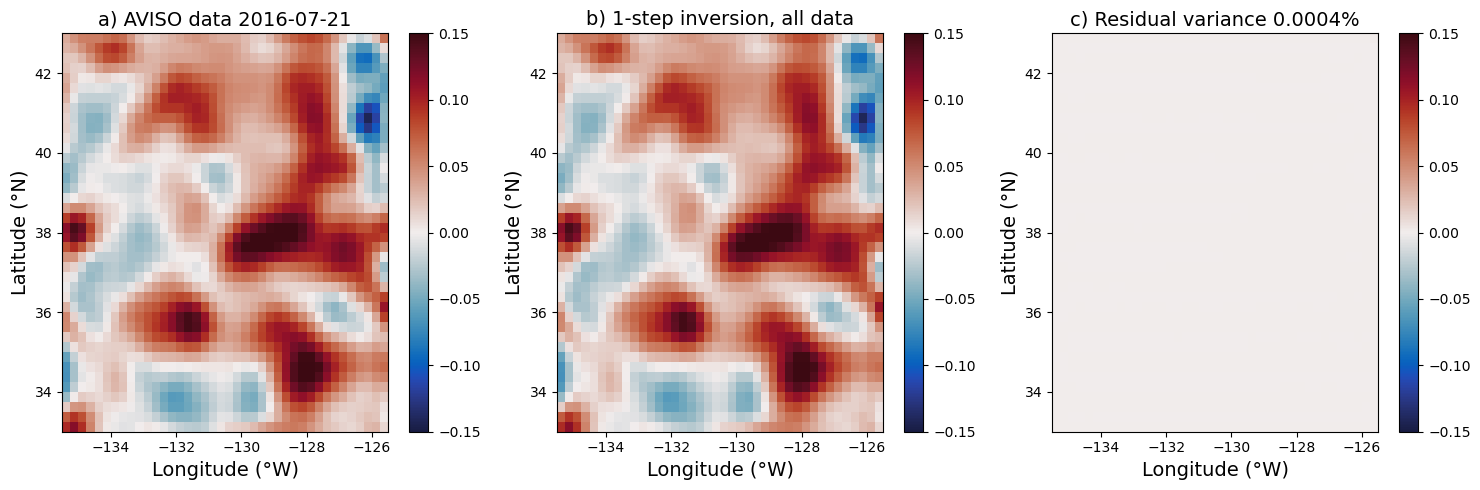

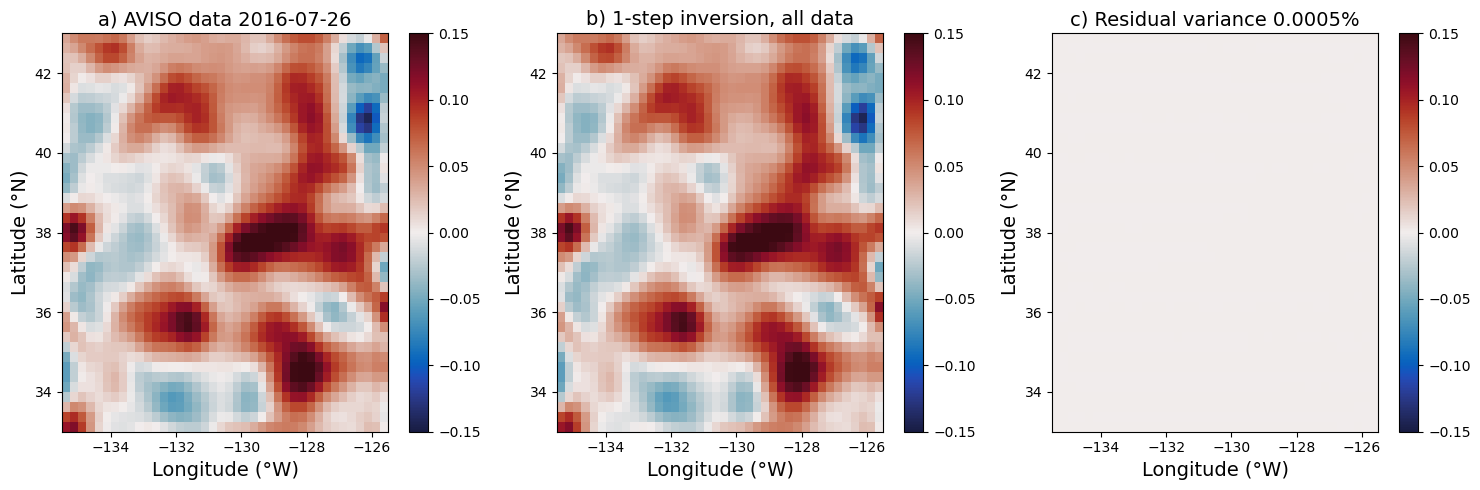

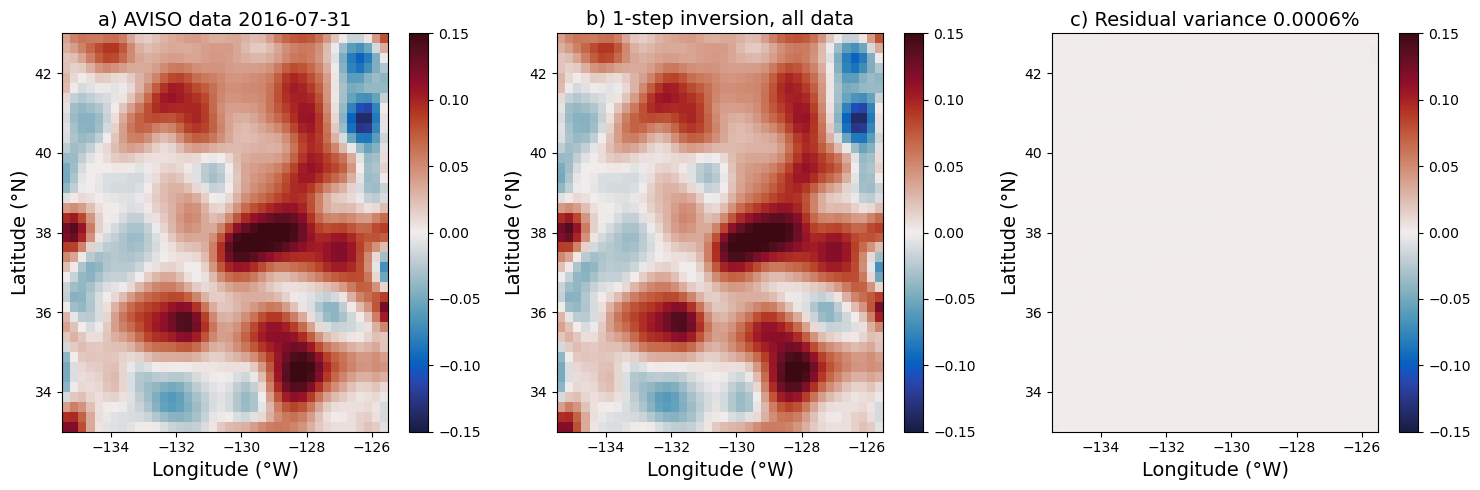

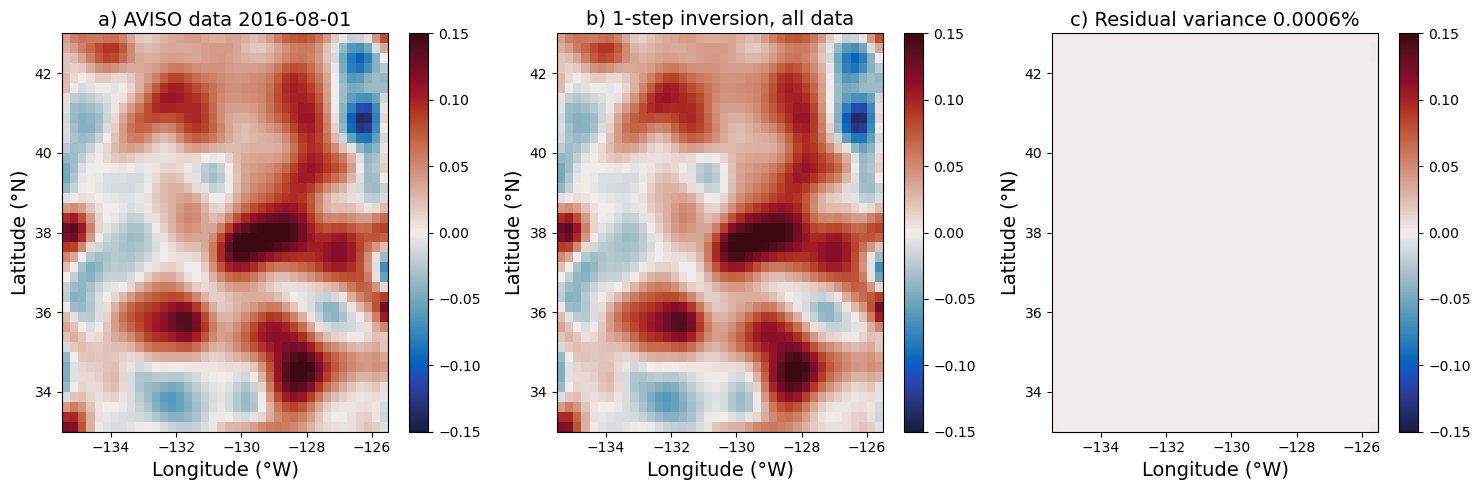

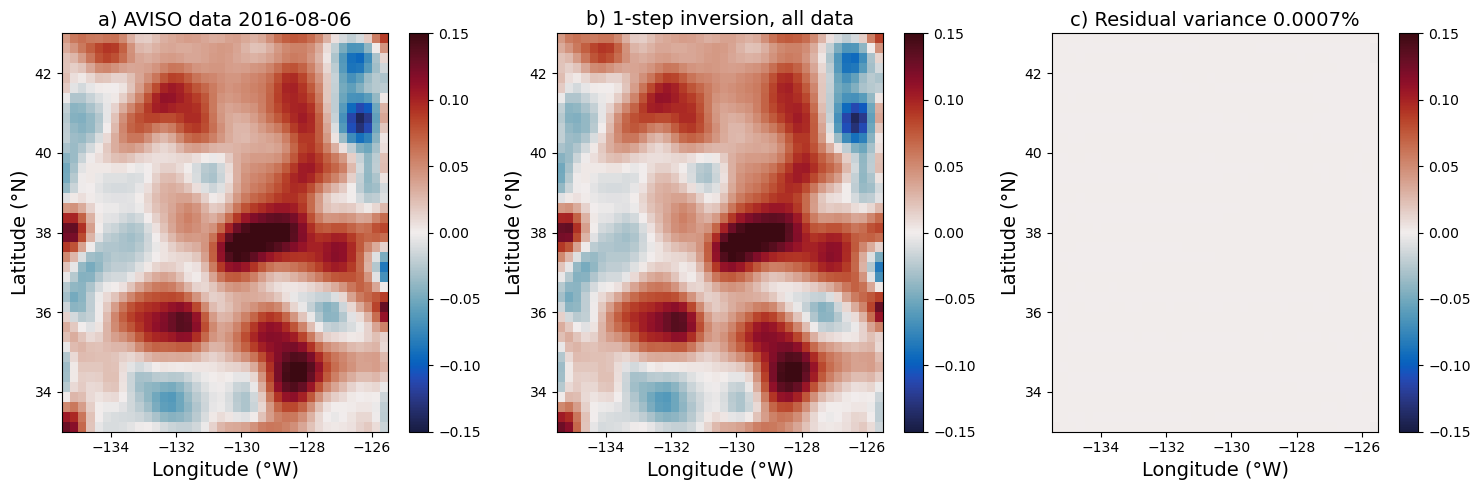

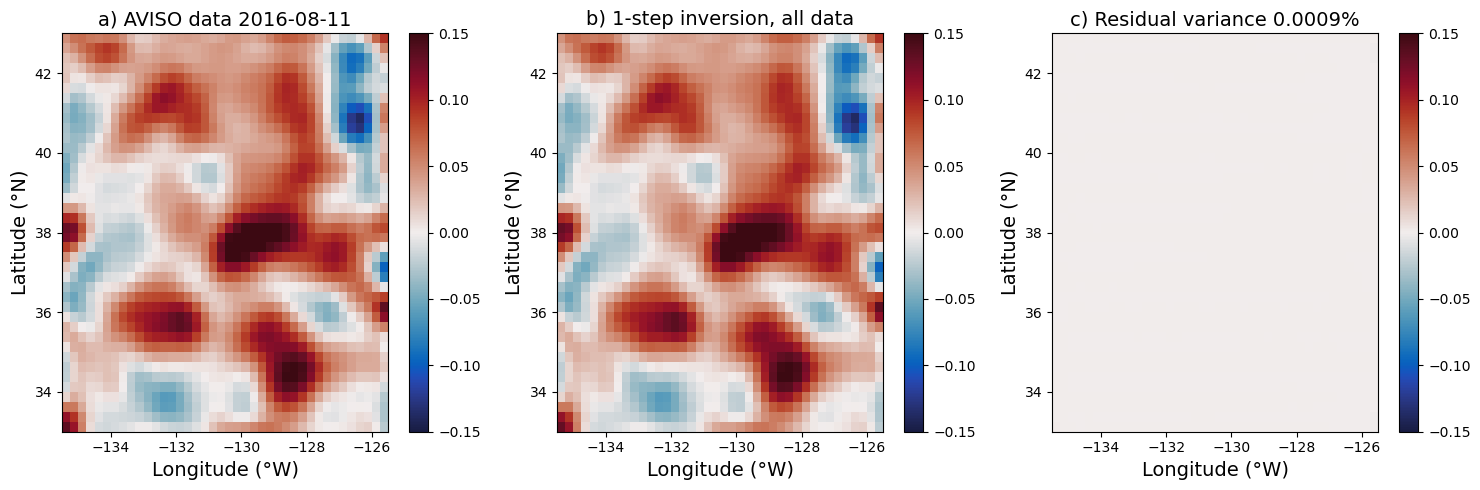

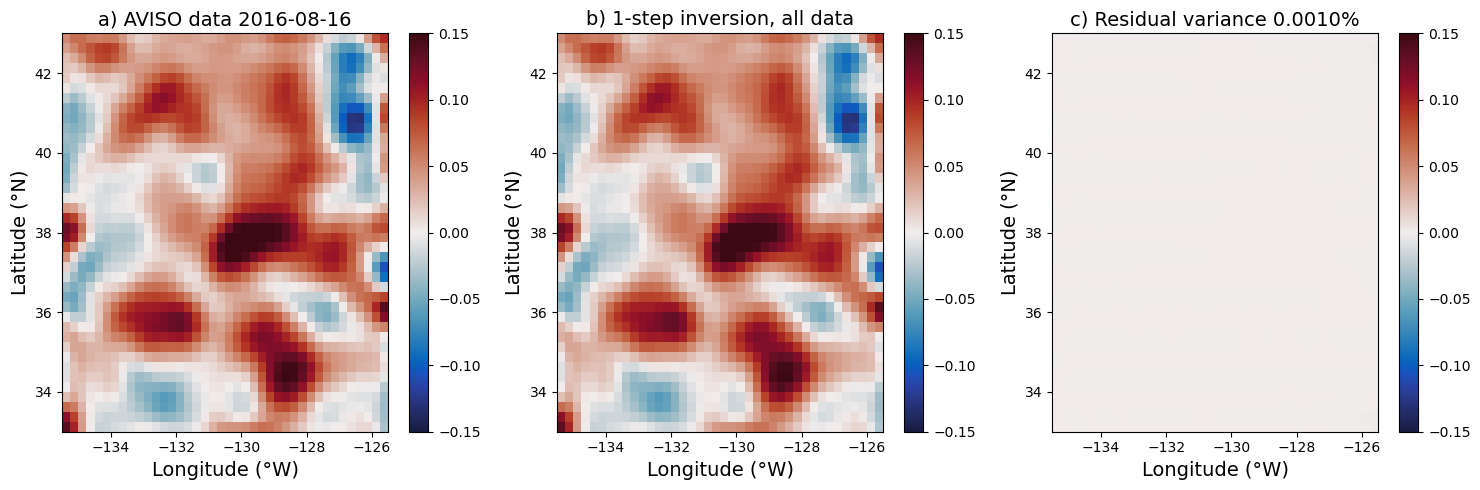

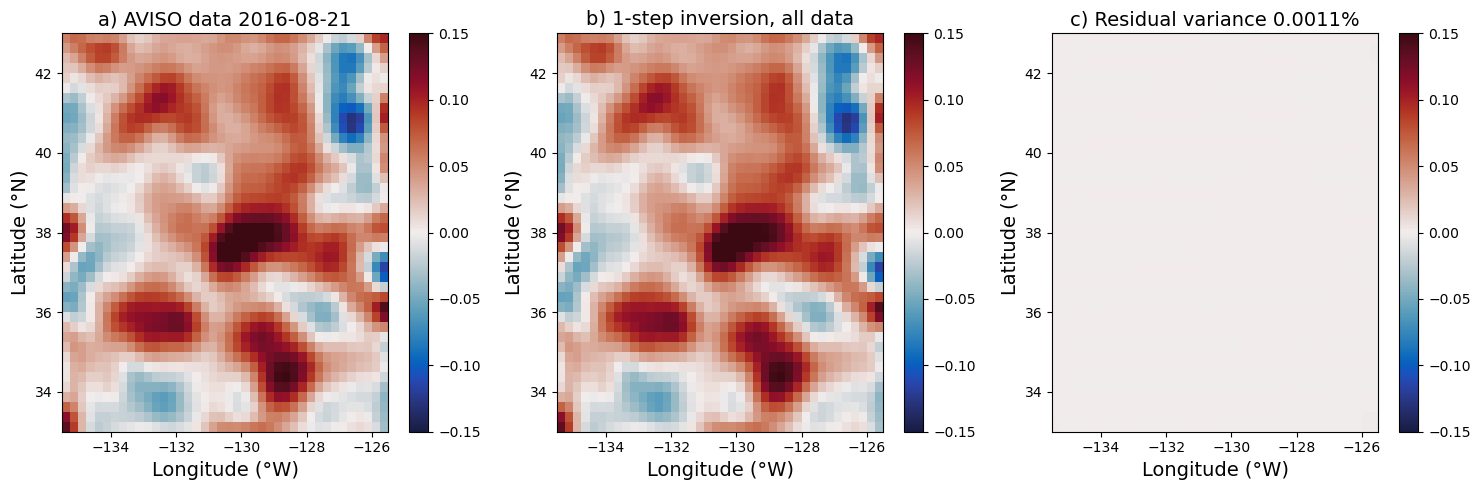

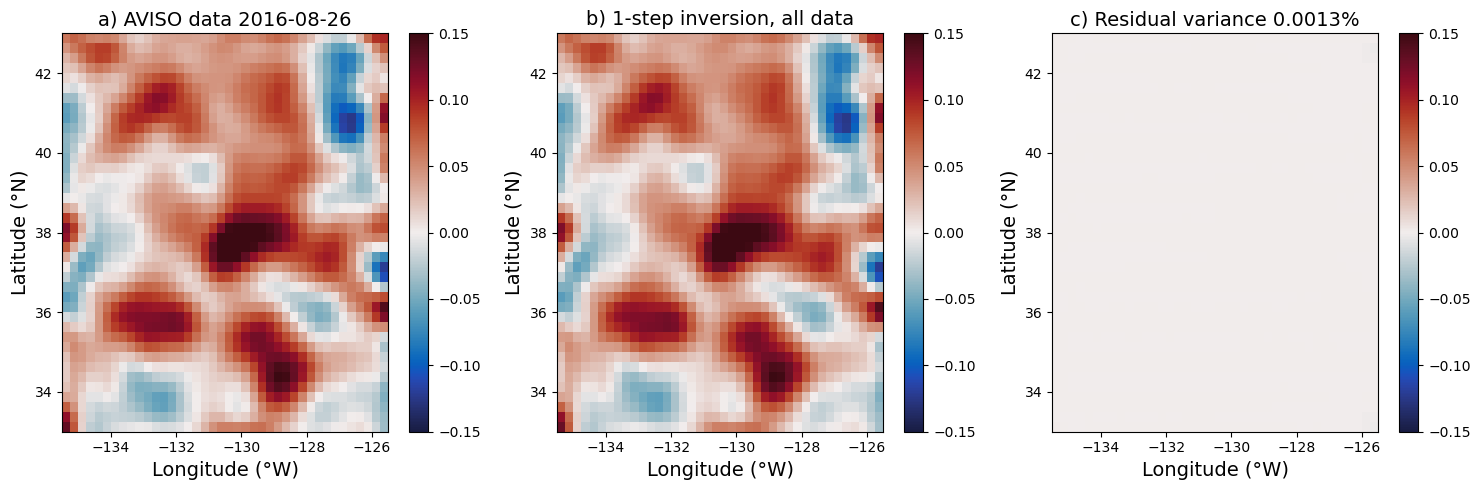

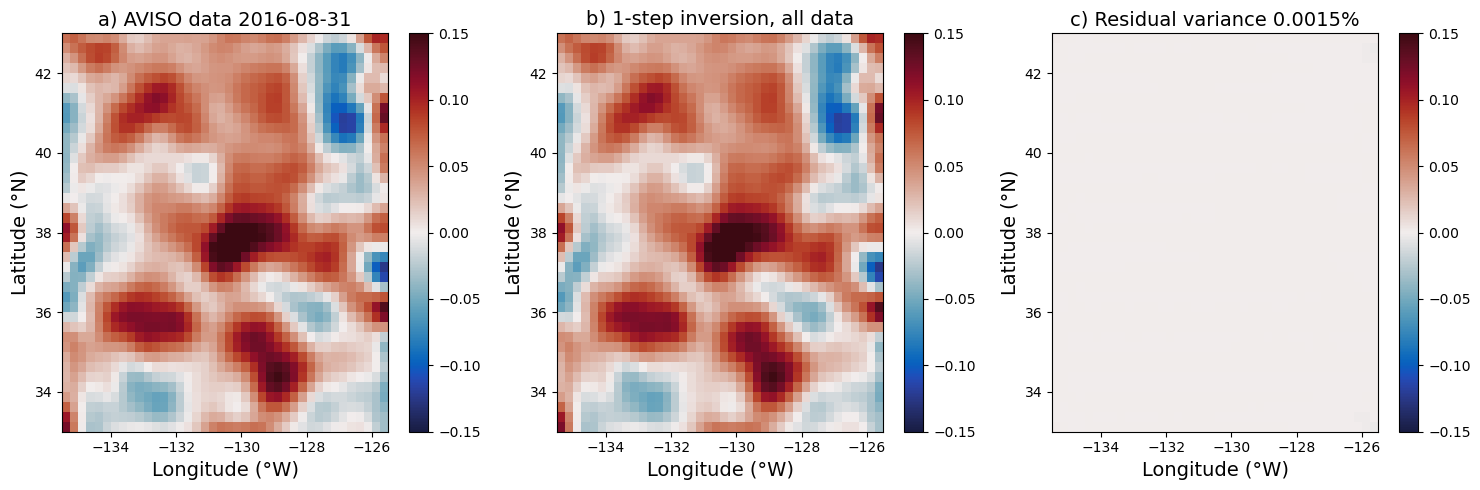

In [36]:
SSHA_predicted = np.zeros([time_range, MSLA0[:, :, 0:1].size])
SSHA_true = np.zeros([time_range, MSLA0[:, :, 0:1].size])
residual_variance = np.zeros(time_range)
MSLA_inverse = np.zeros([MSLA0.shape[0], MSLA0.shape[1], time_range])
for day in range(time_range):
    MSLA = MSLA_fwd[:, :, day:day+1]
    H_all = build_h_matrix(MSLA, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, day0 - day0 + day)
    SSHA_predicted[day], SSHA_true[day], residual_variance[day] = forecast_ssh(MSLA, amp_all_data, H_all)
    MSLA_inverse[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])
    
    plt.figure(figsize = (15, 5))

    plt.subplot(131)
    plt.pcolormesh(lon, lat, MSLA[:, :, 0], cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('a) AVISO data ' + str(date_time[day])[:10], fontsize = 14)

    plt.subplot(132)
    plt.pcolormesh(lon, lat, MSLA_inverse[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('b) 1-step inversion, all data', fontsize = 14)

    residual =  MSLA[:, :, 0] - MSLA_inverse[:, :, day] 
    plt.subplot(133)
    plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('c) Residual variance ' + str((residual_variance[day]) * 100)[:6] + '%', fontsize = 14)

    plt.tight_layout()
    #plt.close()
    plt.savefig('./inversion/inversion_' + str(date_time[day])[:10] +'_all_data_' + str(skill.size) + 'waves_1step.png', dpi = 100)

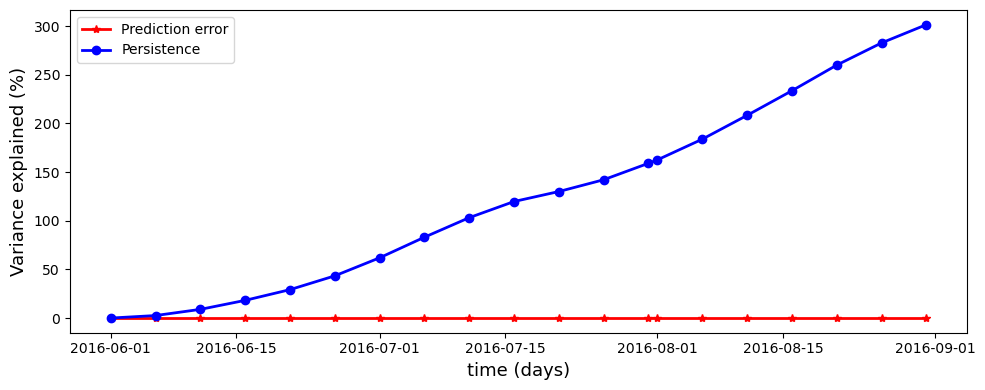

In [37]:
# perfect data are predicted perfectly with a perfect model.....
persistence = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day0:day0+1]
prediction_err = MSLA_inverse[:, :, :time_range] - MSLA_fwd[:, :, :time_range]
var_persistence = np.zeros(persistence.shape[-1])
var_prediction_err = np.zeros(prediction_err.shape[-1])
for t in range(persistence.shape[-1]):
    var_persistence[t] = (np.mean(persistence[:, :, t] ** 2)) / (np.mean(SSHA[:, :, 0:1].data ** 2))
    var_prediction_err[t] = (np.mean(prediction_err[:, :, t] ** 2)) / (np.mean(SSHA[:, :, t].data ** 2))

plt.figure(figsize = (10,4))
plt.plot(time[:time_range][:],  var_prediction_err[:time_range][:] * 100,  
         '-*',linewidth = 2, color = 'r', label = 'Prediction error')
plt.plot(time[:time_range][:],  var_persistence[:time_range][:] * 100,  
         '-o',linewidth = 2, color = 'b', label = 'Persistence')
plt.ylabel('Variance explained (%)', fontsize = 13)
plt.xlabel('time (days)', fontsize = 13)
plt.legend()
plt.tight_layout()
plt.savefig('./prediction_vs_persistence/all_data_prediction_err_' + str(M) + '_waves.png', dpi = 300)

In [38]:
# persistence = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day0:day0+1]
# #persistence = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day1:day1+1]
# prediction_err = MSLA_inverse[:, :, :time_range] - MSLA_fwd[:, :, :time_range]
# rms_persistence = np.zeros(persistence.shape[-1])
# rms_prediction_err = np.zeros(prediction_err.shape[-1])
# for t in range(persistence.shape[-1]):
#     rms_persistence[t] = np.sqrt(np.mean(persistence[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, 0:1].data ** 2))
#     rms_prediction_err[t] = np.sqrt(np.mean(prediction_err[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, t].data ** 2))

# plt.figure(figsize = (10,4))
# plt.plot(time[:time_range][0::2],  rms_prediction_err[:time_range][0::2] * 100,  
#          '-*',linewidth = 2, color = 'r', label = 'Prediction error')
# plt.plot(time[:time_range][0::2], rms_persistence[:time_range][0::2] * 100,  
#          '-x', linewidth = 2, color = 'k', label = 'Persistence' )
# #plt.plot(T_time[:time_range][0::2]/86400, np.repeat(100, len(time)),linestyle = '--',  color = 'y')
# #plt.xticks(time[:time_range][0::2]/86400, time[:time_range][0::2] - time[0])
# plt.ylabel('Percentage (%)', fontsize = 13)
# plt.xlabel('time (days)', fontsize = 13)
# plt.legend()
# plt.tight_layout()
# plt.savefig('./prediction_vs_persistence/all_data_prediction_err_vs_persistence_' + str(M) + '_waves.png', dpi = 300)

In [39]:
# def build_swath_test(swath_width, x_width, day, lon, lat):
    
#     '''
#      Generate the x, y, t indices for multiple satellite passings over a given swath width and time period. 
    
#     '''
    
#     import numpy as np
    
#     print(x_width)
#     x_width = len(lon)
#     print(x_width)
    
#     # swath 1

#     xswath_index0 = np.arange(0, x_width , 1) 
#     print(xswath_index0)
#     yswath_index0 = np.arange(0, swath_width, 1)
#     print(yswath_index0)
#     yswath_index_left = np.ma.masked_all([x_width, swath_width])
#     xswath_index_left = np.ma.masked_all([x_width, swath_width])
#     for yy in range(swath_width):
#         xswath_index_left[:, yy] = xswath_index0
        
#     for xx in range(x_width):
#         yswath_index_left[xx] = yswath_index0 + xx
        
#     yswath_index_left = np.ma.masked_outside(yswath_index_left, 0, len(lat) - 1)
#     xswath_index_left = np.ma.masked_outside(xswath_index_left, 0, len(lon) - 1)
#     y_mask_left = np.ma.getmask(yswath_index_left)
#     x_mask_left  = np.ma.getmask(xswath_index_left)
#     mask_left = np.ma.mask_or(y_mask_left,x_mask_left)
#     print(xswath_index_left[len(lon)-5:len(lon),:], yswath_index_left[len(lon)-5:len(lon),:])
#     #print(xswath_index_left[0:5,:])
#     #print(yswath_index_left[0:5,:])
#     xswath_index_left = np.ma.MaskedArray(xswath_index_left, mask_left)
#     yswath_index_left = np.ma.MaskedArray(yswath_index_left, mask_left)
#     print(xswath_index_left[len(lon)-5:len(lon),:], yswath_index_left[len(lon)-5:len(lon),:])
#     #print(xswath_index_left[0:5,:]) 
#     #print(yswath_index_left[0:5,:])
    
#     # swath 2

#     xswath_index1 = np.arange(len(lon) - x_width, len(lon))
#     yswath_index1 = np.arange(len(lat) - swath_width, len(lat))
#     yswath_index_right = np.ma.masked_all([x_width, swath_width])
#     xswath_index_right = np.ma.masked_all([x_width, swath_width])

#     for yy in range(swath_width):
#         xswath_index_right[:, yy] = xswath_index1
        
#     for xx in range(x_width):    
#         yswath_index_right[xx] = yswath_index1 - xx  
        
#     yswath_index_right = np.ma.masked_outside(yswath_index_right, 0, len(lat) - 1)
#     xswath_index_right = np.ma.masked_outside(xswath_index_right, 0, len(lon) - 1)
#     y_mask_right = np.ma.getmask(yswath_index_right)
#     x_mask_right = np.ma.getmask(xswath_index_right)
#     xswath_index_right = np.ma.MaskedArray(xswath_index_right, x_mask_right)
#     yswath_index_right = np.ma.MaskedArray(yswath_index_right, y_mask_right)

#     yvalid_index = np.append(yswath_index_left.compressed().astype(int), yswath_index_right.compressed().astype(int)) 
#     xvalid_index = np.append(xswath_index_left.compressed().astype(int), xswath_index_right.compressed().astype(int))
    
#     tindex, xindex, yindex = [], [], []
#     xindex =  np.tile(xvalid_index, len(day))
#     yindex =  np.tile(yvalid_index, len(day))
#     for dd in day:
#         tmp = np.tile(dd, len(yvalid_index))
#         tindex = np.append(tindex, tmp)
    
#     return xindex, yindex, tindex, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right

#### build satellite swath

In [40]:
swath_width, x_width = 6, 20 # swath_width: width of the satellite passing ; x_width: the width of the field
day = np.arange(0, 1) # sample the satellite passing on the first day
#day

In [41]:
# xvalid_index, yvalid_index, tindex, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right = build_swath_test(swath_width, x_width, day, lon, lat)

In [42]:
xvalid_index, yvalid_index, tindex, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right = build_swath(swath_width, x_width, day, lon, lat)

In [43]:
#xvalid_index[0:10]

In [44]:
#xvalid_index.shape, yvalid_index.shape, tindex.shape

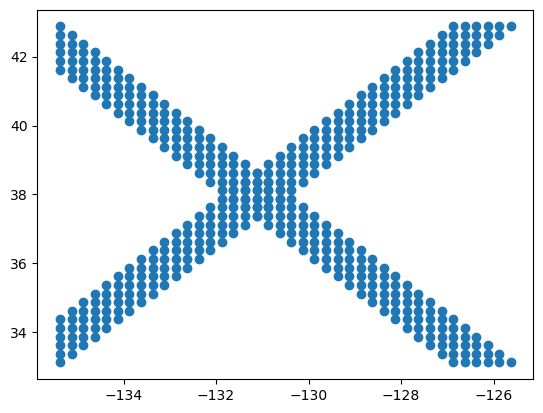

In [45]:
plt.scatter(lon[xvalid_index],lat[yvalid_index])
#plt.scatter(5,10)

In [46]:
# for i in range(10):
#     kk=-1
#     ll=-1
#     mm=0
#     nn=-1
#     count=xvalid_index[i]+yvalid_index[i]*len(lon)
#     omega_test =   (Beta * k_n[kk, mm]) / (k_n[kk, mm] ** 2 + l_n[ll, mm] ** 2 + Rm ** -2)
#     H_cos_test = Psi[0, mm] * np.cos(k_n[kk, mm] * dlon[int(Iindex[count])] + l_n[ll, mm] * dlat[int(Jindex[count])] + omega[kk, ll, mm] * T_time[int(Tindex[count])]) 
#     H_sin_test = Psi[0, mm] * np.sin(k_n[kk, mm] * dlon[int(Iindex[count])] + l_n[ll, mm] * dlat[int(Jindex[count])] + omega[kk, ll, mm] * T_time[int(Tindex[count])])
#     print([i,H_cos_test,H_sin_test,xvalid_index[i],yvalid_index[i],H_cos[count,nn],H_sin[count,nn]])
#     print([[int(Iindex[count])],lon[xvalid_index[i]],lat[yvalid_index[i]]])
#     print([dlon[int(Iindex[count])], dlat[int(Jindex[count])]])


In [47]:
mask=np.zeros([MSLA_fwd.shape[0],MSLA_fwd.shape[1]])

In [48]:
# Build an H_swath matrix for a single snapshot; 
#  this is nearly underdetermined but should produce a perfect fit within the swaths
N = len(xvalid_index) # number of data
MSLA_swath = np.zeros(len(xvalid_index))
mask=np.zeros([MSLA_fwd.shape[0],MSLA_fwd.shape[1]])
M = l_n.size * k_n.size
nx, ny = len(lon), len(lat)
H_swath = np.zeros([N, 2 * M]) # M: number of model
IIndex = np.zeros(N) # N: Number of y data
cor_err = np.zeros(N) # Correlated Error N: Number of y data
MSLA_swath = np.zeros(N)
ssh = np.zeros(N)
for ii in range(len(xvalid_index)):
    IIndex[ii] = nx * yvalid_index[ii] + xvalid_index[ii]
    #IIndex[ii] = ny * xvalid_index[ii] + yvalid_index[ii]
    ssh[ii] = MSLA_fwd[yvalid_index[ii], xvalid_index[ii], int(tindex[ii])]
    mask[yvalid_index[ii], xvalid_index[ii]]=1
    MSLA_swath[ii] = ssh[ii]  #+ cor_err[ii] 
    for nn in range(M):
        JIndex = 2 * MModes * nn # Model space
        H_swath[ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
        H_swath[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]

In [49]:
MSLA_swath.shape, H_swath.shape, H_cos.shape, mask.shape

((450,), (450, 380), (16000, 190), (40, 40))

In [50]:
#plt.pcolormesh(lon,lat,mask)

#### Solve for amplitudes

In [51]:
amp_swath, ssh_estimated_swath = inversion(MSLA_swath, H_swath, P_over_R)

#### Reverse the vectorization on the swaths

In [52]:
ssh_true = np.zeros([len(lat), len(lon)])
ssh_map = np.zeros([len(lat), len(lon)])
for ii, idx in enumerate(xvalid_index):
    ssh_map[yvalid_index[ii], xvalid_index[ii]]  = ssh_estimated_swath[ii]
    ssh_true[yvalid_index[ii], xvalid_index[ii]] = MSLA_swath[ii]

In [53]:
ssh_diff = (np.mean((ssh_true - ssh_map) ** 2 ))/ (np.mean((ssh_true) ** 2 ))

In [54]:
xvalid_index.shape, ssh_diff

((450,), 0.0010507622186550682)

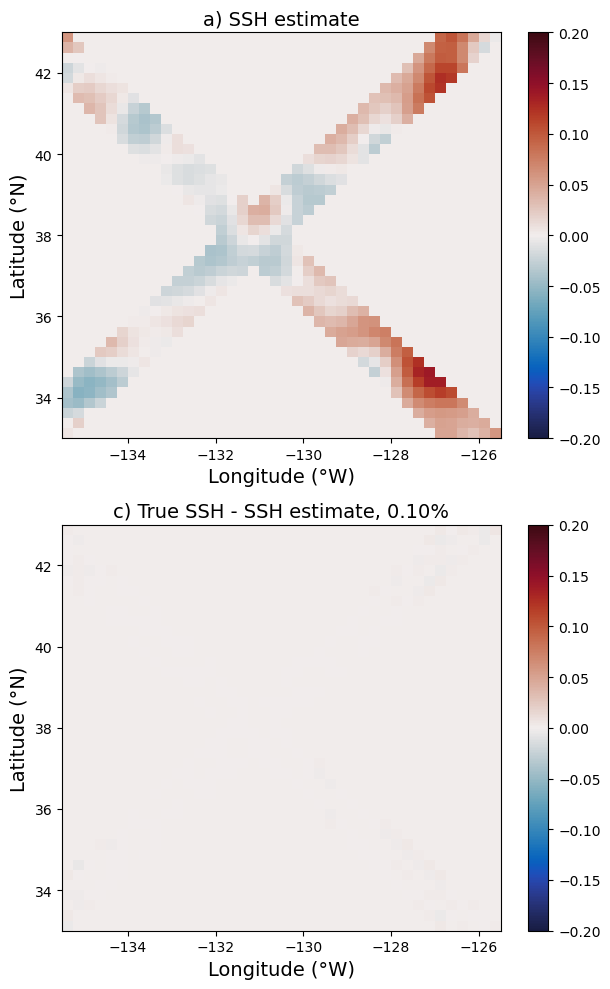

In [55]:
fig = plt.figure(figsize = (12, 10))

plt.subplot(221)
plt.pcolormesh(lon, lat, ssh_map, vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('a) SSH estimate', fontsize = 14)

plt.subplot(223)
plt.pcolormesh(lon, lat, ssh_true - ssh_map, cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('c) True SSH - SSH estimate, ' + str(ssh_diff * 100)[:4] + '%', fontsize = 14)

plt.tight_layout()
plt.savefig('aviso_ssh_estimate_'+str(time[day])[:10] + '_no_error.png')

In [56]:
H_swath1=H_swath

In [57]:
[day0, day1]

[0, 10]

In [58]:
# Build an H_swath matrix for a series of snapshots

N = len(xvalid_index) # number of data
Ndata=N*int(day1-day0)
MSLA_swath = np.zeros(len(xvalid_index))
M = l_n.size * k_n.size
nx, ny = len(lon), len(lat)
H_swath = np.zeros([Ndata, 2 * M]) # M: number of model
IIndex = np.zeros(Ndata) # N: Number of y data
cor_err = np.zeros(Ndata) # Correlated Error N: Number of y data
MSLA_swath = np.zeros(Ndata)
ssh = np.zeros(Ndata)
for tt in range(day1-day0):
    for ii in range(N):
        #IIndex[tt*N+ii] = nx * yvalid_index[ii] + xvalid_index[ii]
        index=nx * yvalid_index[ii] + xvalid_index[ii] + tt*nx*ny
        #IIndex[ii] = ny * xvalid_index[ii] + yvalid_index[ii]
        ssh[tt*N+ii] = MSLA_fwd[yvalid_index[ii], xvalid_index[ii], int(tindex[ii])+tt]
        MSLA_swath[tt*N+ii] = ssh[tt*N+ii]  #+ cor_err[ii] 
        #H_swath[tt*N+ii,:]=H_all1[IIndex[tt*N+ii].astype(int),:]
        H_swath[tt*N+ii,:]=H_all1[int(index),:]

In [59]:
#indices = nx* yvalid_index + xvalid_index


In [60]:
amp_swath1, ssh_estimated_swath1 = inversion(MSLA_swath[0:450], H_swath[0:450,:], P_over_R)

In [61]:
amp_swath1a, ssh_estimated_swath1a = inversion(MSLA_swath[0:450], H_swath1, P_over_R)

In [62]:
amp_swath10, ssh_estimated_swath10 = inversion(MSLA_swath, H_swath, P_over_R)

In [63]:
forecast_swath = np.matmul(H_swath, amp_swath10)
forecast_total = np.matmul(H_all1, amp_swath10)
forecast_correct = np.matmul(H_all1, amp_all_data)

In [64]:
forecast_total.shape, H_all1.shape, np.reshape(forecast_total,[10,len(lat),len(lon)]).transpose(1,2,0).shape

((16000,), (16000, 380), (40, 40, 10))

In [65]:
ssh_true10 = np.zeros([len(lat), len(lon),10])
ssh_map10 = np.zeros([len(lat), len(lon),10])
ssh_forecast10 = np.zeros([len(lat), len(lon),10])
ssh_forecast_total = np.zeros([len(lat), len(lon),10])
ssh_forecast_correct = np.zeros([len(lat), len(lon),10])
#ssh_forecast_total = np.reshape(forecast_total.reshape,[10, len(lat), len(lon)]).transport(1,2,0)
ssh_forecast_total = np.reshape(forecast_total,[10, len(lat), len(lon)]).transpose(1,2,0)
ssh_forecast_correct = np.reshape(forecast_correct,[10, len(lat), len(lon)]).transpose(1,2,0)
for tt in range(day1-day0):
    for ii, idx in enumerate(xvalid_index):
        ssh_map10[yvalid_index[ii], xvalid_index[ii],tt]  = ssh_estimated_swath10[ii+tt*N]
        ssh_true10[yvalid_index[ii], xvalid_index[ii],tt] = MSLA_swath[ii+tt*N]
        ssh_forecast10[yvalid_index[ii], xvalid_index[ii],tt] = forecast_swath[ii+tt*N]

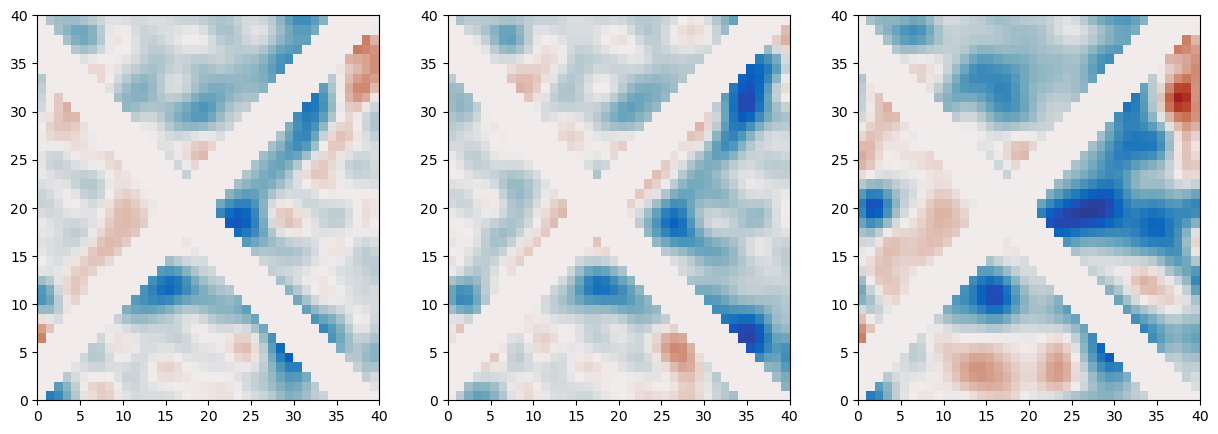

In [66]:
    plt.figure(figsize = (15, 5))

    plt.subplot(131)
    plt.pcolor(ssh_map10[:,:,9]-ssh_forecast_total[:,:,9], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
    
    plt.subplot(132)
    plt.pcolor(ssh_forecast10[:,:,0]-ssh_forecast_total[:,:,0], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
    
    plt.subplot(133)
    plt.pcolor(ssh_true10[:,:,9]-ssh_forecast_correct[:,:,9], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)

In [67]:
variance_on_track=np.zeros(int(day1-day0))
for i in range(int(day1-day0)):
    variance_on_track[i]=np.mean((ssh_estimated_swath10[N*i:N*(i+1)]-MSLA_swath[N*i:N*(i+1)])**2)/np.mean((MSLA_swath[N*i:N*(i+1)])**2)
    #variance_on_track[i]=np.mean((MSLA_swath[N*i:N*(i+1)])**2)

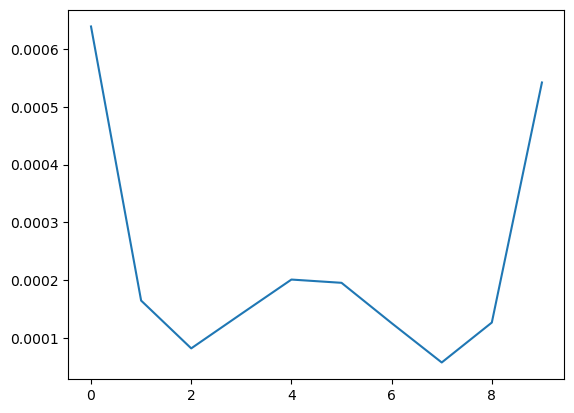

In [68]:
plt.plot(variance_on_track)

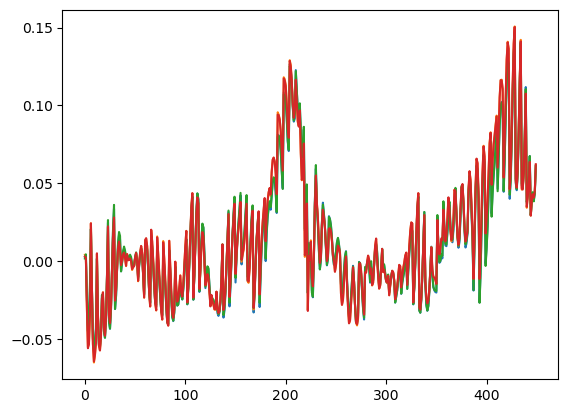

In [69]:
#plt.plot(ssh_estimated_swath1)
#plt.plot(ssh_estimated_swath1a)
plt.plot(ssh_estimated_swath10[0:N])
plt.plot(ssh_estimated_swath10[N:2*N])
plt.plot(ssh[0:N])
plt.plot(ssh[N:2*N])

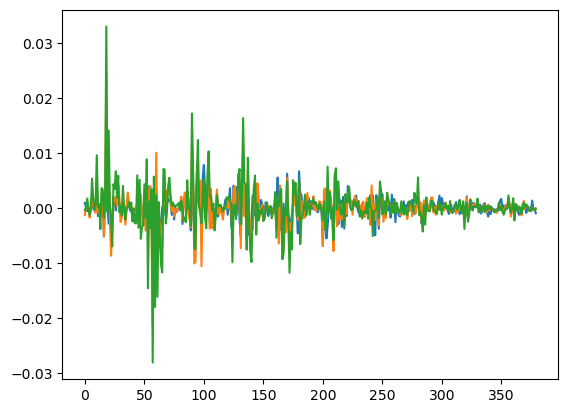

In [70]:
#plt.plot(H_swath[:,20])
#plt.plot(H_swath1[:,20])
plt.plot(range(380),amp_swath1)
#plt.plot(range(380),amp_swath1a)
plt.plot(range(380),amp_swath10)
#plt.plot(range(380),amp_swath10-amp_swath1)
#plt.plot(range(380),amp)
plt.plot(range(380),amp_all_data)

#### Make predictions of SSH based on the estimated amplitudes:
#### Swath data, no errors

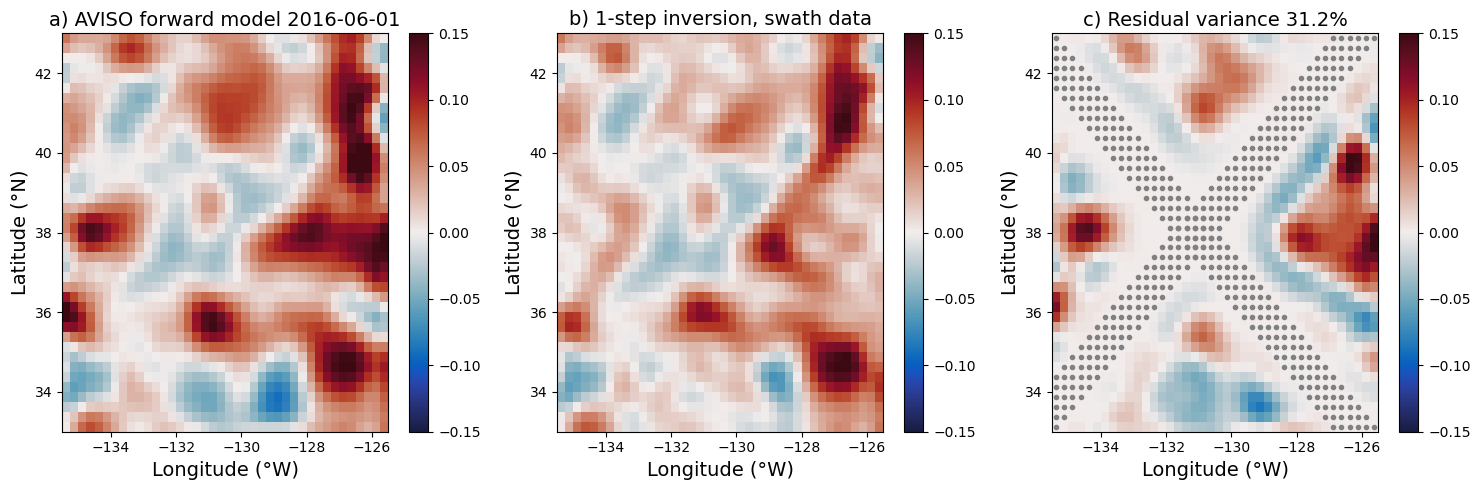

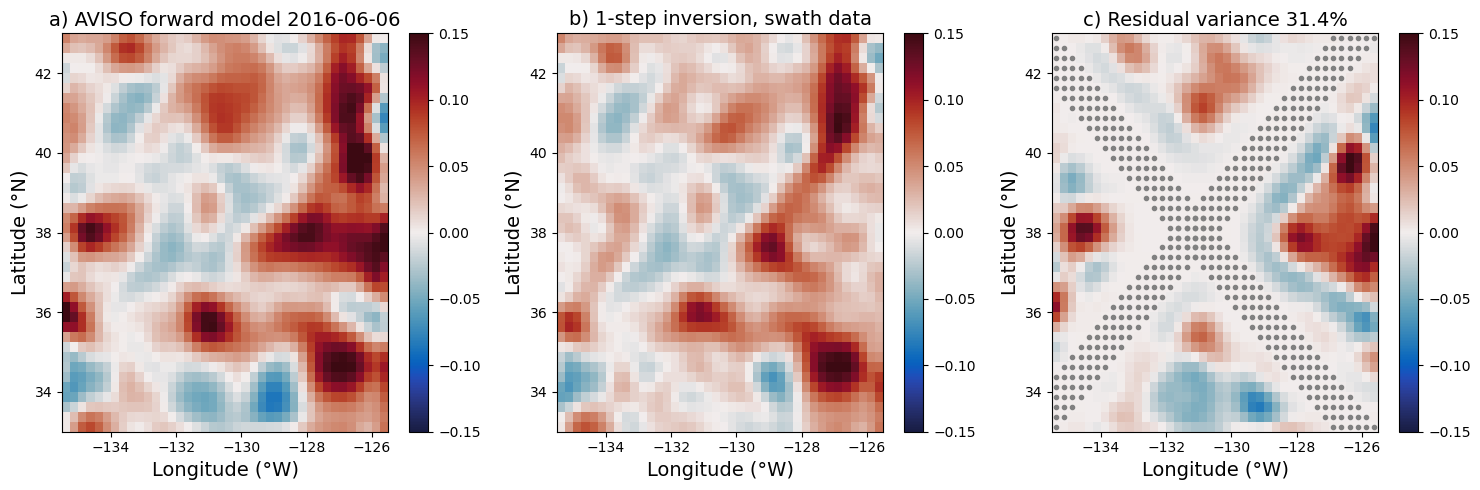

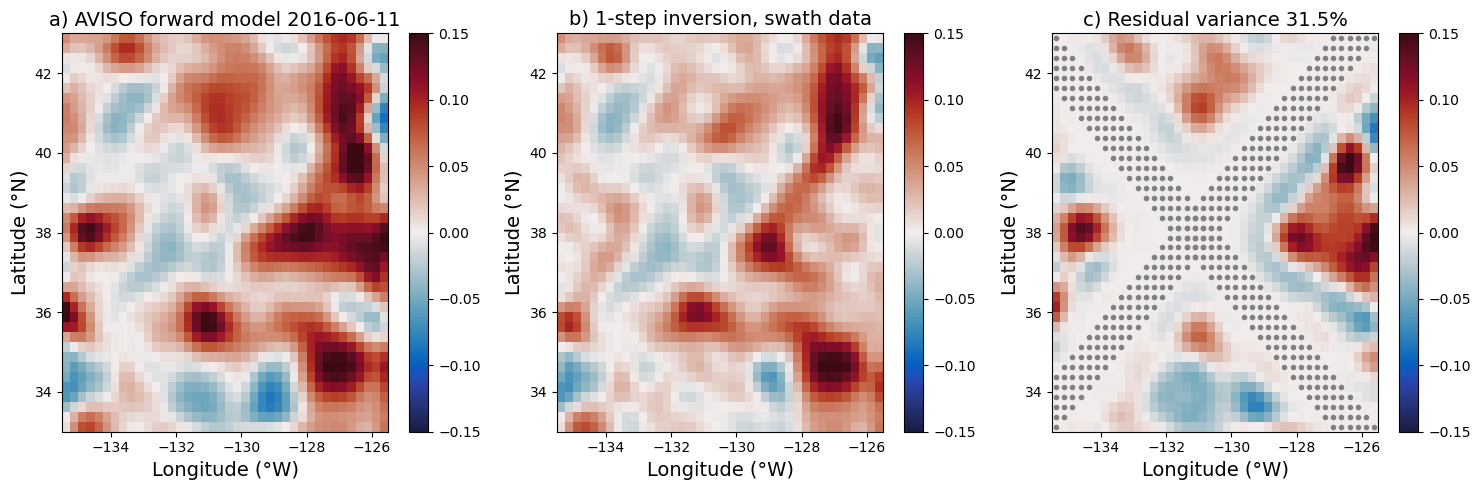

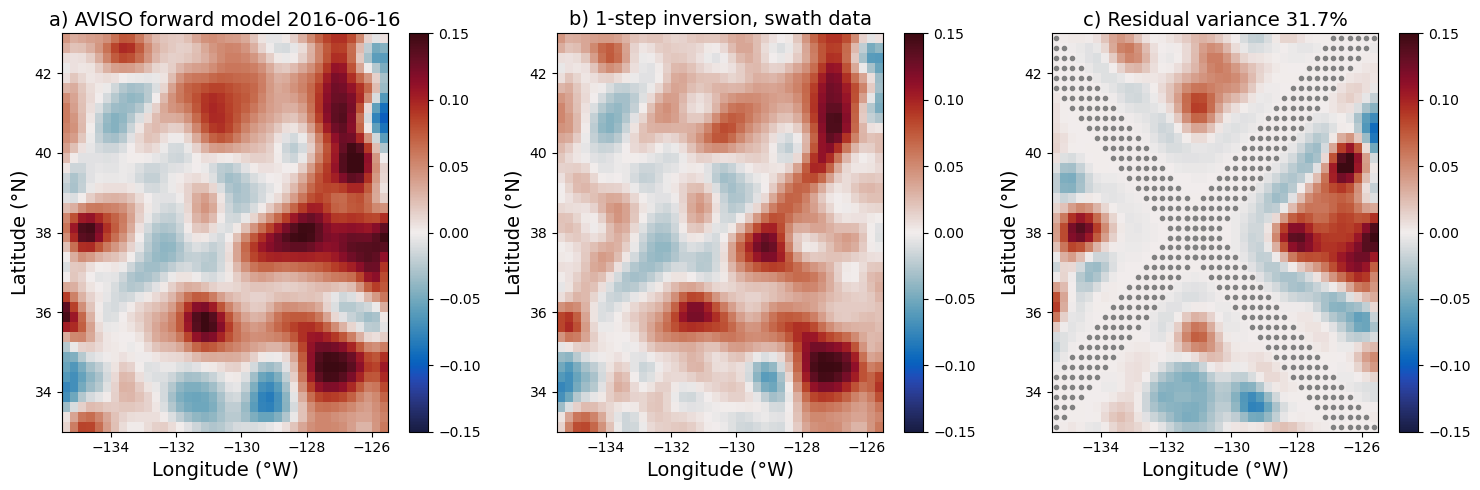

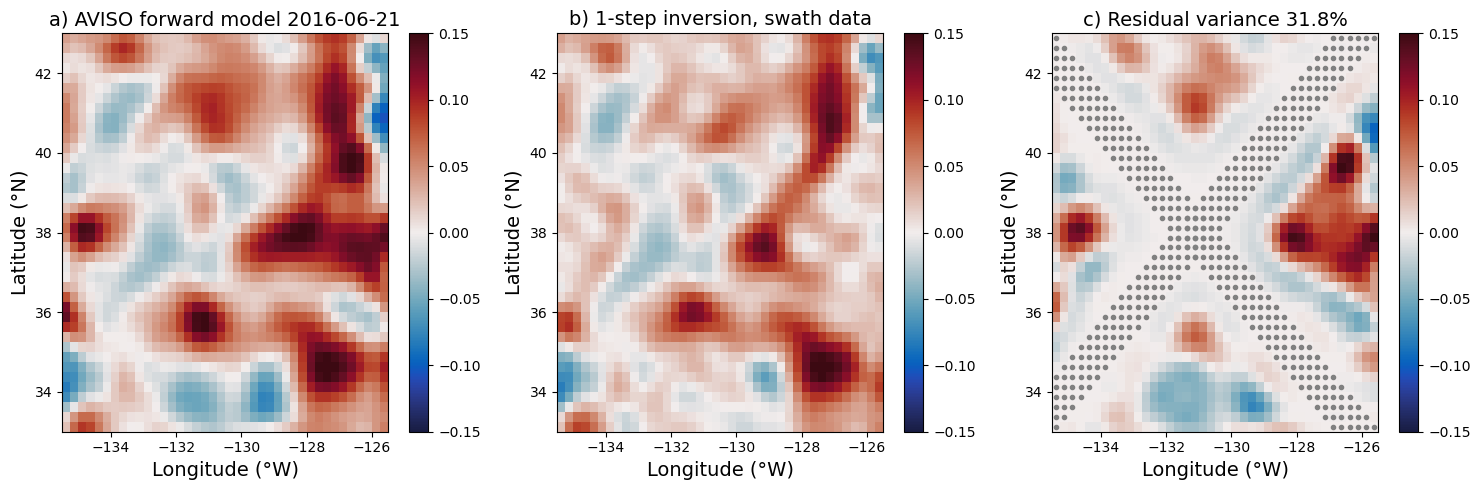

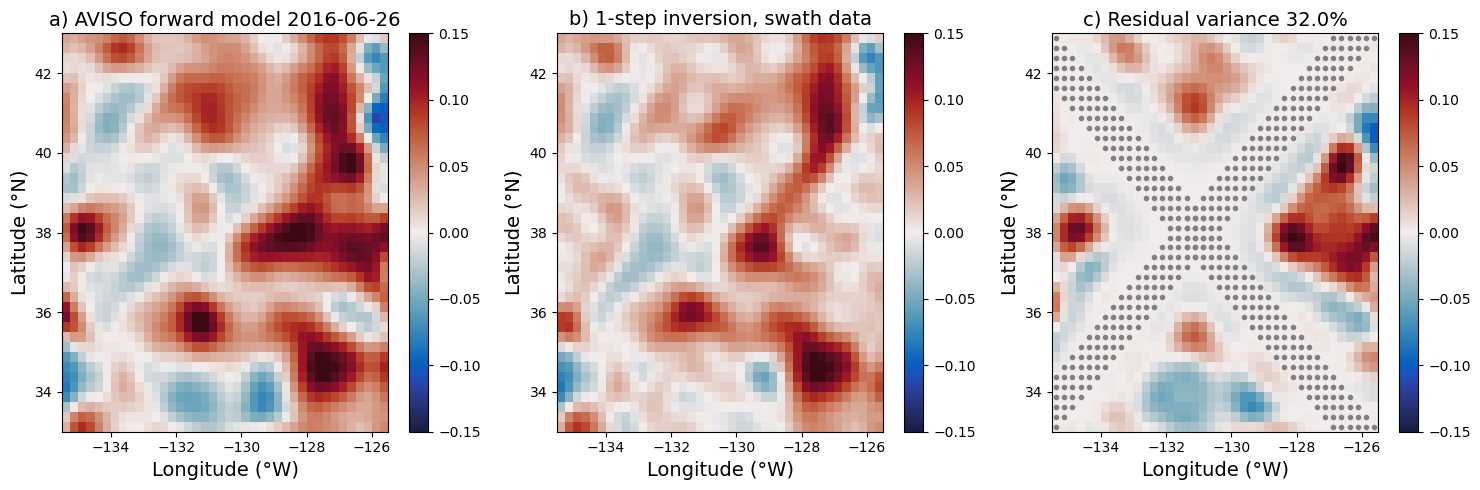

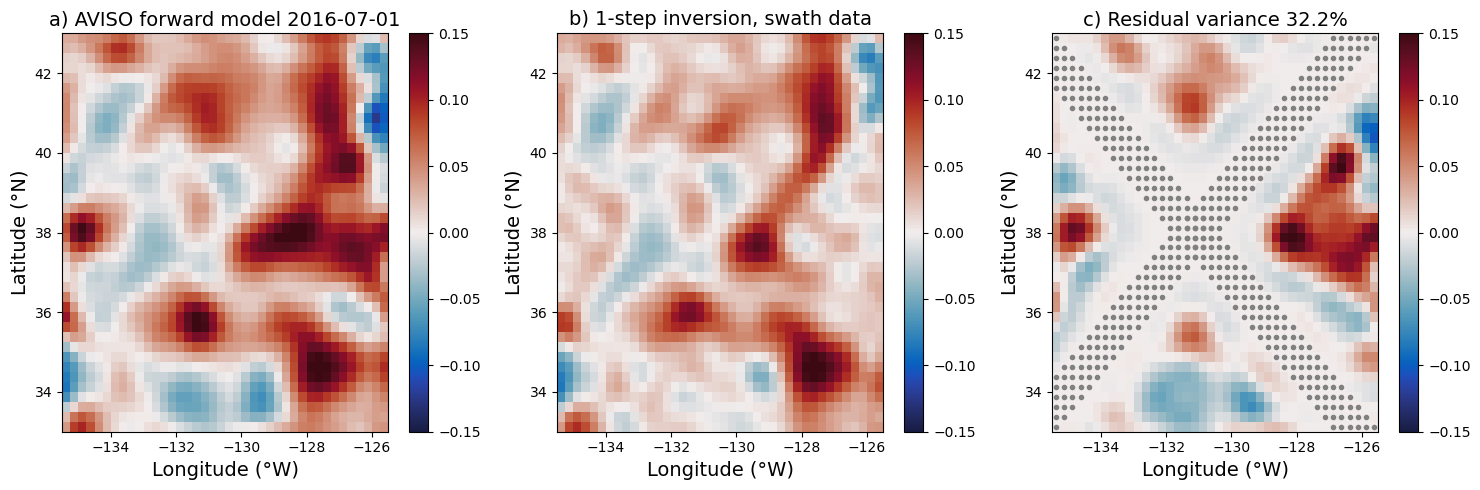

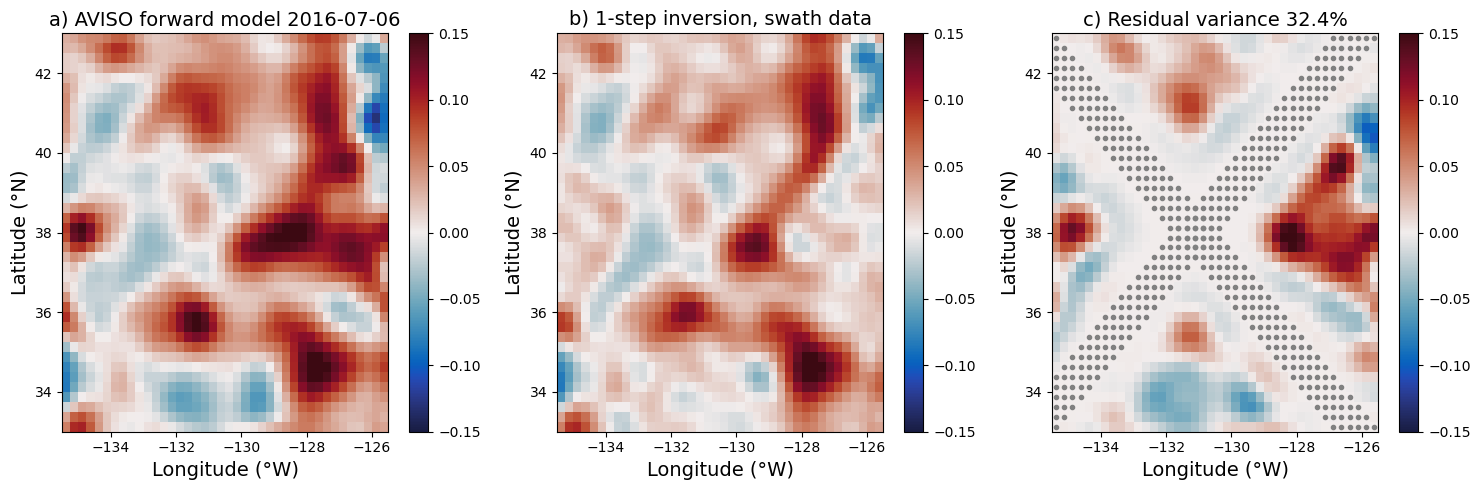

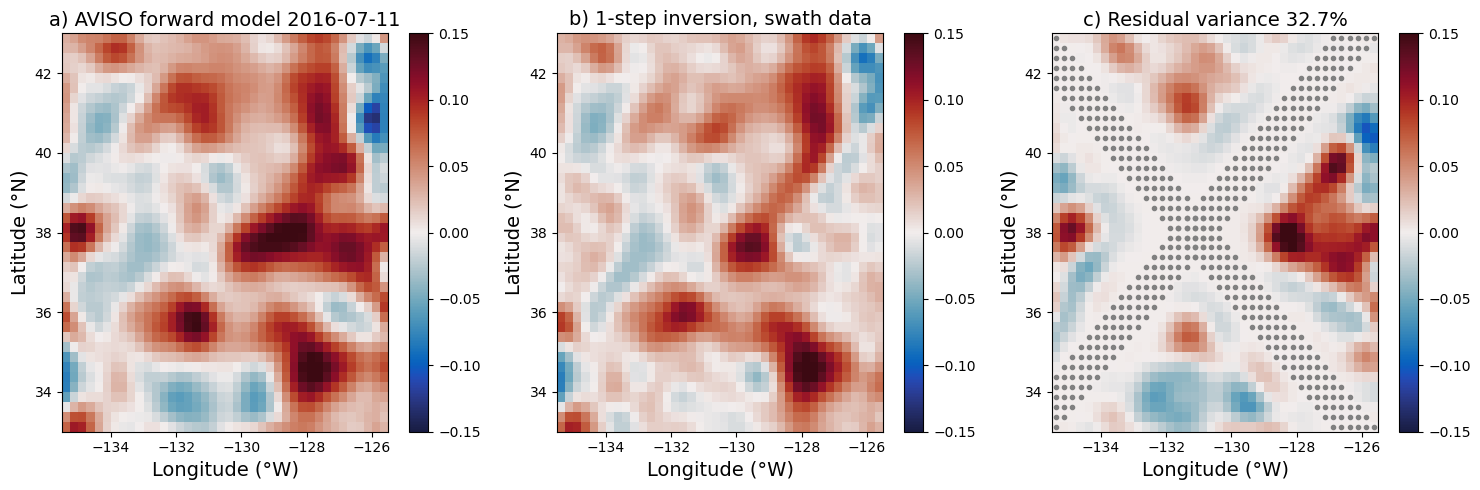

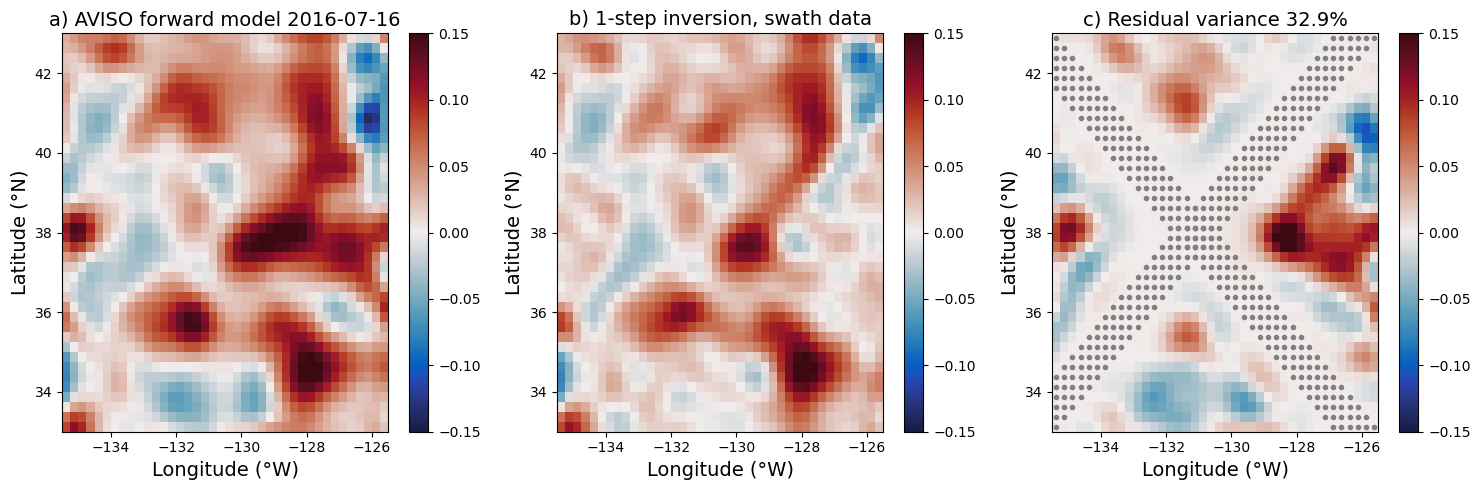

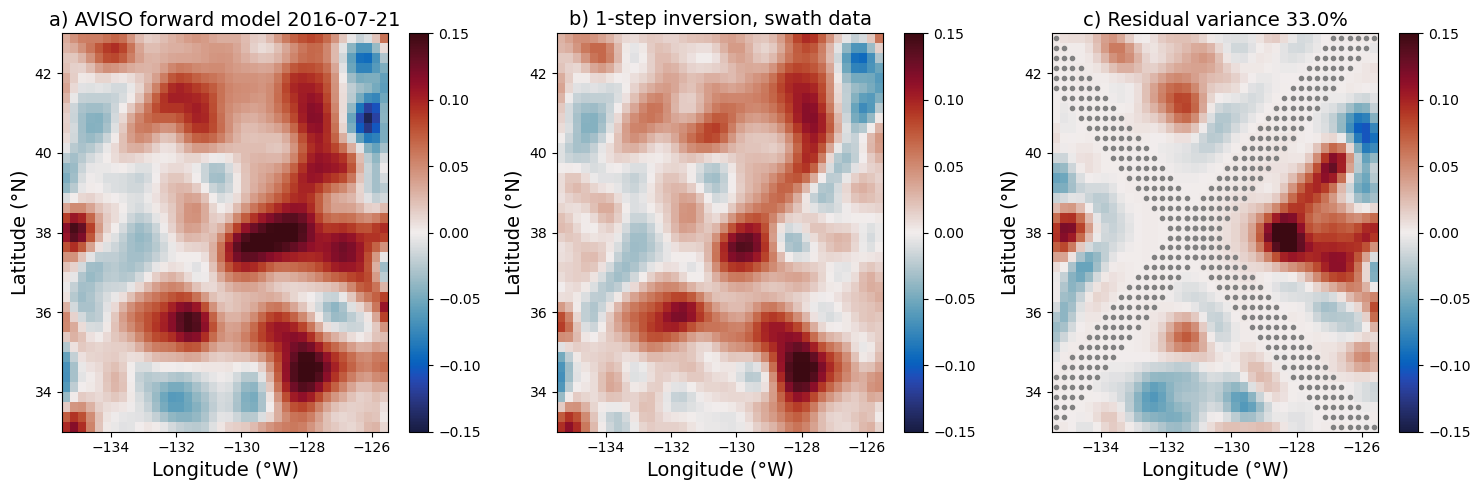

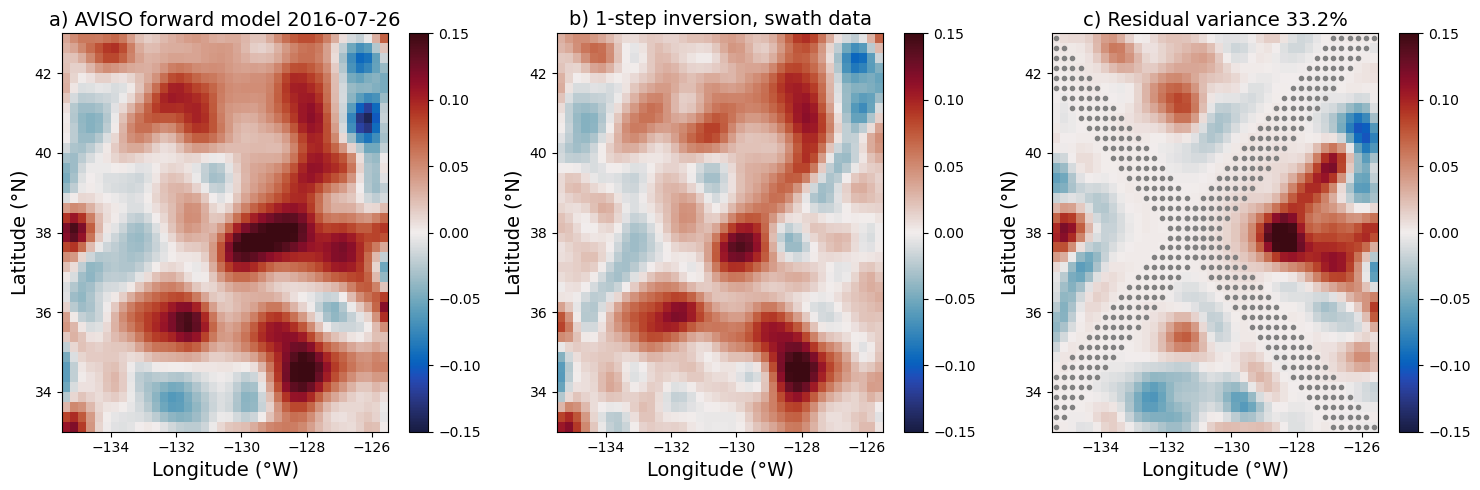

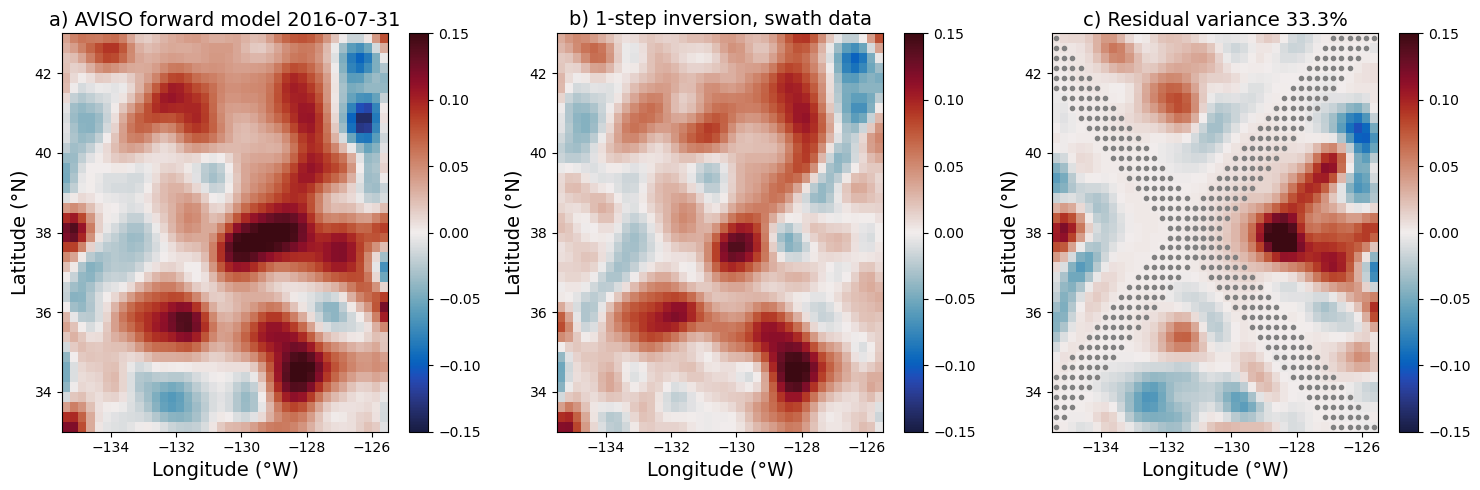

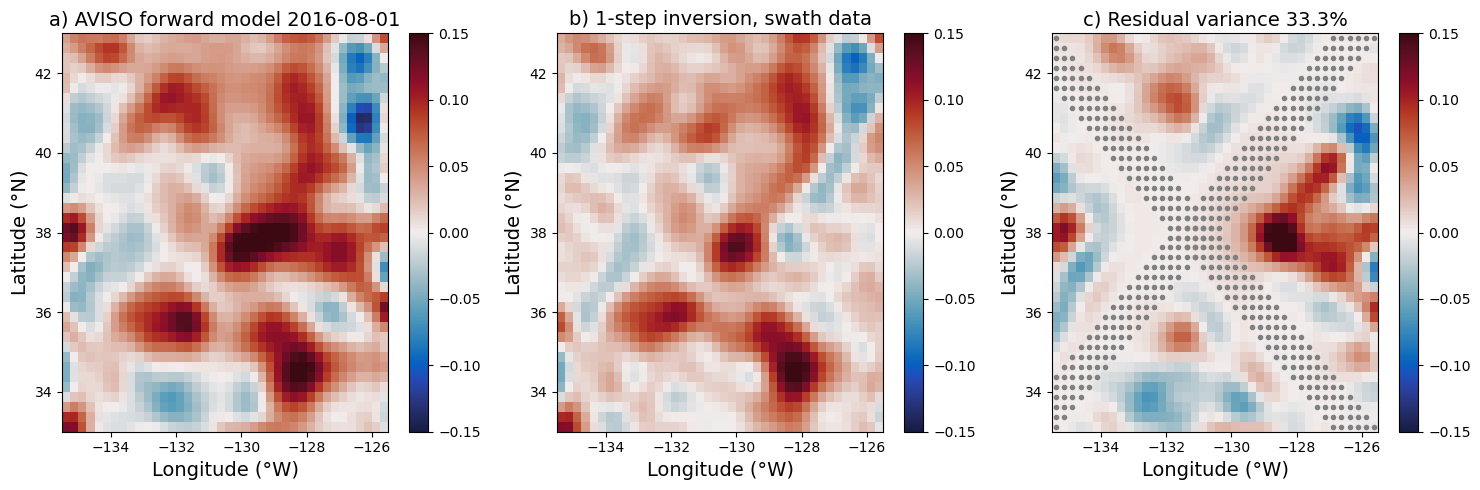

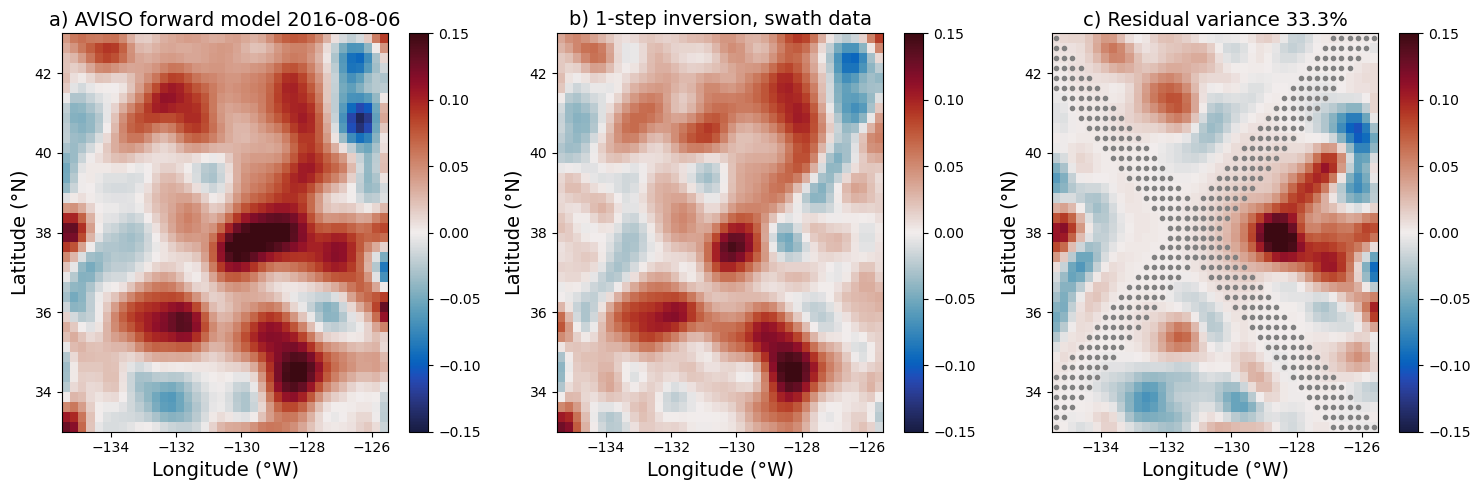

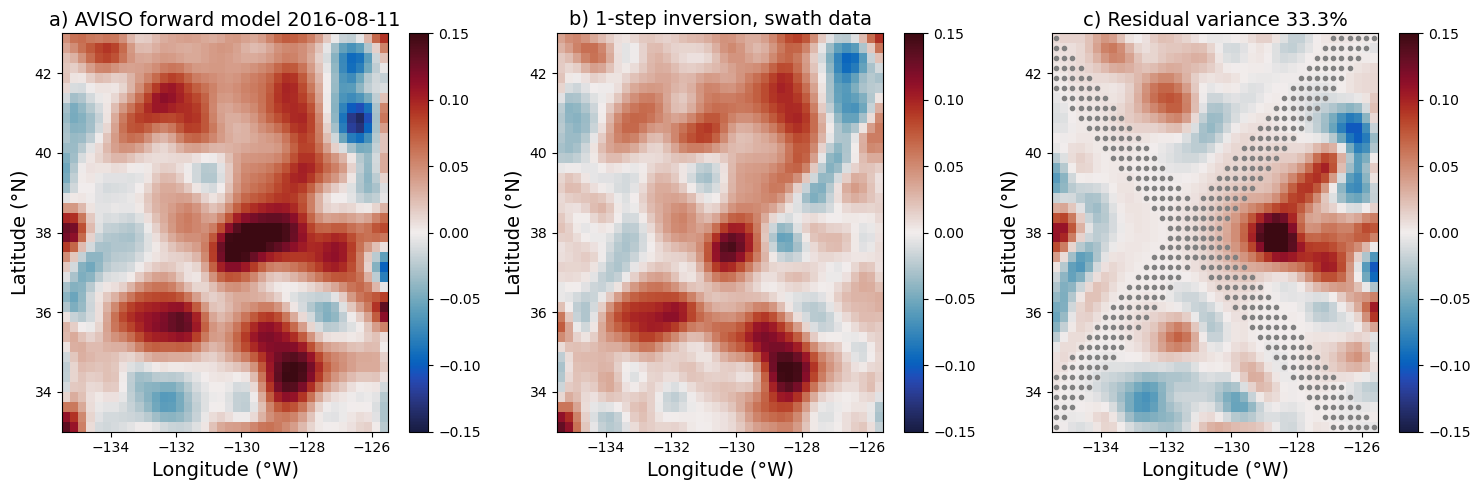

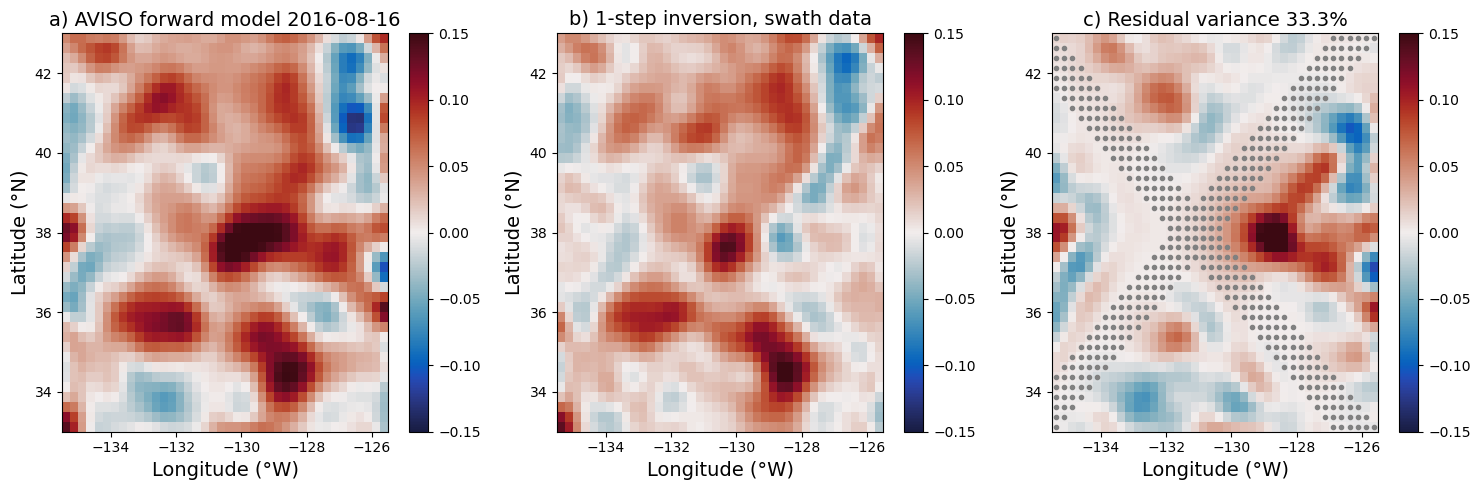

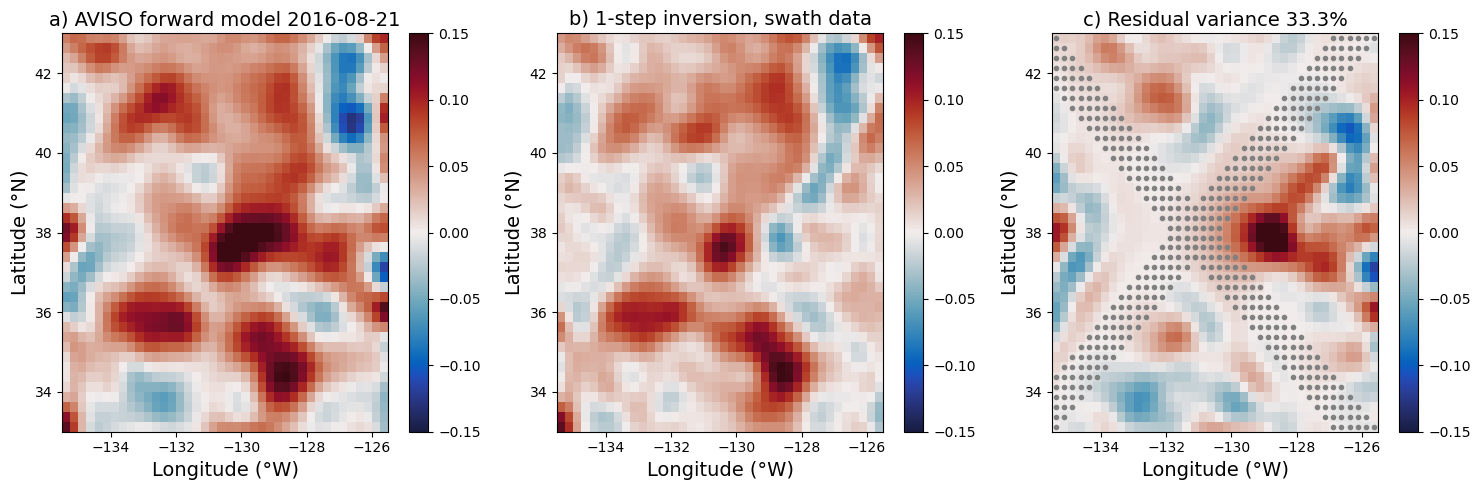

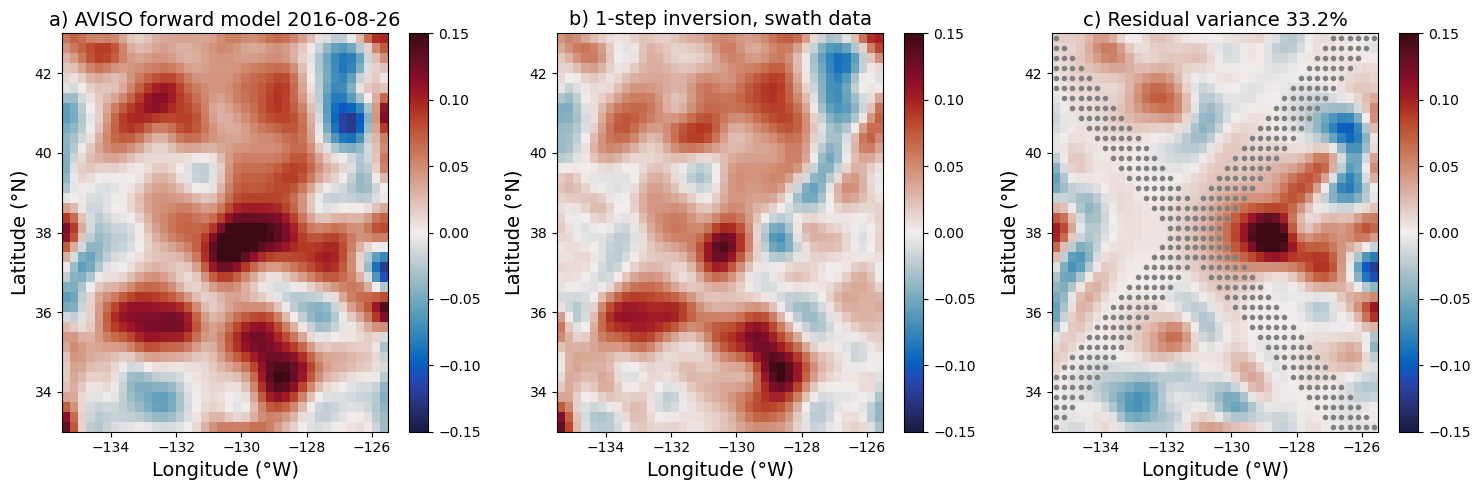

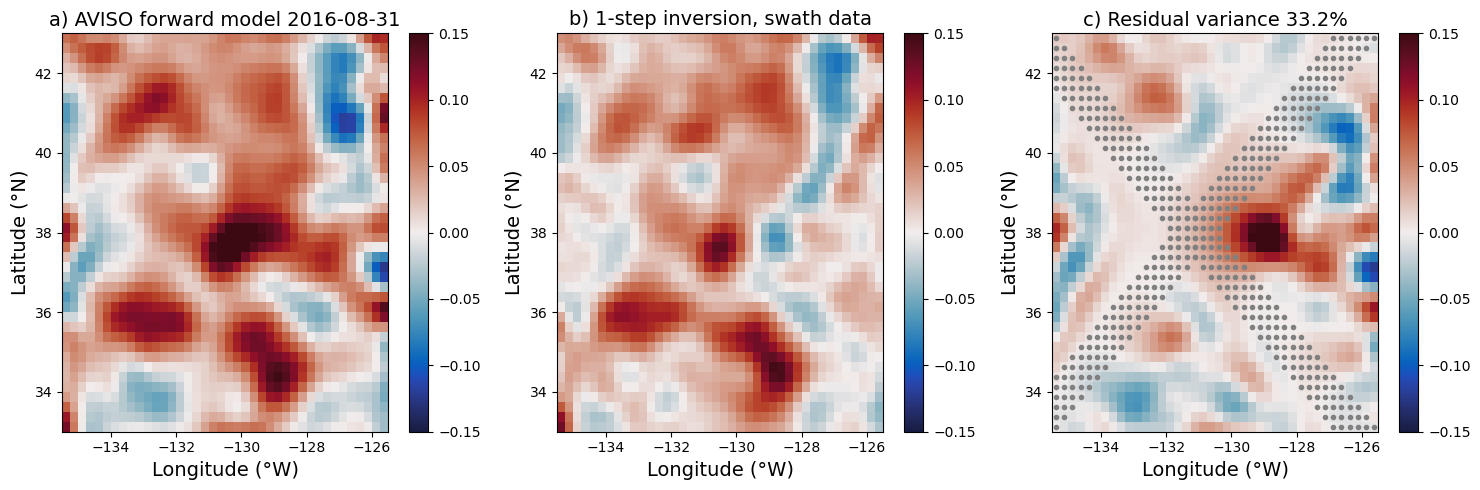

In [71]:
SSHA_predicted = np.zeros([time_range, MSLA0[:, :, 0:1].size])
SSHA_true = np.zeros([time_range, MSLA0[:, :, 0:1].size])
residual_variance = np.zeros(time_range)
MSLA_inverse = np.zeros([MSLA0.shape[0], MSLA0.shape[1], time_range])

for day in range(0, time_range):
#for day in range(2):
    MSLA = MSLA_fwd[:, :, day:day+1] 
    # new H matrix over time
    H_all = build_h_matrix(MSLA, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, day-0)
    # forecast SSH
    SSHA_predicted[day], SSHA_true[day], residual_variance[day] = forecast_ssh(MSLA, amp_swath10, H_all) 
    #SSHA_predicted[day], SSHA_true[day], residual_variance[day] = forecast_ssh(MSLA, amp_swath1, H_all) 
    #SSHA_predicted[day], SSHA_true[day], residual_variance[day] = forecast_ssh(MSLA, amp_all_data, H_all) 
    # reshape the 1-dimensional SSH array to 2-dimensional
    MSLA_inverse[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])
    
    plt.figure(figsize = (15, 5))

    plt.subplot(131)
    
    plt.pcolormesh(lon, lat, MSLA[:, :, 0], cmap = cmo.cm.balance, vmin = -.15, vmax = .15) 
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('a) AVISO forward model ' + str(date_time[day])[:10], fontsize = 14)

    plt.subplot(132)
    plt.pcolormesh(lon, lat, MSLA_inverse[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('b) 1-step inversion, swath data', fontsize = 14)
    
    residual = MSLA[:, :, 0] - MSLA_inverse[:, :, day]
    plt.subplot(133)
    plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
    plt.plot(lon[xvalid_index], lat[yvalid_index], '.', color = 'gray')
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('c) Residual variance ' + str((residual_variance[day]) * 100)[:4] + '%', fontsize = 14)
    
    plt.tight_layout()
    #plt.close()
    plt.savefig('./swath/swath_' + str(date_time[day0 + day])[:10] +'_no_err_' + str(skill.size) + 'waves_with_swath.png', dpi = 100)

In [72]:
# predict=np.matmul(H_all, amp_swath10)
# residual=MSLA_fwd[:,:,1]-np.reshape(predict[2000:4000],[40,50])
# np.mean(residual**2)/np.mean(MSLA_fwd[:,:,0]**2)

In [73]:
# plt.plot(ssh_map[10,:])
# plt.plot(ssh_true[10,:])
# plt.plot(MSLA0[10,:,4])
# plt.plot(MSLA_inverse[10,:,4])

In [74]:
MSLA.shape, MSLA_inverse.shape, SSHA_predicted.shape, SSHA_true.shape, MSLA_fwd.shape
msla_in=np.ma.masked_where(mask==0,MSLA_inverse[:,:,0])
msla_out=np.ma.masked_where(mask==1,MSLA_inverse[:,:,0])
var_in=np.zeros(20)
var_out=np.zeros(20)
for i in range(20):
    msla_in=np.ma.masked_where(mask==0,MSLA_fwd[:,:,i])
    msla_out=np.ma.masked_where(mask==1,MSLA_fwd[:,:,i])
    var_in[i]=np.mean(np.mean((MSLA_inverse[:,:,i]-msla_in)**2,axis=1),axis=0)/(np.mean(np.mean(msla_in**2,axis=1),axis=0))
    var_out[i]=np.mean(np.mean((MSLA_inverse[:,:,i]-msla_out)**2,axis=1),axis=0)/(np.mean(np.mean(msla_out**2,axis=1),axis=0))

In [75]:
# plt.pcolor(msla_out)

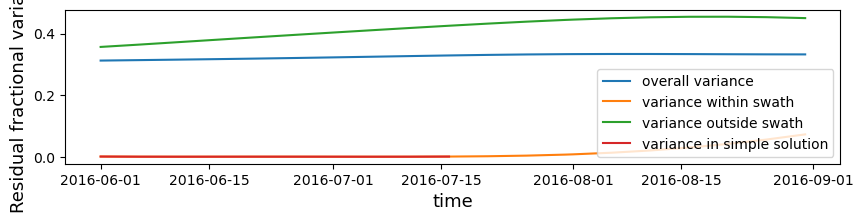

In [76]:
plt.figure(figsize = (10,2))
plt.plot(time[:20], np.mean(np.mean((MSLA_inverse-MSLA_fwd[:,:,0:20])**2,axis=1),axis=0)/np.mean(np.mean((MSLA_fwd[:,:,0:20])**2,axis=1),axis=0),label='overall variance')
plt.plot(time[:20],var_in,label = 'variance within swath')
plt.plot(time[:20],var_out,label='variance outside swath')
plt.plot(time[:10],variance_on_track,label='variance in simple solution')
plt.ylabel('Residual fractional variance', fontsize = 13)
plt.xlabel('time', fontsize = 13)
plt.legend()

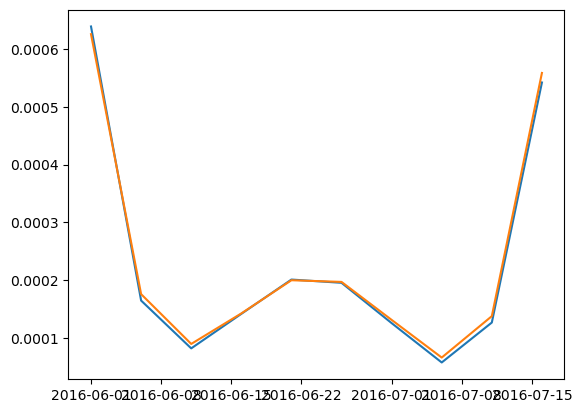

In [77]:
plt.plot(time[:10],variance_on_track,label='variance in simple solution')
plt.plot(time[:10],var_in[:10],label = 'variance within swath')

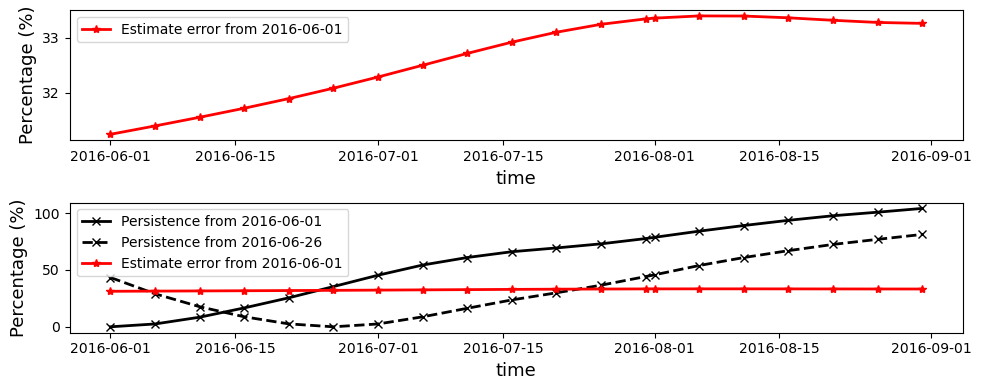

In [78]:
persistence = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day0:day0+1]
persistence0 = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day0:day0+1]
persistence1 = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day1:day1+1]
daym=int((day0+day1)/2)
persistencem = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, daym:daym+1]
prediction_err = MSLA_inverse[:, :, :time_range] - MSLA_fwd[:, :, :time_range]
var_persistence = np.zeros(persistence.shape[-1])
var_persistence0 = np.zeros(persistence0.shape[-1])
var_persistence1 = np.zeros(persistence1.shape[-1])
var_persistencem = np.zeros(persistence1.shape[-1])
var_prediction_err = np.zeros(prediction_err.shape[-1])

for t in range(persistence.shape[-1]):
    # normalize the error/persistence 
    var_persistence0[t] = (np.mean(persistence0[:, :, t] ** 2)) / (np.mean(SSHA[:, :, day0 + t :day0 + t + 1].data ** 2))
    var_persistence1[t] = (np.mean(persistence1[:, :, t] ** 2)) / (np.mean(SSHA[:, :, day1 + t :day1 + t + 1].data ** 2))
    var_persistencem[t] = (np.mean(persistencem[:, :, t] ** 2)) / (np.mean(SSHA[:, :, day0 + t :day0 + t + 1].data ** 2))
    var_persistence[t] = (np.mean(persistence[:, :, t] ** 2)) / (np.mean(SSHA[:, :, day0 + t :day0 + t + 1].data ** 2))
    var_prediction_err[t] = (np.mean(prediction_err[:, :, t] ** 2)) / (np.mean(MSLA_fwd[:, :, t :t + 1] ** 2))

plt.figure(figsize = (10,4))
plt.subplot(211)
plt.plot(time[:time_range],  (residual_variance[:time_range]) * 100,  
         '-*',linewidth = 2, color = 'r', label = 'Estimate error from ' + str(time[0])[:10])
plt.ylabel('Percentage (%)', fontsize = 13)
plt.xlabel('time', fontsize = 13)
plt.legend()
plt.subplot(212)
plt.plot(time[:time_range], (var_persistence0[:time_range]) * 100,  
         '-x',linewidth = 2, color = 'k', label = 'Persistence from ' + str(time[0])[:10])
plt.plot(time[:time_range], (var_persistencem[:time_range]) * 100,  
         '--x',linewidth = 2, color = 'k', label = 'Persistence from ' + str(time[daym])[:10])
plt.plot(time[:time_range],  (residual_variance[:time_range]) * 100,  
         '-*',linewidth = 2, color = 'r', label = 'Estimate error from ' + str(time[0])[:10])
#plt.plot(time[:time_range],  (var_prediction_err[:time_range]) * 100,  
#         '-*',linewidth = 2, color = 'r', label = 'Estimate error from ' + str(time[0])[:10])
plt.ylabel('Percentage (%)', fontsize = 13)
plt.xlabel('time', fontsize = 13)
plt.legend()
plt.tight_layout()
plt.savefig('./prediction_vs_persistence/swath_prediction_err_vs_persistence_' + str(M) + '_waves_swathdata_k' + str(exp) + '.png', dpi = 300)

In [79]:
#amp_swath[np.abs(amp_swath)>1e0] =0
#amp[np.abs(amp)>1e0] =0
#amp_syn[np.abs(amp_syn)>1e0] =0
#amp_all_data[np.abs(amp_all_data)>1e0] =0

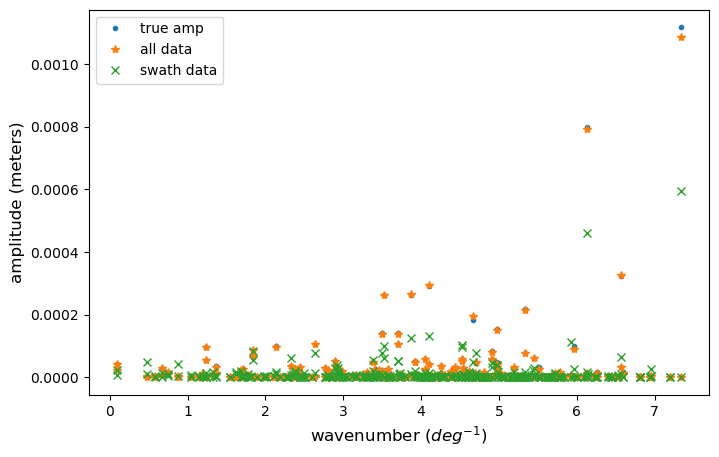

In [80]:
plt.figure(figsize = (8, 5))
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp ** 2 , '.', label = 'true amp')
plt.plot(kl, amp_all_data ** 2 , '*', label = 'all data')
plt.plot(kl, amp_swath10 ** 2, 'x', label = 'swath data')
plt.legend()
plt.savefig('amp_k' + str(exp) +'.png')

Text(0, 0.5, 'swath estimate of |amplitude|')

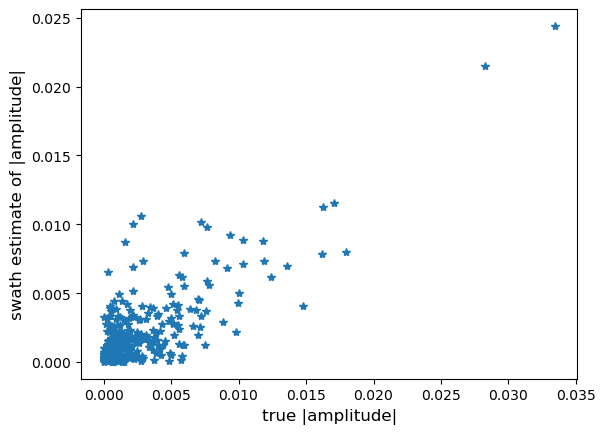

In [81]:
plt.plot(np.abs(amp),np.abs(amp_swath10),'*')
plt.xlabel('true |amplitude|', fontsize = 12)
plt.ylabel('swath estimate of |amplitude|', fontsize = 12)

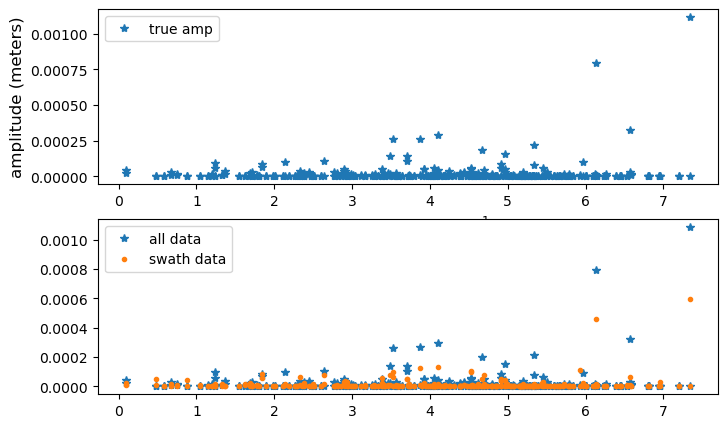

In [82]:
plt.figure(figsize = (8, 5))
plt.subplot(211)
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp ** 2 , '*', label = 'true amp')
plt.legend()

plt.subplot(212)
plt.plot(kl, amp_all_data ** 2 , '*', label = 'all data')
plt.plot(kl, amp_swath10**2, '.', label = 'swath data')
plt.legend()
plt.savefig('amp_k' + str(exp) +'.png')

#### set the amplitude of the dominant wave to be 0

In [83]:
# amp_swath[np.abs(amp_swath)>1e-1] =0
# amp[np.abs(amp)>1e-1] =0
# #amp_syn[np.abs(amp_syn)>1e-1] =0
# amp_all_data[np.abs(amp_all_data)>1e-1] =0

In [84]:
icount=0
ikeep=np.array([],dtype=int)
for i in range(len(amp)):
    if(np.abs(amp_swath10[i])<1.e-1 and np.abs(amp[i])<1.e-1):
        ikeep = np.append(ikeep,[int(i)],axis=0)
        icount=icount+1

In [85]:
ikeep[ikeep]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

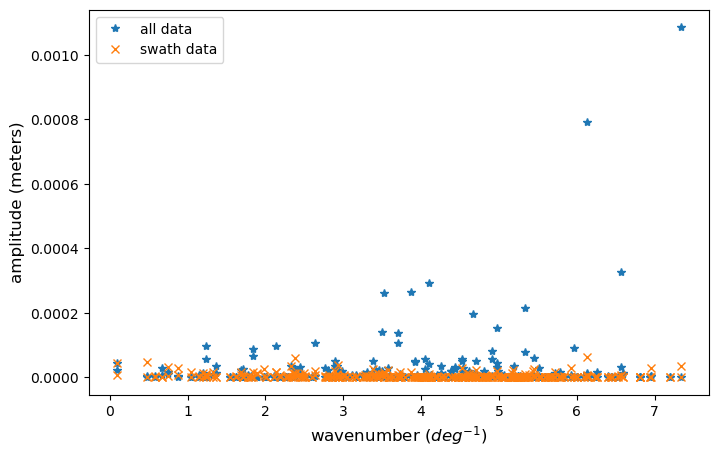

In [86]:
plt.figure(figsize = (8, 5))
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)

#plt.plot(kl, amp ** 2 , '*', label = 'true amp')
plt.plot(kl, amp_all_data[ikeep] ** 2 , '*', label = 'all data')
plt.plot(kl, amp_swath[ikeep]**2, 'x', label = 'swath data')
#plt.plot(kl, amp_syn ** 2, 'x', label = 'swath data')
plt.legend()
plt.savefig('amp_k' + str(exp) +'.png')

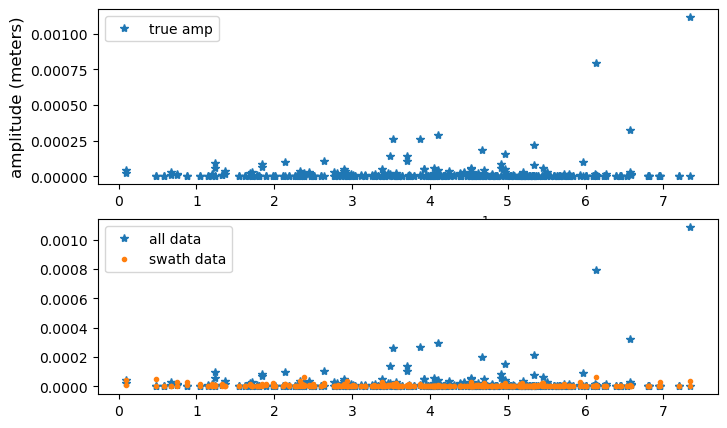

In [87]:
plt.figure(figsize = (8, 5))
plt.subplot(211)
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp ** 2 , '*', label = 'true amp')
plt.legend()

plt.subplot(212)
plt.plot(kl, amp_all_data[ikeep] ** 2 , '*', label = 'all data')
plt.plot(kl, amp_swath[ikeep]**2, '.', label = 'swath data')
plt.legend()
plt.savefig('amp_k' + str(exp) +'.png')